# Detección de cardiopatías 

## Libraries 

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import random

# Plotting library
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
from matplotlib.colors import TwoSlopeNorm
from plotnine import ggplot, aes, geom_bar, labs, ggtitle, theme
plt.style.use('seaborn-v0_8') 

# Funciones para hacer cálculo estadístico
import statsmodels.api as sm
from statsmodels.formula.api import ols
import sklearn
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA

# Type hint
from typing import List, Tuple#, Union, Dict, Optional

# Data pre-processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler


# Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV # Optimización de hiperparámetros para un modelo
from sklearn.model_selection import cross_validate
import catboost
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras.models import load_model


# constants: 
TARGET_VARIABLE = 'HeartDisease'

# packages versions
print('Python: {}'.format(sys.version))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Seaborn: {}'.format(sns.__version__))
print('Sklearn: {}'.format(sklearn.__version__))
print('Catboost: {}'.format(catboost.__version__))
print('TensorFlow: {}'.format(tf.__version__))
# To check if we have access to the GPU on my Apple M1 Mac
print("TensorFlow has access to the following devices:")
for device in tf.config.list_physical_devices():
    print(f"· {device}")



Python: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:38:11) 
[Clang 14.0.6 ]
Pandas: 1.5.3
Numpy: 1.23.2
Matplotlib: 3.7.1
Seaborn: 0.12.2
Sklearn: 1.2.1
Catboost: 1.1.1
TensorFlow: 2.12.0
TensorFlow has access to the following devices:
· PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
· PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Load data

In [3]:
raw_data = pd.read_csv('heart_2020.csv', delimiter = ',')
display(raw_data.head())
# dimensión del df (filas y columnas)
print(f"{raw_data.shape}\n")
# info de las columnas del df
print(raw_data.info())

HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  16.60     Yes              No     No             3.0   
1           No  20.34      No              No    Yes             0.0   
2           No  26.58     Yes              No     No            20.0   
3           No  24.21      No              No     No             0.0   
4           No  23.71      No              No     No            28.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0          30.0          No  Female        55-59  White      Yes   
1           0.0          No  Female  80 or older  White       No   
2          30.0          No    Male        65-69  White      Yes   
3           0.0          No  Female        75-79  White       No   
4           0.0         Yes  Female        40-44  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
0              Yes  Very good        5.0    Yes            No        Yes  
1              Yes  Very good        7.0     No            No         No  
2              Yes       Fair        8.0    Yes            No         No  
3               No       Good        6.0     No            No        Yes  
4              Yes  Very good        8.0     No            No         No

(319795, 18)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  Kidney

## Separación de datasets en train y test

In [4]:
# Separar los datos en conjuntos de train y test (80-20). Stratify!!
train_data, test_data = train_test_split(raw_data, test_size=0.2, stratify=raw_data['HeartDisease'], random_state=42)

# Guardar los conjuntos de datos en archivos CSV
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

Cargamos el train dataset:


In [4]:
heart_data = pd.read_csv('train_data.csv', delimiter = ',')
print("Full train dataset shape is {}".format(heart_data.shape))

Full train dataset shape is (255836, 18)


## Exploratory Data Analysis (EDA)

### Exploración inicial rápida

In [4]:
def explore_data(df: pd.DataFrame) -> None:
    """
    Takes in a pandas DataFrame and performs exploratory data analysis.

    Parameters:
    -----------
    df: pandas DataFrame
        The DataFrame to be analyzed.

    Returns:
    --------
    None
    """

    # Print the dimensions of the DataFrame
    print(f"The dataset includes {df.shape[0]} instances (rows) and {df.shape[1]} variables (columns).\n")

    # Display the first few rows of the DataFrame
    display(df.head())
    print("\n")

    # Print the column information for the DataFrame
    print(df.info())
    print("\n")
    
    # Check missing values
    print(f"Missing values: \n{df.isna().sum()}")
    print("\n")

    # Select only the numeric features
    numeric_vars = df.select_dtypes(include=['int64', 'float64']).columns

    # Calculate the descriptive statistics for the numeric variables
    display(df[numeric_vars].describe())
    
    # Check duplicates
    print(f"\n Number of duplicates: {df.duplicated().sum()}")


In [13]:
explore_data(heart_data)

The dataset includes 255836 instances (rows) and 18 variables (columns).



HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0           No  23.62     Yes              No     No            30.0   
1           No  22.43      No              No     No             1.0   
2           No  33.28     Yes              No     No            20.0   
3           No  24.96     Yes              No     No             0.0   
4           No  27.25     Yes              No     No             0.0   

   MentalHealth DiffWalking     Sex AgeCategory      Race Diabetic  \
0          30.0         Yes  Female       45-49     White       No   
1           0.0          No    Male       25-29     White       No   
2          30.0          No  Female       30-34  Hispanic       No   
3           0.0          No  Female       65-69     White       No   
4           0.0          No  Female       55-59     White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
0               No       Fair        5.0    Yes            No         No  
1              Yes  Very good        8.0     No            No         No  
2               No       Fair        7.0     No            No         No  
3              Yes  Very good        8.0     No            No         No  
4              Yes  Very good        5.0     No            No         No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255836 entries, 0 to 255835
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      255836 non-null  object 
 1   BMI               255836 non-null  float64
 2   Smoking           255836 non-null  object 
 3   AlcoholDrinking   255836 non-null  object 
 4   Stroke            255836 non-null  object 
 5   PhysicalHealth    255836 non-null  float64
 6   MentalHealth      255836 non-null  float64
 7   DiffWalking       255836 non-null  object 
 8   Sex               255836 non-null  object 
 9   AgeCategory       255836 non-null  object 
 10  Race              255836 non-null  object 
 11  Diabetic          255836 non-null  object 
 12  PhysicalActivity  255836 non-null  object 
 13  GenHealth         255836 non-null  object 
 14  SleepTime         255836 non-null  float64
 15  Asthma            255836 non-null  object 
 16  KidneyDisease     

BMI  PhysicalHealth   MentalHealth      SleepTime
count  255836.000000   255836.000000  255836.000000  255836.000000
mean       28.321908        3.373665       3.903071       7.097973
std         6.347422        7.952355       7.959241       1.436551
min        12.020000        0.000000       0.000000       1.000000
25%        24.030000        0.000000       0.000000       6.000000
50%        27.320000        0.000000       0.000000       7.000000
75%        31.450000        2.000000       3.000000       8.000000
max        94.850000       30.000000      30.000000      24.000000


 Number of duplicates: 12559


## Variable objetivo (HeartDisease)

In [14]:
# Checking data imbalance 
print(heart_data['HeartDisease'].value_counts()) # recuento de instancias de cada clase en el df

No     233938
Yes     21898
Name: HeartDisease, dtype: int64


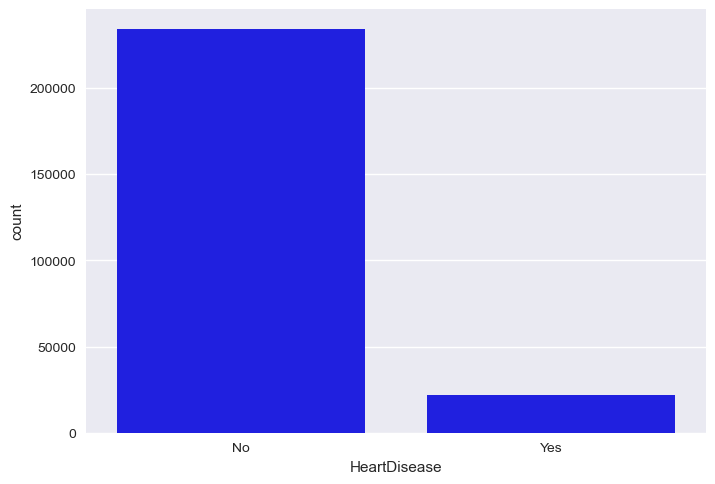

In [15]:
sns.countplot(x = heart_data[TARGET_VARIABLE], color = 'blue')
plt.show()

- Observamos un claro desbalanceo de clases en la variable objetivo HeartDisease.

## Data pre-processing and Feature Engineering

1. Pasar categoricas binarias a 0 y 1.
2. Categorizar por rangos la variable BMI: 
    - Por debajo de 18.5 = Bajo peso
    - 18.5 – 24.9 = Normal
    - 25.0 – 29.9 = Sobrepeso
    - 30.0 o más = Obesidad
3. Categorizar por rangos la variable SleepTime. 
4. Convertir variables que son categóricas a tipo 'category'. 


In [5]:
class DataPreprocessor: 
    target = TARGET_VARIABLE

    def data_preprocessor(self, file_path):
        self.load_data(file_path)
        self.categorical_to_zero_one()
        self.bmi_to_ranges()
        self.sleep_to_ranges()
        self.convert_categorical_to_category()

    def load_data(self, filepath) -> None:
        self.df = pd.read_csv(filepath, delimiter=',').copy()

    def categorical_to_zero_one(self) -> None:
        # Transform Yes/No to numeric
        categorical_yn = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 
                        'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']

        for var in categorical_yn:
            self.df[var] = self.df[var].map({'No': 0, 'Yes': 1})

        # Transform Female/Male to numeric
        self.df['Sex'] = self.df['Sex'].map({'Female': 0, 'Male': 1})
    
    
    def bmi_conditions(self, x:pd.Series) -> pd.Series:
        conditions = [
            pd.isna(x),
            x<18.5,
            x.between(18.5, 25),
            x.between(25,30),
            x > 30
        ]
        choices = [
            "Unknown",
            "Bajo Peso",
            "Normal",
            "Sobrepeso",
            "Obesidad"
        ]
        return np.select(conditions, choices)
        
    
    def bmi_to_ranges(self) -> None: 
        # aplicamos la función a la columna 'BMI' del DataFrame  
        #self.df['BMI_cat'] =  self.df['BMI'].apply(bmi_conditions)
        self.df['BMI_cat'] =  self.bmi_conditions(self.df['BMI'])

    
    def sleep_conditions(self, x: pd.Series) -> pd.Series:
        conditions = [
            pd.isna(x),
            x<5,
            x.between(5, 7),
            x.between(7,9),
            x > 9
        ]
        choices = [
            "Unknown",
            "<5",
            "5-7",
            "7-9",
            ">=9"
        ]
        return np.select(conditions, choices)

    
    def sleep_to_ranges(self) -> None: 
        # aplicamos la función a la columna 'SleepTime' del DataFrame  
        #self.df['SleepTime_cat'] =  self.df['SleepTime'].apply(sleep_conditions)
        self.df['SleepTime_cat'] =  self.sleep_conditions(self.df['SleepTime'])

    
    def convert_categorical_to_category(self) -> None:
        cat_features = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 
                        'Stroke', 'DiffWalking', 'PhysicalActivity', 
                        'Asthma', 'KidneyDisease', 'SkinCancer','Sex',
                        'BMI_cat','SleepTime_cat','AgeCategory','Race',
                        'Diabetic','GenHealth']
        for i in range(0,len(cat_features)):
            self.df[cat_features[i]] = self.df[cat_features[i]].astype("category")

In [6]:
def convert_categorical_to_category(df: pd.DataFrame) -> None:
    cat_features = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 
                    'Stroke', 'DiffWalking', 'PhysicalActivity', 
                    'Asthma', 'KidneyDisease', 'SkinCancer','Sex',
                    'BMI_cat','SleepTime_cat','AgeCategory','Race',
                    'Diabetic','GenHealth']
    for i in range(0,len(cat_features)):
        df[cat_features[i]] = df[cat_features[i]].astype("category")

### Train set pre-processing

In [7]:
file_path_train = 'train_data.csv'

data_preprocessor = DataPreprocessor()
data_preprocessor.data_preprocessor(file_path_train)

# guardamos en csv
data_preprocessor.df.to_csv('train_data_preprocessed.csv', index=False)

In [220]:
# cargamos el dataset de train preprocesado
train_data_preprocessed = pd.read_csv('train_data_preprocessed.csv', delimiter=',')
# convertimos las categóricas a 'category' ya que al volver a cargar el csv no se conservan los data types modificados
convert_categorical_to_category(train_data_preprocessed)

explore_data(train_data_preprocessed)

The dataset includes 255836 instances (rows) and 20 variables (columns).



HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0            0  23.62       1               0      0            30.0   
1            0  22.43       0               0      0             1.0   
2            0  33.28       1               0      0            20.0   
3            0  24.96       1               0      0             0.0   
4            0  27.25       1               0      0             0.0   

   MentalHealth DiffWalking Sex AgeCategory      Race Diabetic  \
0          30.0           1   0       45-49     White       No   
1           0.0           0   1       25-29     White       No   
2          30.0           0   0       30-34  Hispanic       No   
3           0.0           0   0       65-69     White       No   
4           0.0           0   0       55-59     White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  \
0                0       Fair        5.0      1             0          0   
1                1  Very good        8.0      0             0          0   
2                0       Fair        7.0      0             0          0   
3                1  Very good        8.0      0             0          0   
4                1  Very good        5.0      0             0          0   

     BMI_cat SleepTime_cat  
0     Normal           5-7  
1     Normal           7-9  
2   Obesidad           5-7  
3     Normal           7-9  
4  Sobrepeso           5-7



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255836 entries, 0 to 255835
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   HeartDisease      255836 non-null  category
 1   BMI               255836 non-null  float64 
 2   Smoking           255836 non-null  category
 3   AlcoholDrinking   255836 non-null  category
 4   Stroke            255836 non-null  category
 5   PhysicalHealth    255836 non-null  float64 
 6   MentalHealth      255836 non-null  float64 
 7   DiffWalking       255836 non-null  category
 8   Sex               255836 non-null  category
 9   AgeCategory       255836 non-null  category
 10  Race              255836 non-null  category
 11  Diabetic          255836 non-null  category
 12  PhysicalActivity  255836 non-null  category
 13  GenHealth         255836 non-null  category
 14  SleepTime         255836 non-null  float64 
 15  Asthma            255836 non-null  category
 16  

BMI  PhysicalHealth   MentalHealth      SleepTime
count  255836.000000   255836.000000  255836.000000  255836.000000
mean       28.321908        3.373665       3.903071       7.097973
std         6.347422        7.952355       7.959241       1.436551
min        12.020000        0.000000       0.000000       1.000000
25%        24.030000        0.000000       0.000000       6.000000
50%        27.320000        0.000000       0.000000       7.000000
75%        31.450000        2.000000       3.000000       8.000000
max        94.850000       30.000000      30.000000      24.000000


 Number of duplicates: 12559


## Visualizaciones de las variables

In [12]:
# seleccionamos y guardamos las variables numéricas y categóricas
numeric_cols = train_data_preprocessed.select_dtypes(include=['float64', 'int64']).columns.to_list()
categoric_cols = train_data_preprocessed.select_dtypes(include='category').columns.to_list()

### Distribución de las variables numéricas

Exploramos la distribución de las variables numéricas.

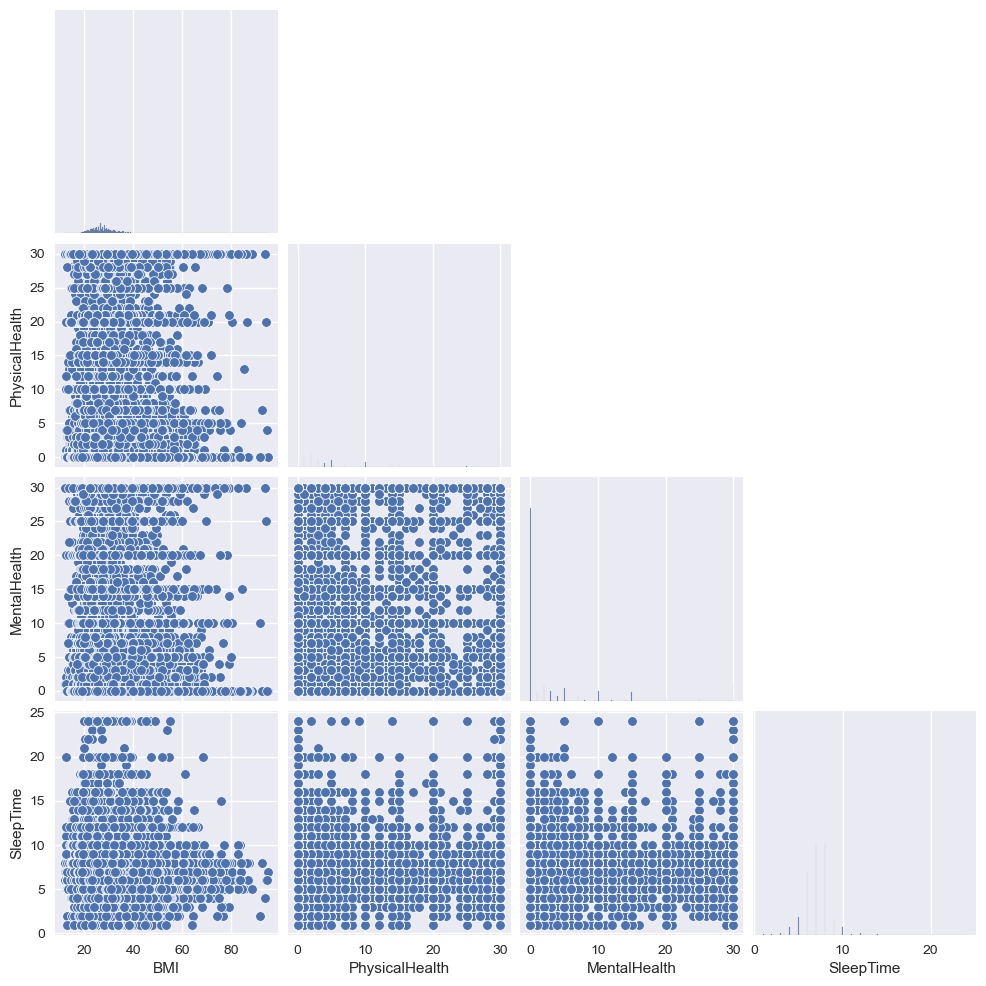

In [13]:
# gráfico de pares para todas las variables numéricas
plt.style.use('seaborn-v0_8')
sns.pairplot(train_data_preprocessed[numeric_cols], corner=True)
plt.show()

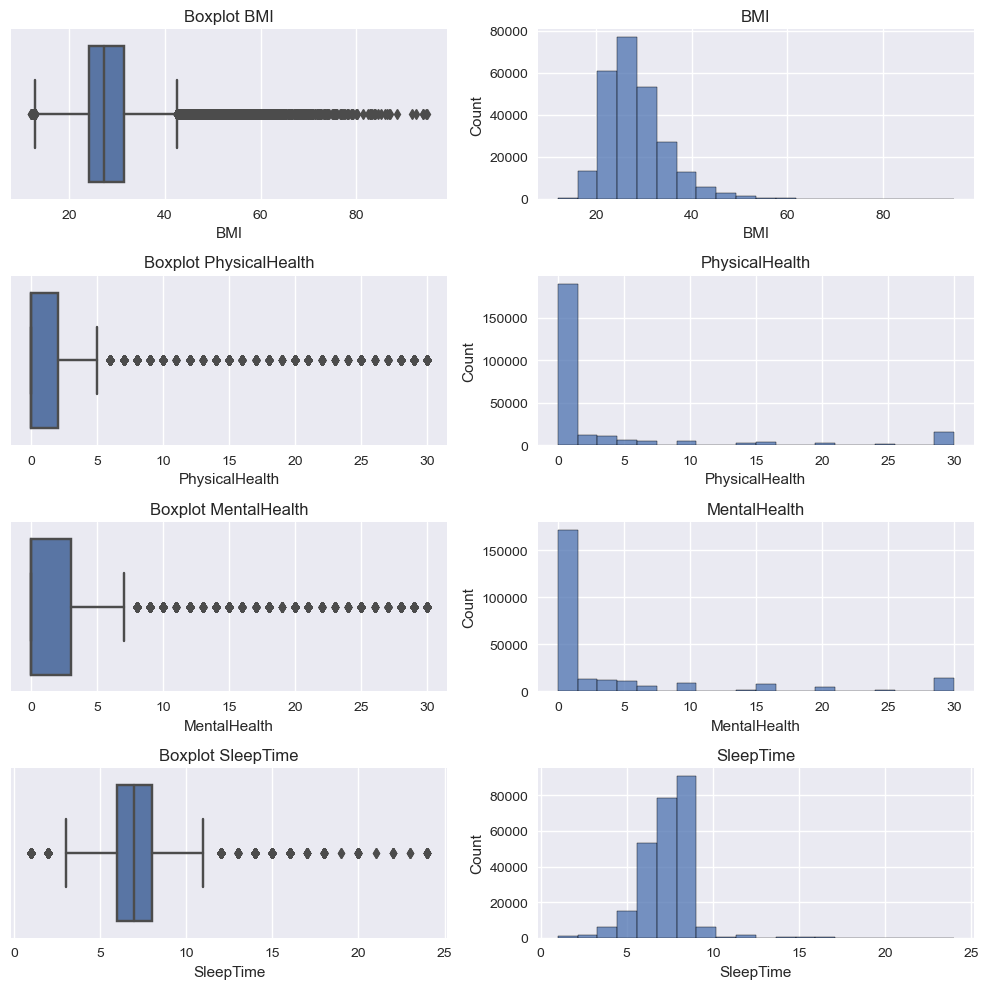

In [14]:
# crear subplots con 5 filas y 2 columnas
plt.style.use('seaborn-v0_8') 
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))

# aplanar la matriz de subplots para iterar más fácilmente
axes = axes.flatten()

# iterar por cada variable y crear un histograma y boxplot en el subplot correspondiente
for i, col in enumerate(train_data_preprocessed[numeric_cols].columns):
    ax = axes[i*2+1]
    sns.histplot(ax=ax, data=train_data_preprocessed[numeric_cols], x=col, bins=20)
    ax.set_title(col)
    
    ax = axes[i*2]
    sns.boxplot(ax=ax, data=train_data_preprocessed[numeric_cols], x=col, showfliers = True)
    ax.set_title("Boxplot " + col)

# ajustar el espacio entre los subplots y mostrar el gráfico
plt.tight_layout()
plt.show()

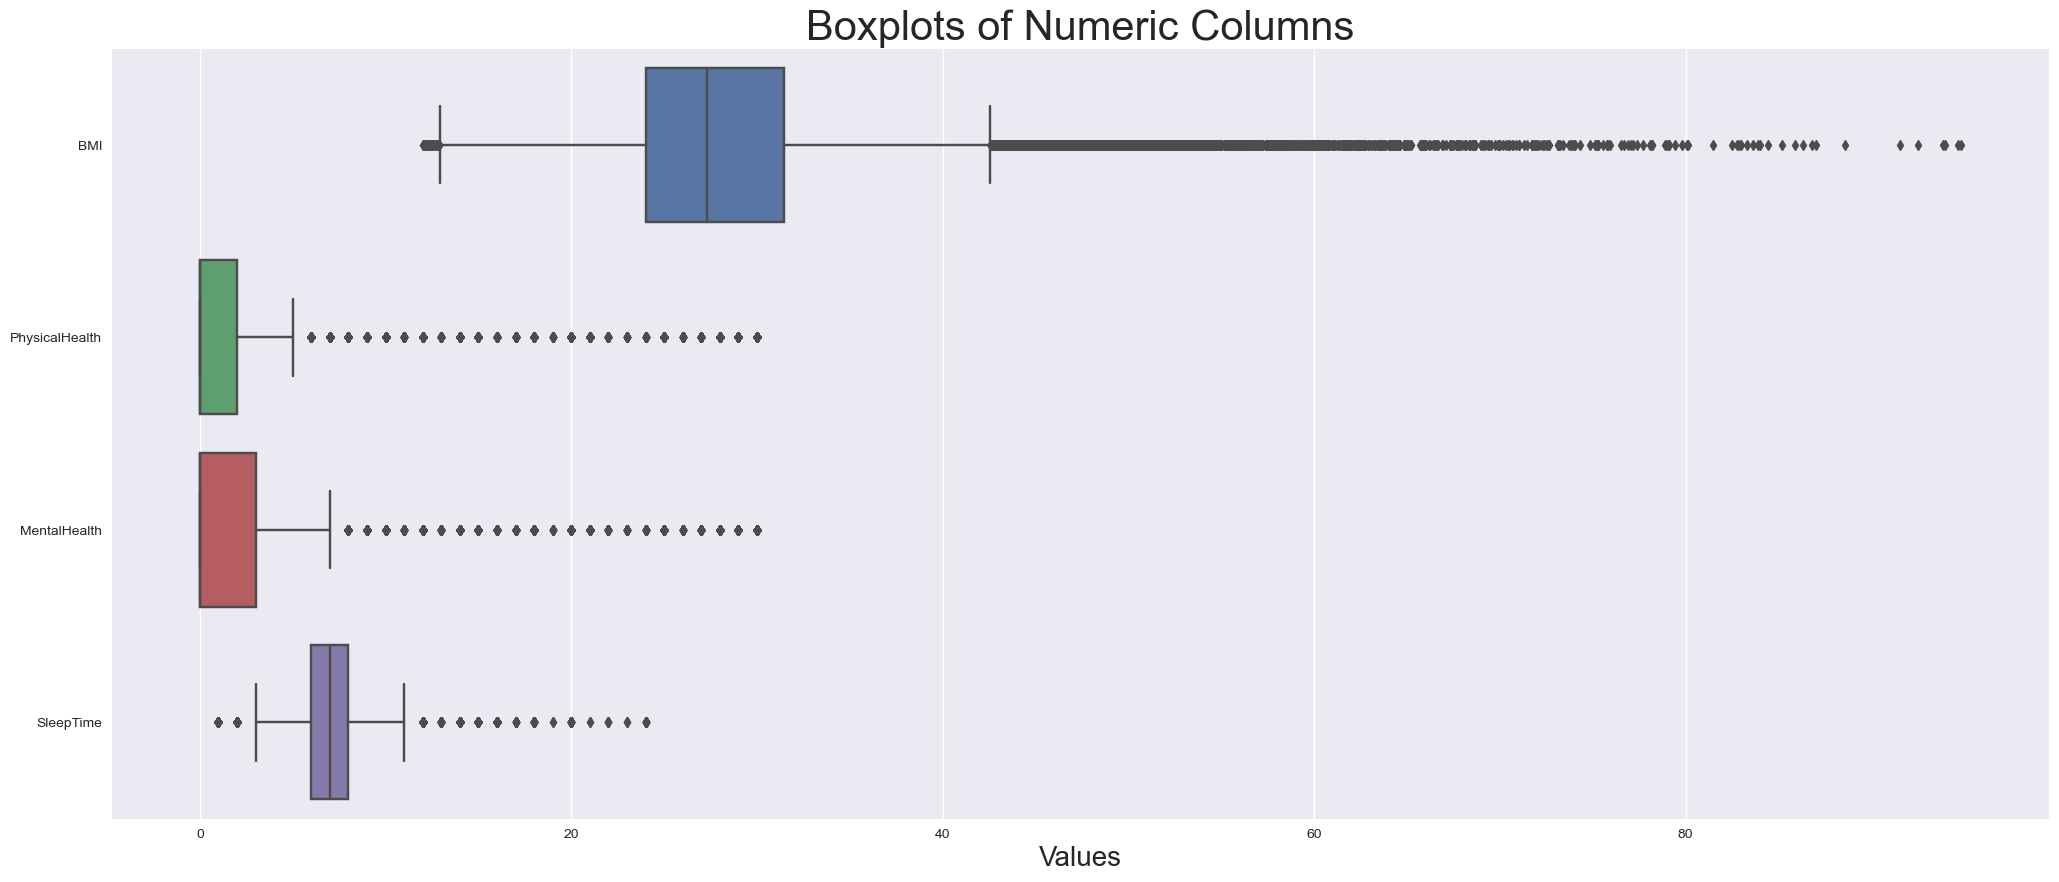

In [16]:
plt.style.use('seaborn-v0_8') 
# create a figure and axis object using Seaborn
fig, ax = plt.subplots(figsize=(25, 10))

# create a DataFrame with the numeric columns
df_numeric = train_data_preprocessed.select_dtypes(include=['number'])

# create a horizontal boxplot using Seaborn
sns.boxplot(data=df_numeric, orient='h', ax=ax)

# set the x-axis label
ax.set_xlabel("Values", fontsize=20)

# set the plot title
ax.set_title("Boxplots of Numeric Columns", fontsize=30)

# display the plot
plt.show()

### Distribución de las variables categóricas


**Variables binarias**

In [17]:
binary_features = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 
                'Stroke', 'DiffWalking', 'PhysicalActivity', 
                'Asthma', 'KidneyDisease', 'SkinCancer', 'Sex']

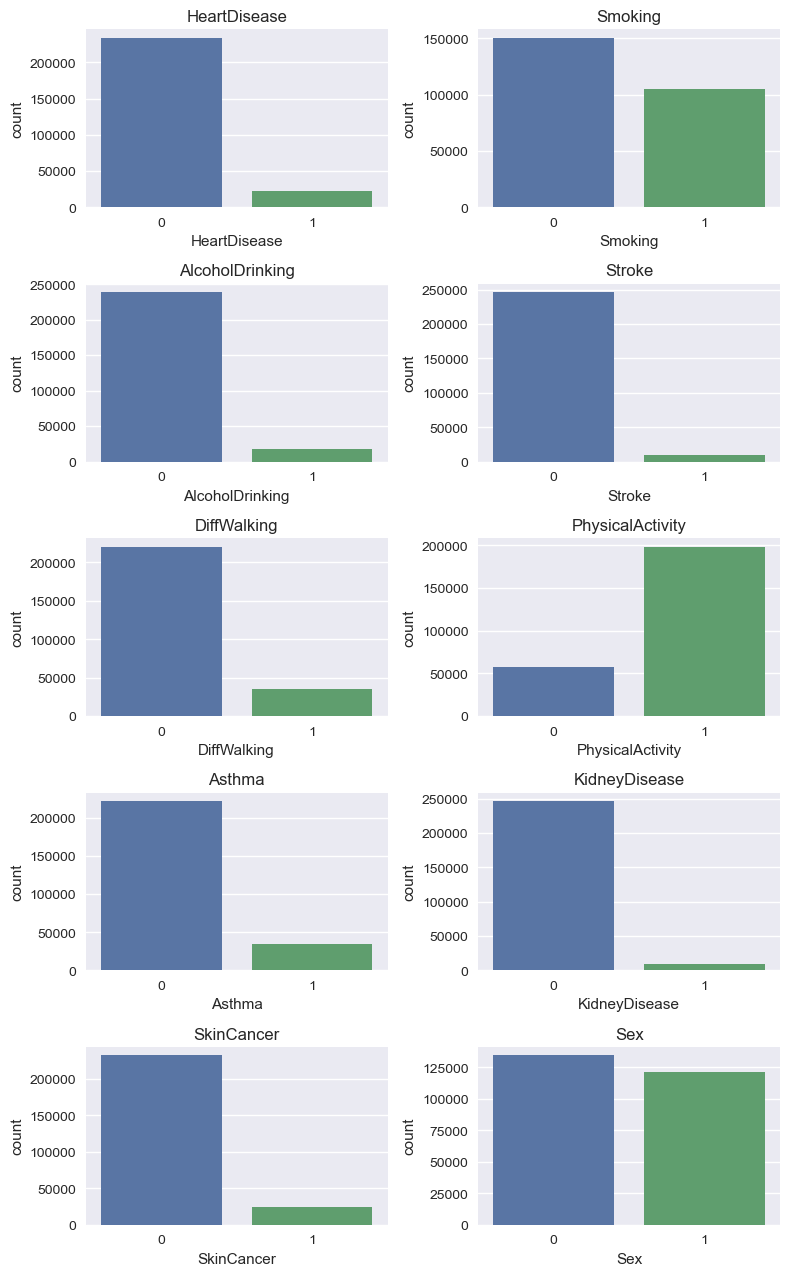

In [18]:
# Define the number of rows and columns for the subplot grid
num_plots = len(binary_features)
num_rows = 6
num_cols = 2

# Calculate the number of empty subplots to remove
num_empty_plots = num_rows * num_cols - num_plots

# Create the subplot grid and flatten it into a 1D array
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(8, 15))
axs = axs.flatten()

# Plot the data on each subplot
for i, feature in enumerate(binary_features):
    sns.countplot(data=train_data_preprocessed, x=feature, ax=axs[i]) 
    axs[i].set_title(feature)

# Remove the extra empty subplots
for i in range(num_plots, num_plots + num_empty_plots):
    fig.delaxes(axs[i])

# Adjust the spacing between the subplots and display the figure
plt.tight_layout()
plt.show()

**Variables categóricas no binarias**

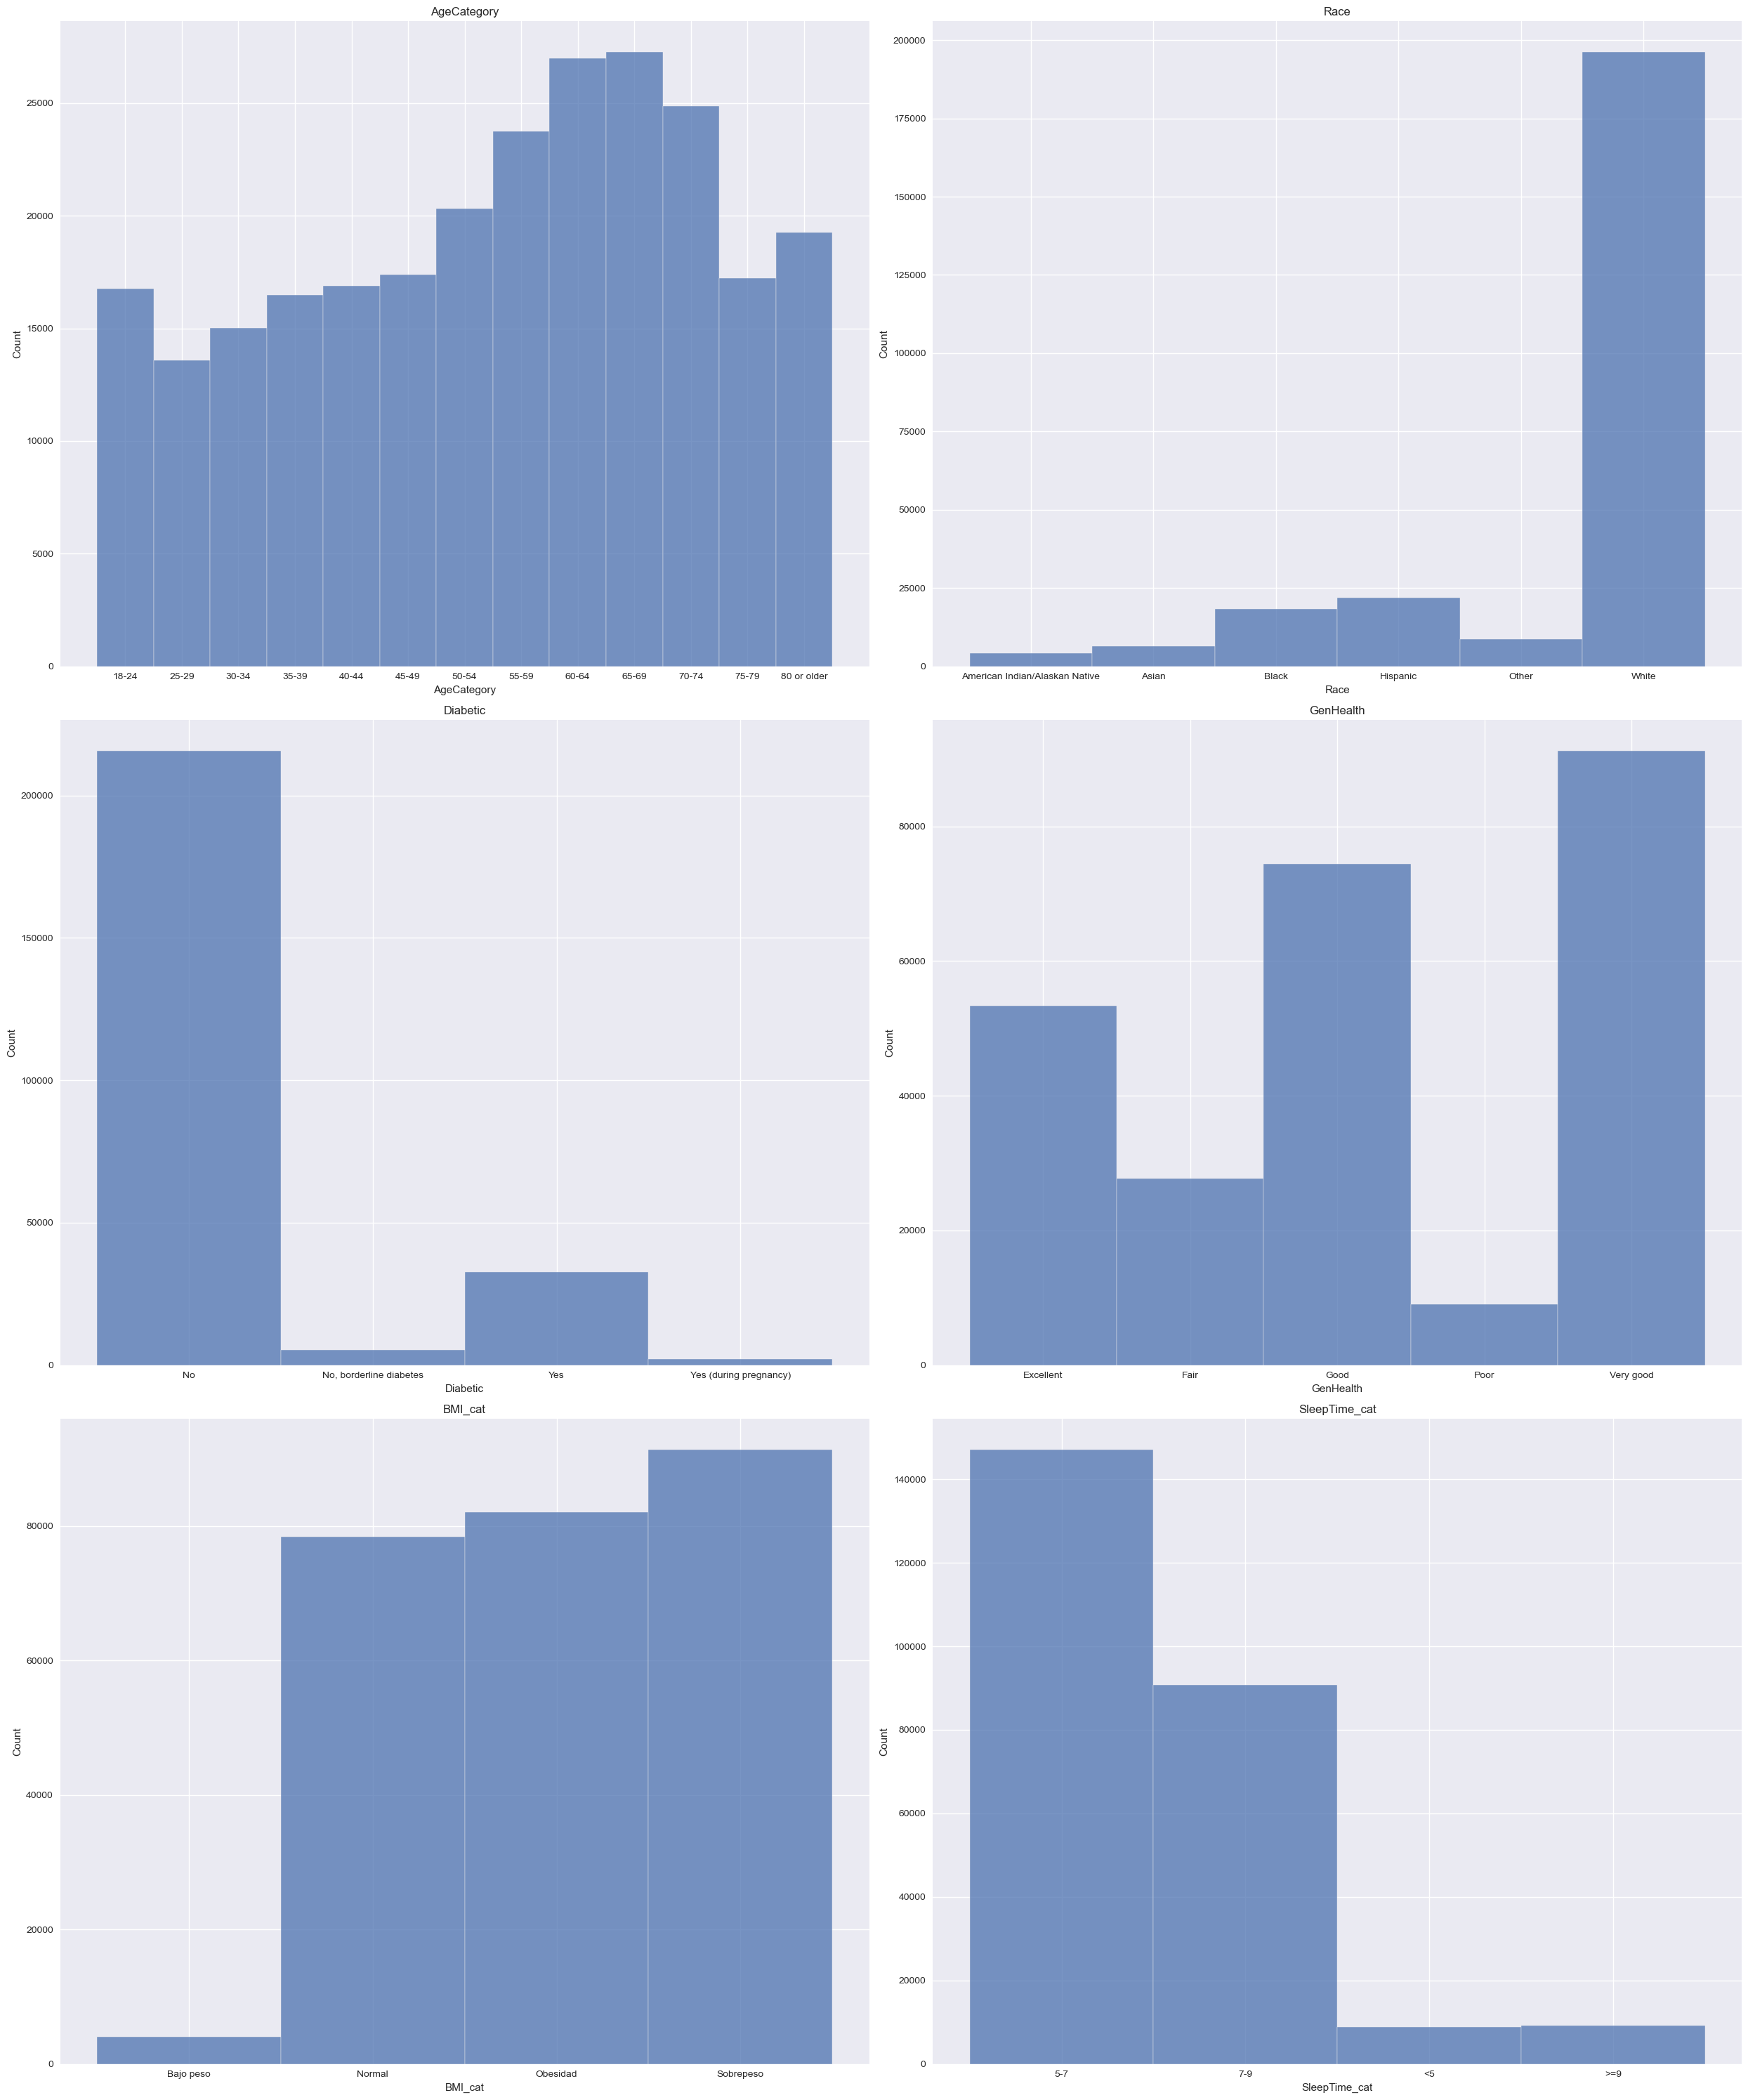

In [19]:
non_binary_cat_var = ['AgeCategory', 'Race', 'Diabetic', 
                      'GenHealth', 'BMI_cat', 'SleepTime_cat']

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(25, 30))
axs = axs.flatten()

for i, feature in enumerate(non_binary_cat_var):
    sns.histplot(data=train_data_preprocessed, x=feature, ax=axs[i], kde=False) 
    axs[i].set_title(feature)
    if feature in ['neighborhood', 'property_type']:
        axs[i].tick_params(axis='x', labelrotation=90)


plt.tight_layout()
plt.show()

## Relación entre las variables y la variable objetivo


### Variables numéricas vs variable objetivo

**Box plots**

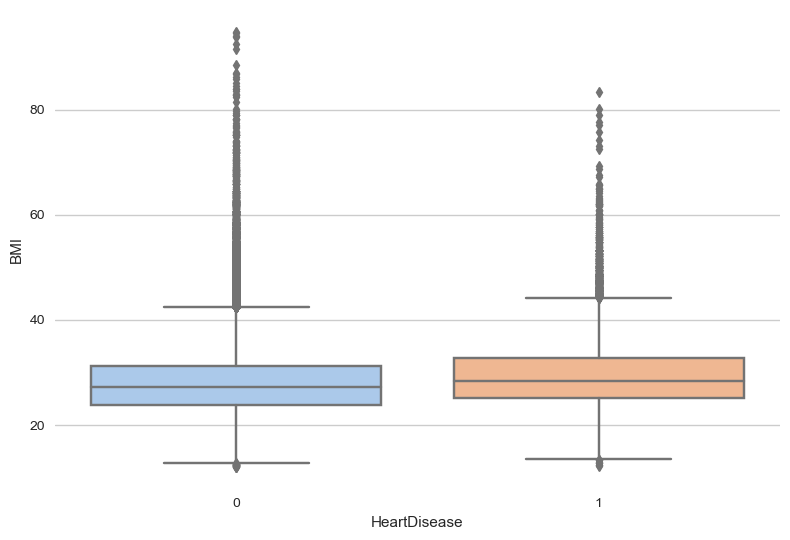

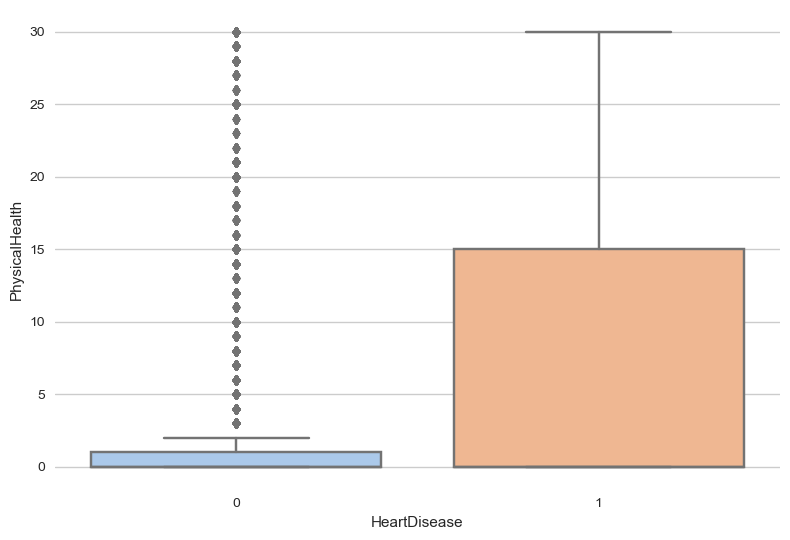

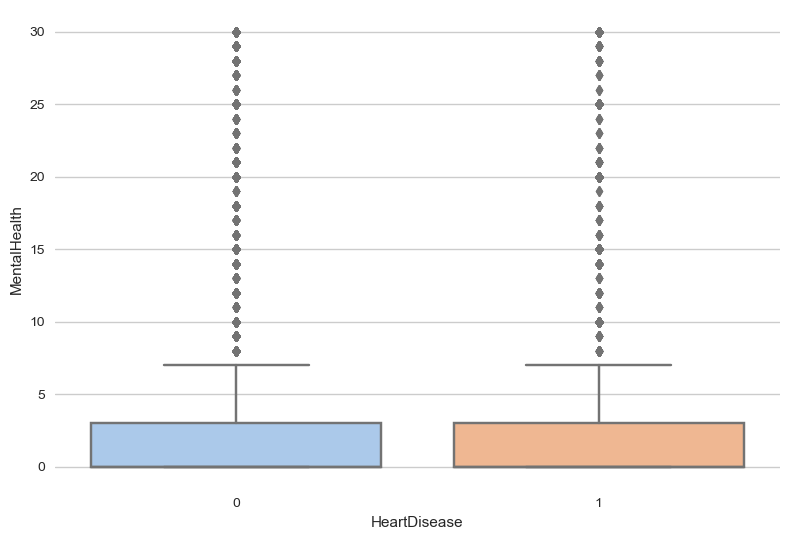

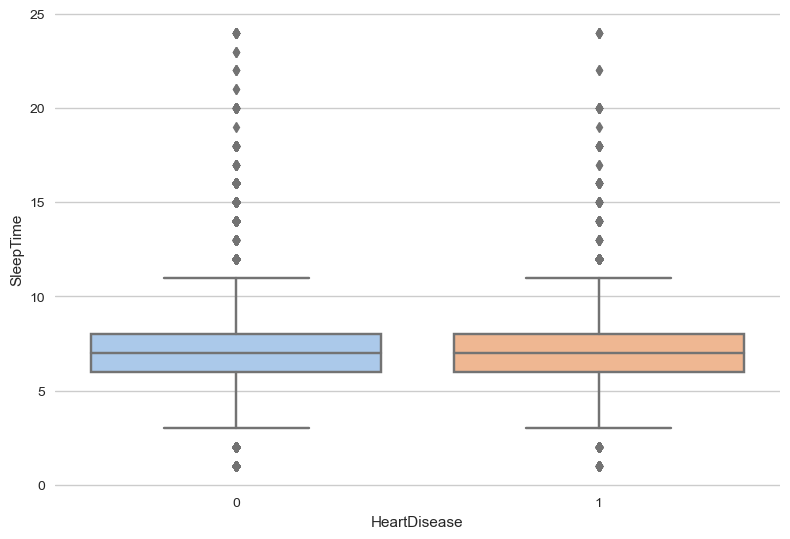

In [20]:
# Lista de columnas numéricas
# Configuración de los gráficos
sns.set_style('whitegrid')
sns.set_palette('pastel')

for i, feature in enumerate(numeric_cols):
    sns.boxplot(data=train_data_preprocessed, x=TARGET_VARIABLE, y=feature)
    plt.xticks(fontsize=10) # Tamaño de las etiquetas del eje X
    plt.yticks(fontsize=10) # Tamaño de las etiquetas del eje Y
    plt.tight_layout()
    plt.show()

**Violin plots**

In [21]:
def create_violinplots(df: pd.DataFrame, 
                       cat_cols: List[str], 
                       target_var: str, 
                       plot_width: int = 8, 
                       plot_height: int = 6) -> None:
    """
    Creates violin plots for the target variable across categorical variables in the given pandas DataFrame.

    Args:
        df (pd.DataFrame): The pandas DataFrame containing the data.
        cat_cols (List[str]): A list of the names of the categorical columns.
        target_var (str): The name of the target variable.
        plot_width (int): The width of the plot in inches. Default is 8.
        plot_height (int): The height of the plot in inches. Default is 6.


    Returns:
        None.
    """
    for col in cat_cols:
        #  if num_categories is greater than 10, the x-axis label rotation is set to 90 degrees, otherwise it is set to 0.
        num_categories = len(df[col].unique())
        if num_categories > 10:
            x_label_rotation = 90
        else: 
            x_label_rotation = 0    
            
        fig, ax = plt.subplots(figsize=(plot_width, plot_height))
        sns.violinplot(x=col, y=target_var, data=df, ax=ax)
        # show individual points
        sns.stripplot(x=col, y=target_var, data=df, jitter=False, color='black', size=4, alpha=0.5)
        # visualize the mean value on the violin plot
        sns.pointplot(x=target_var, y=col, data=df, color='red', ax=ax, errorbar=None)
        plt.title(f"Distribution of {target_var} by {col}")
        plt.xlabel(col)
        plt.ylabel(target_var)
        
        if x_label_rotation != 0:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=x_label_rotation)
        sns.despine()
        plt.show()

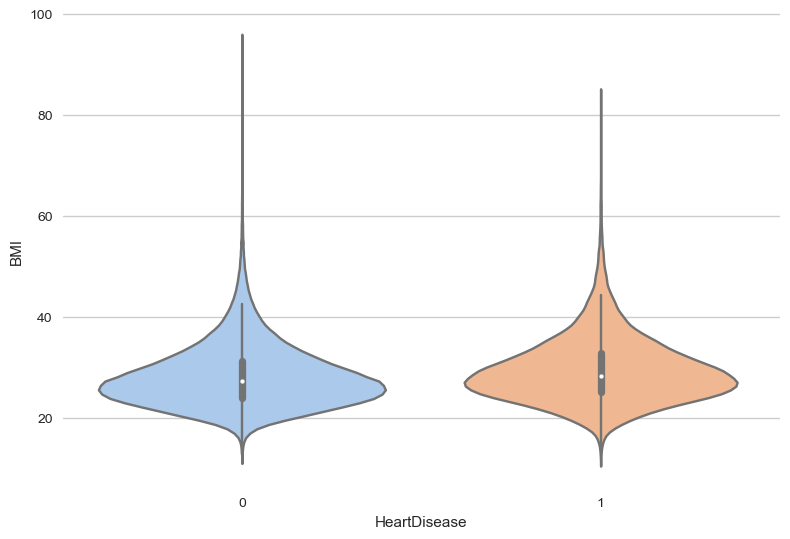

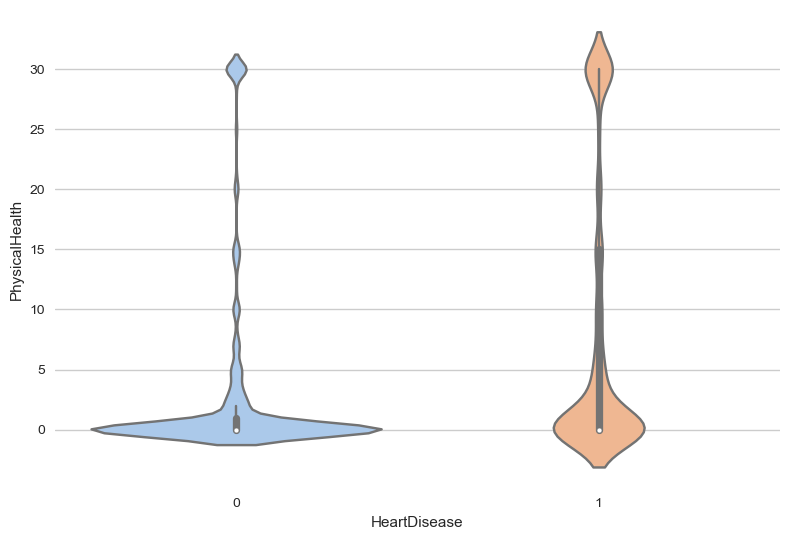

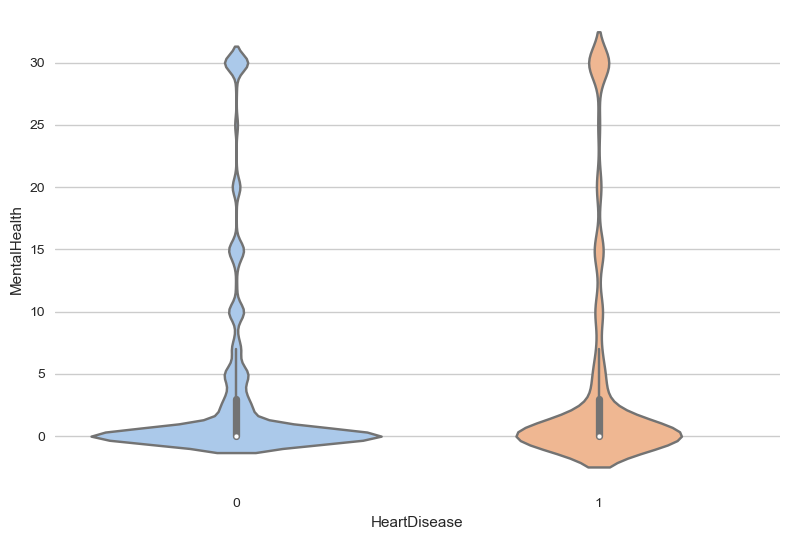

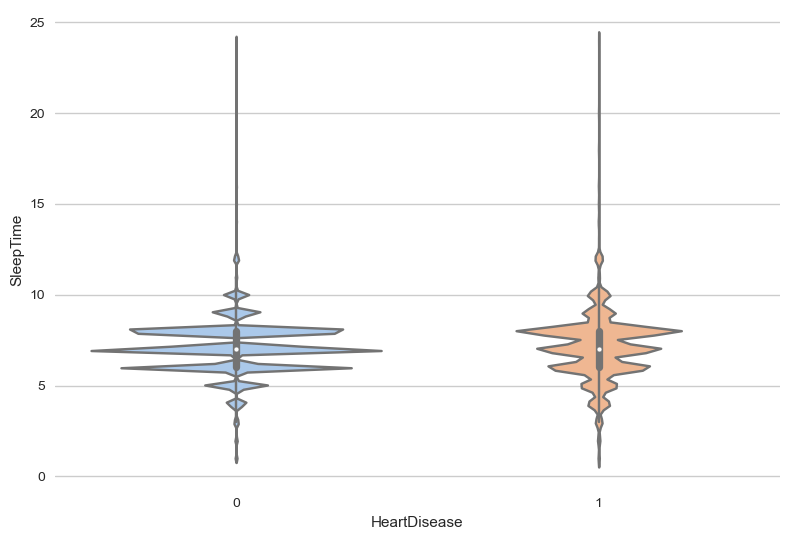

In [22]:
# Configuración de los gráficos
sns.set_style('whitegrid')
sns.set_palette('pastel')

for i, feature in enumerate(numeric_cols):
    sns.violinplot(data=train_data_preprocessed, x=TARGET_VARIABLE, y=feature)
    plt.xticks(fontsize=10) # Tamaño de las etiquetas del eje X
    plt.yticks(fontsize=10) # Tamaño de las etiquetas del eje Y
    plt.tight_layout()
    plt.show()

### Variables categóricas vs variable objetivo

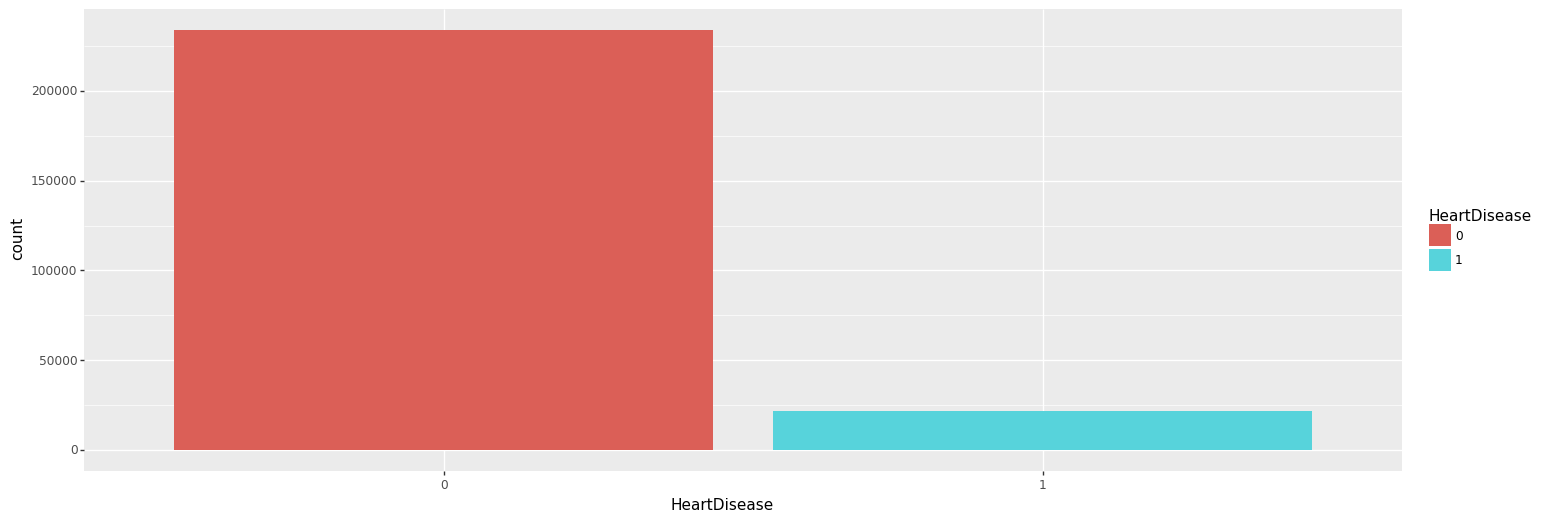

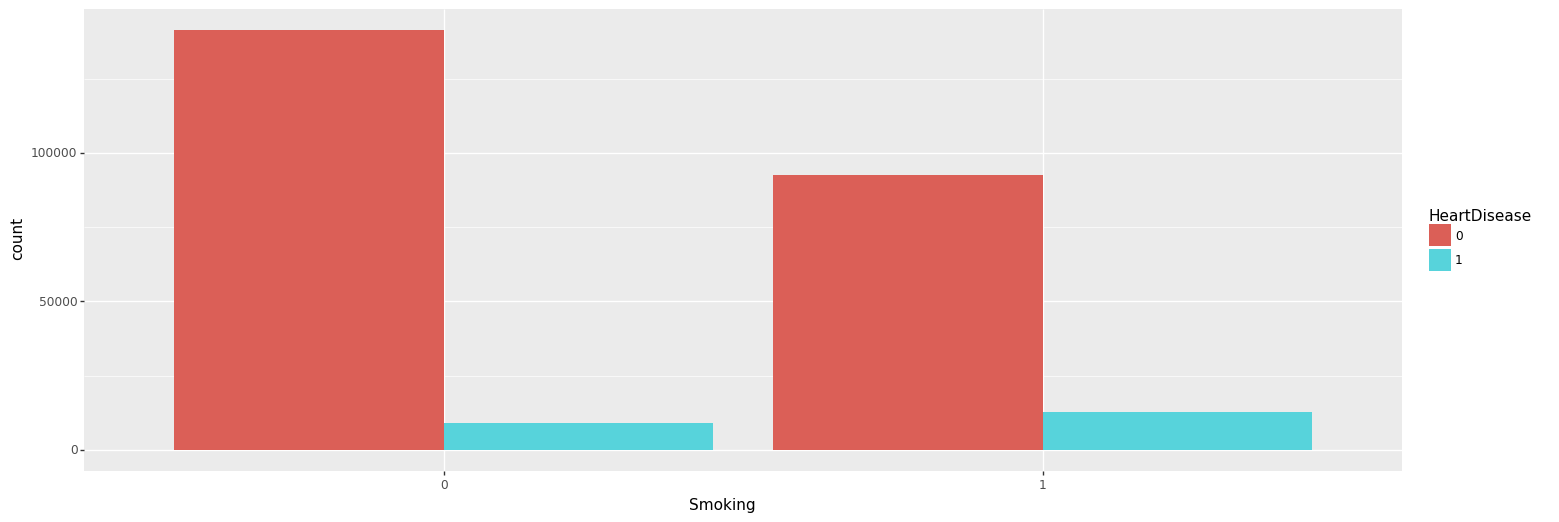

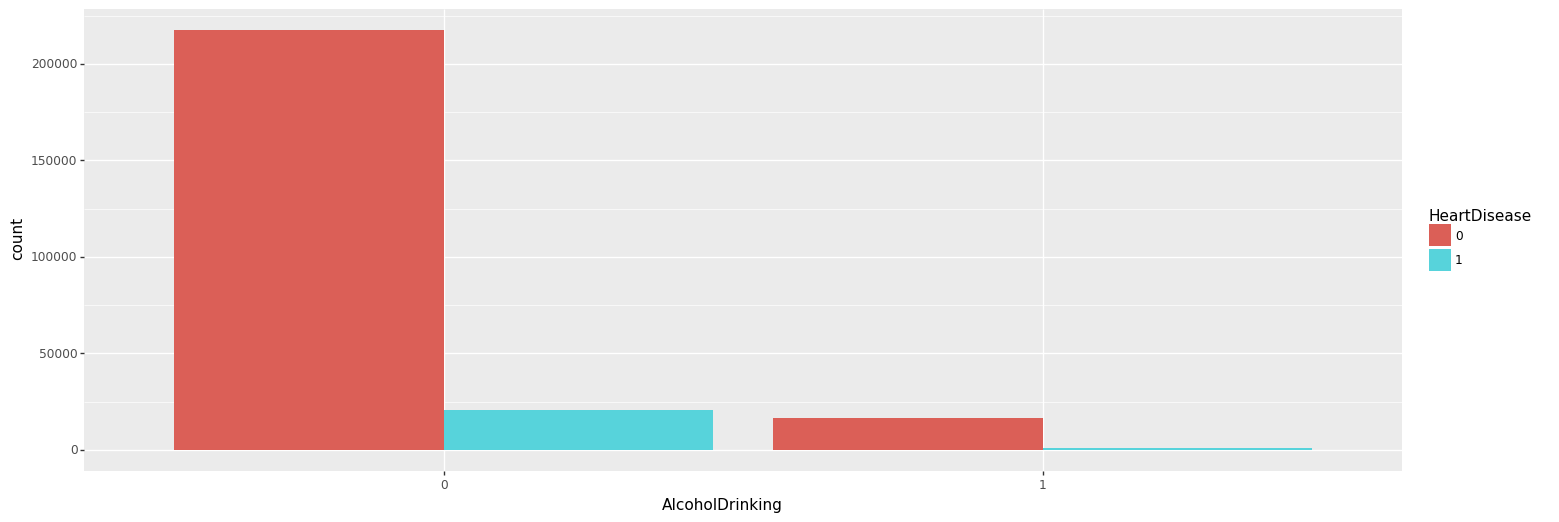

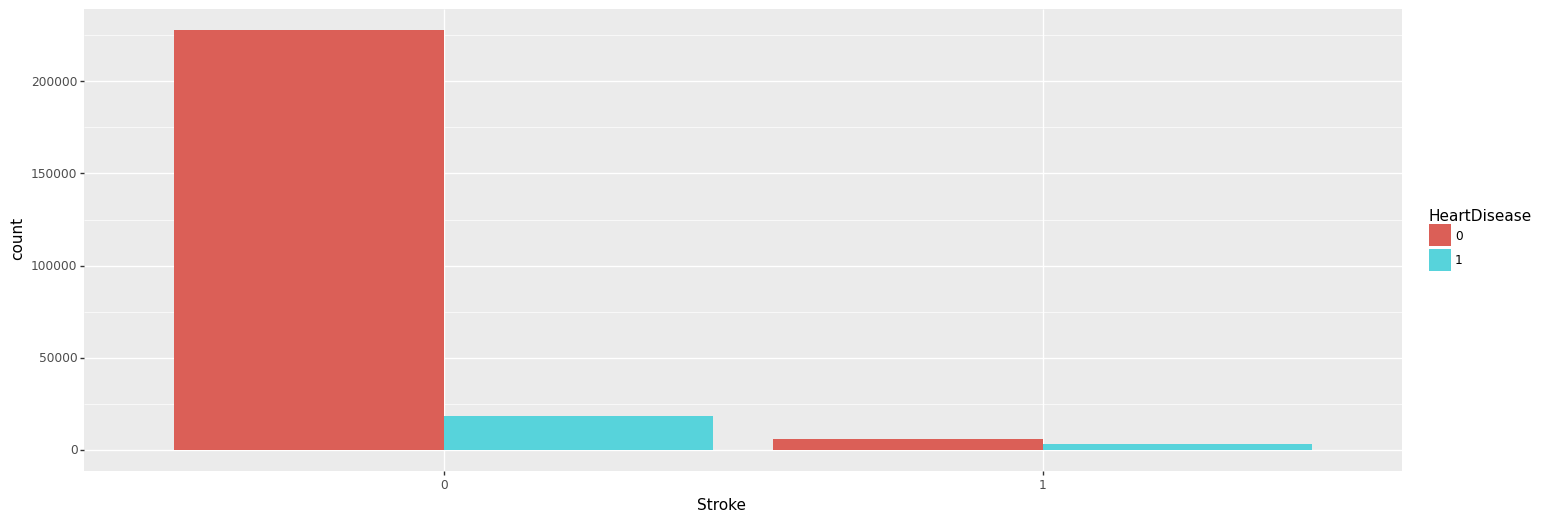

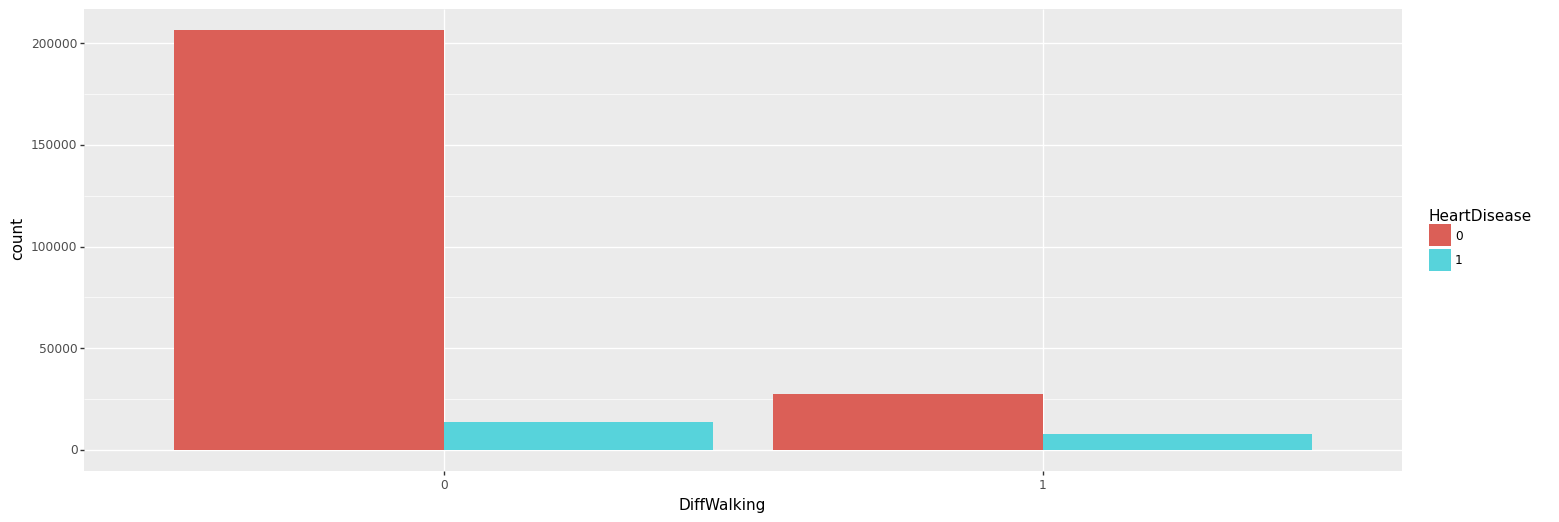

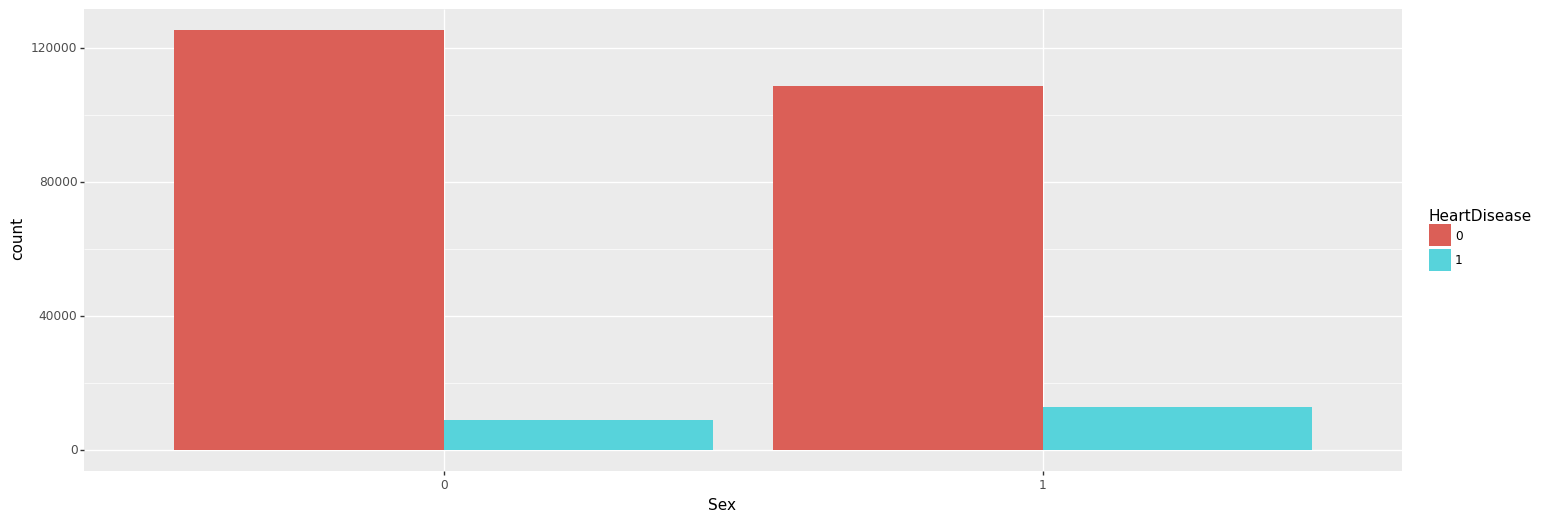

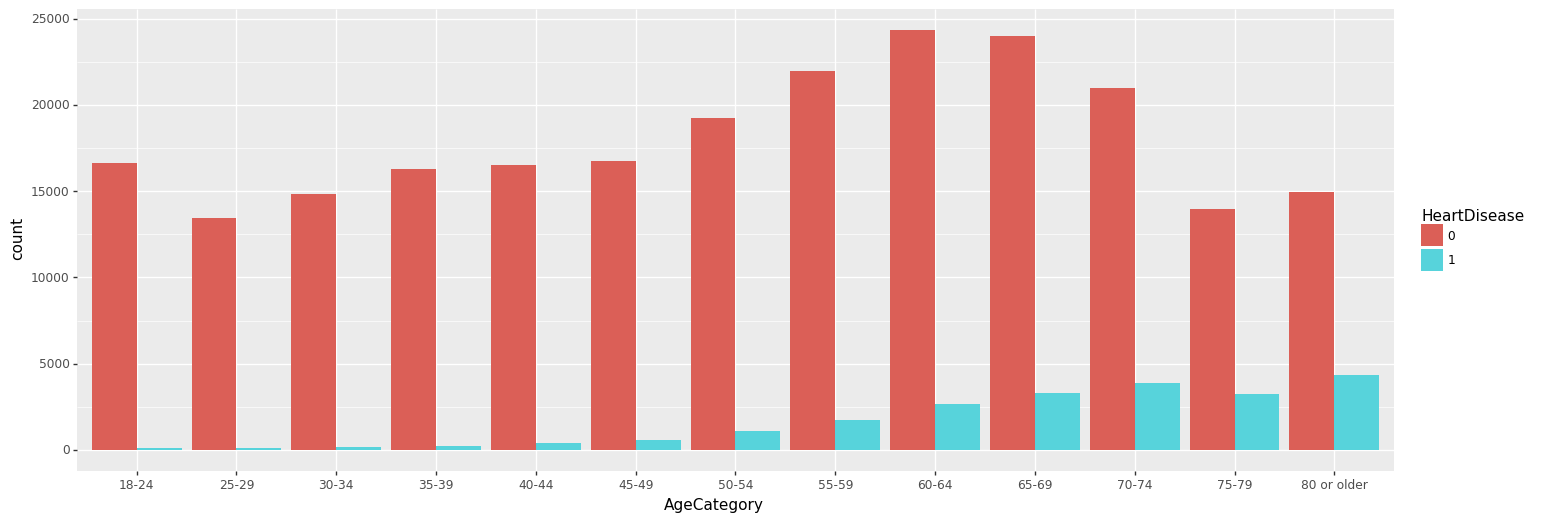

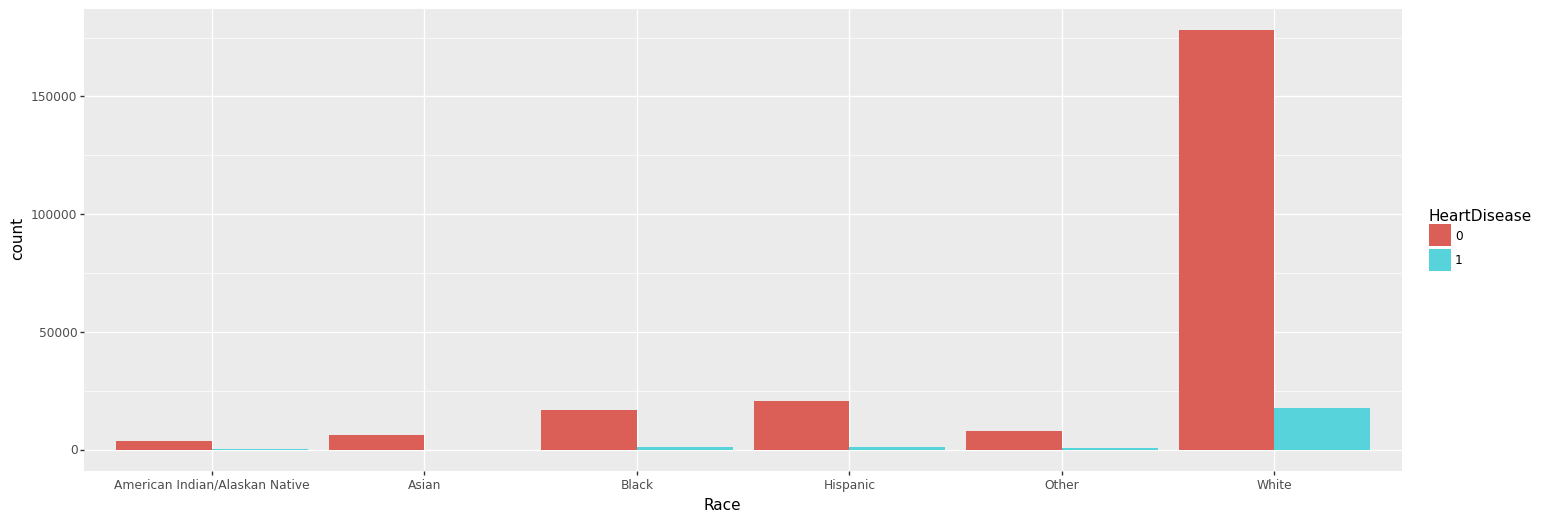

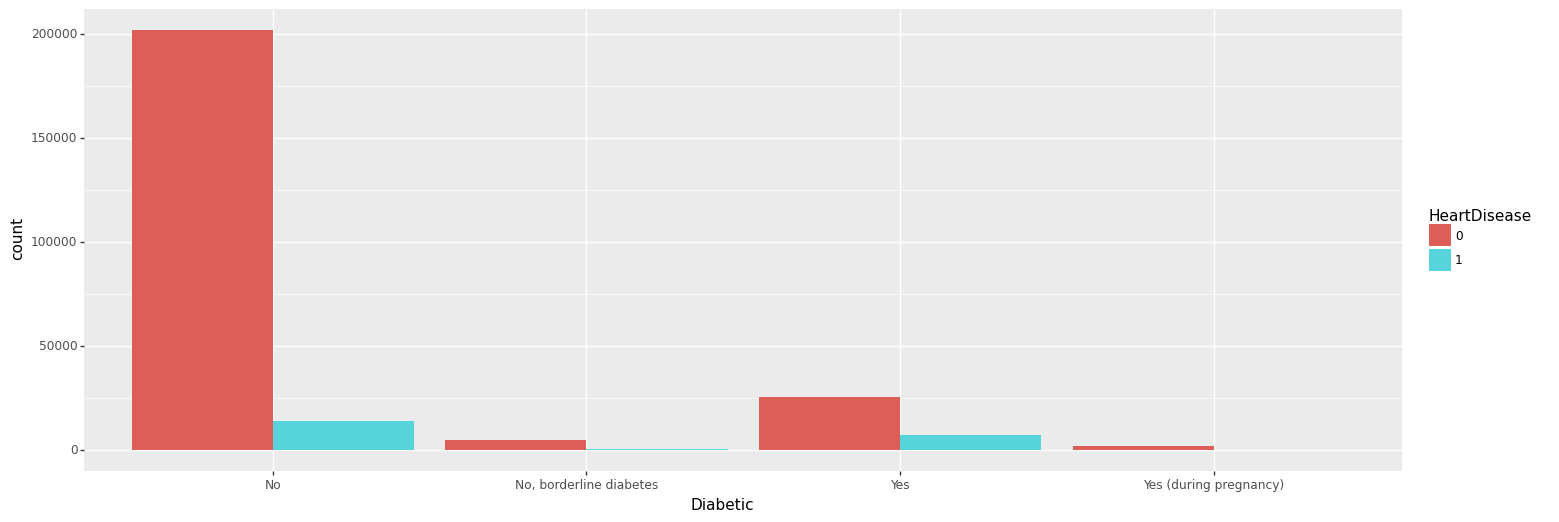

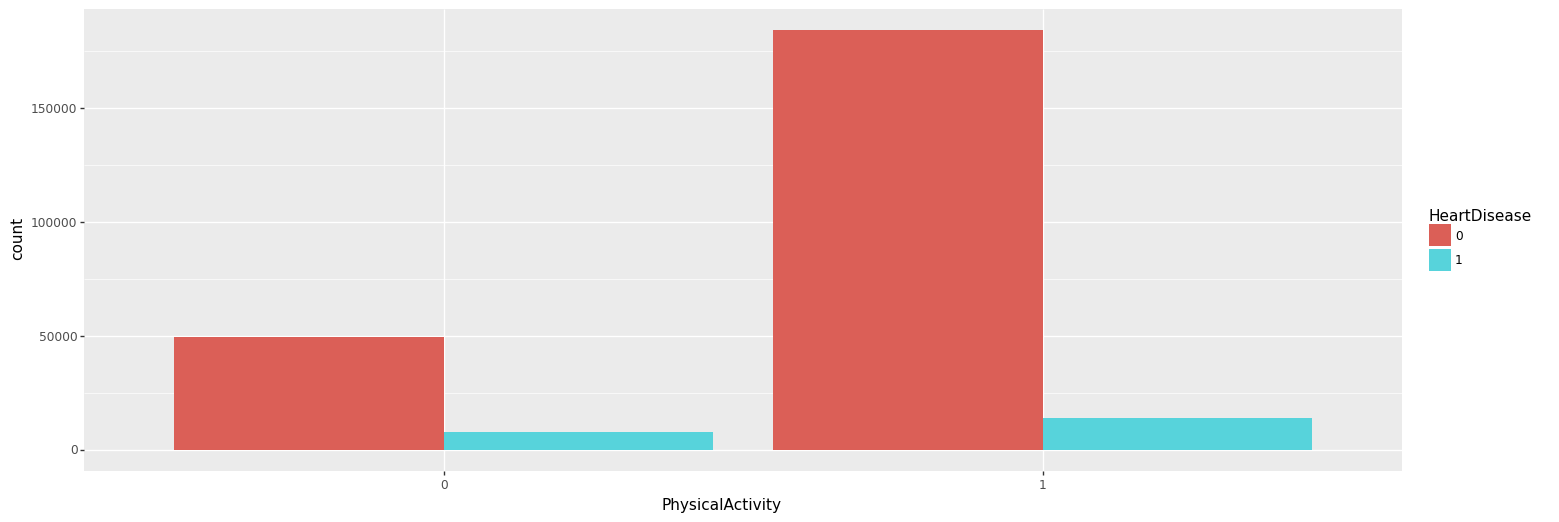

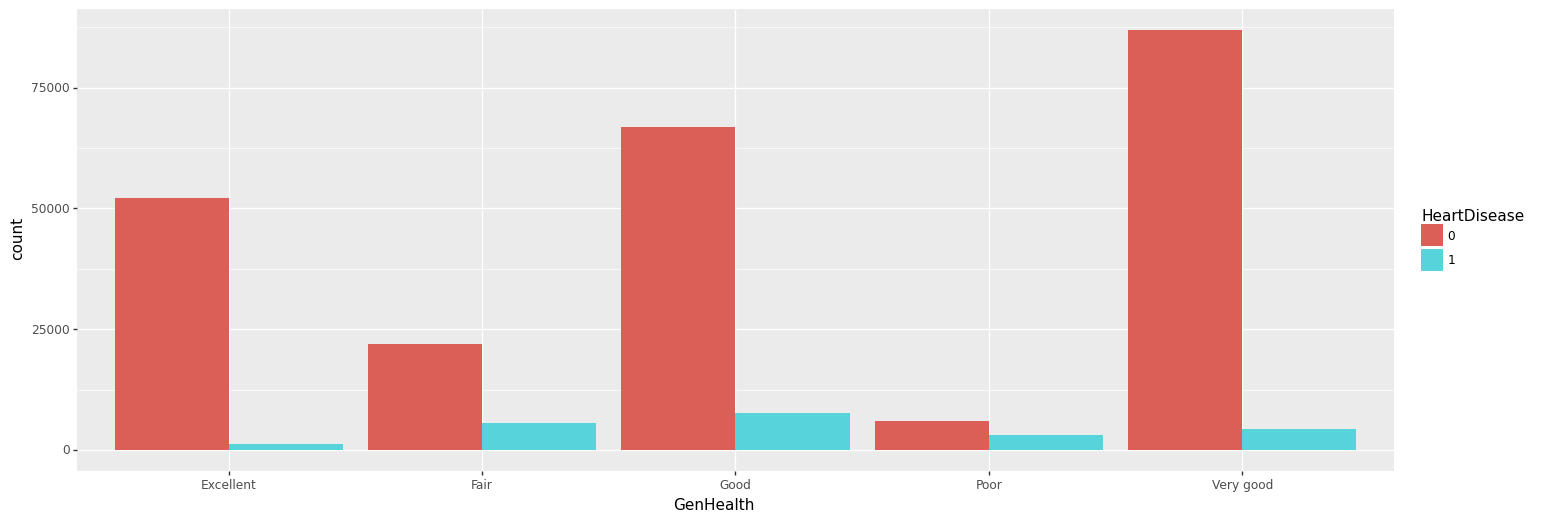

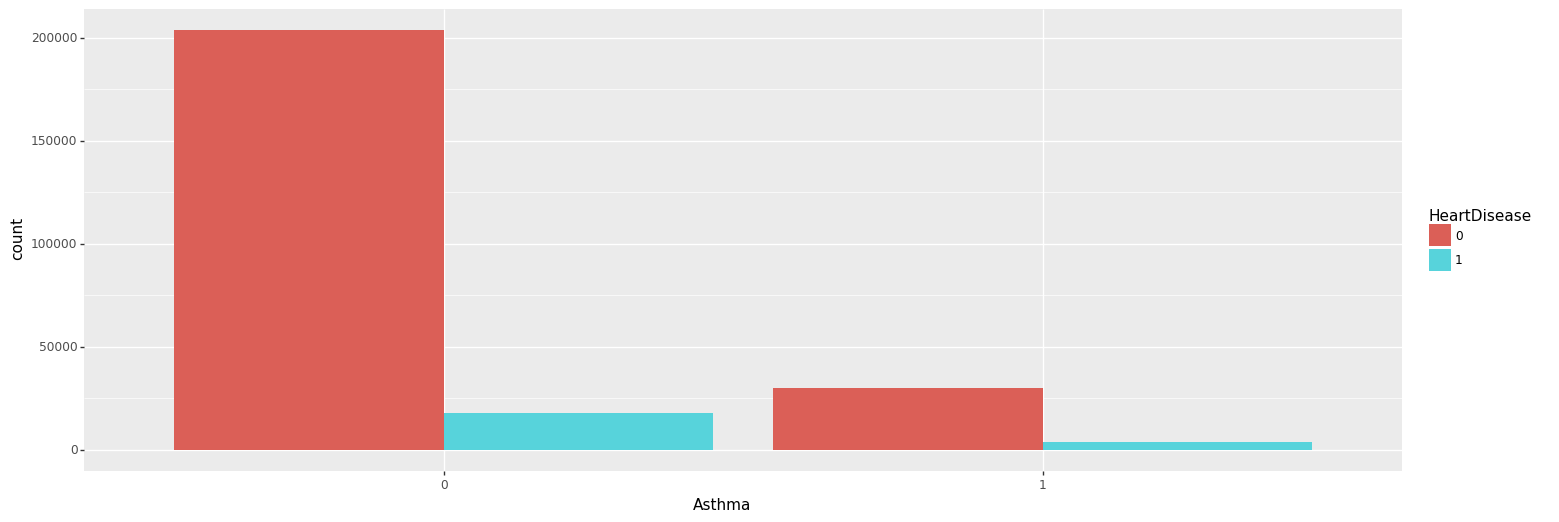

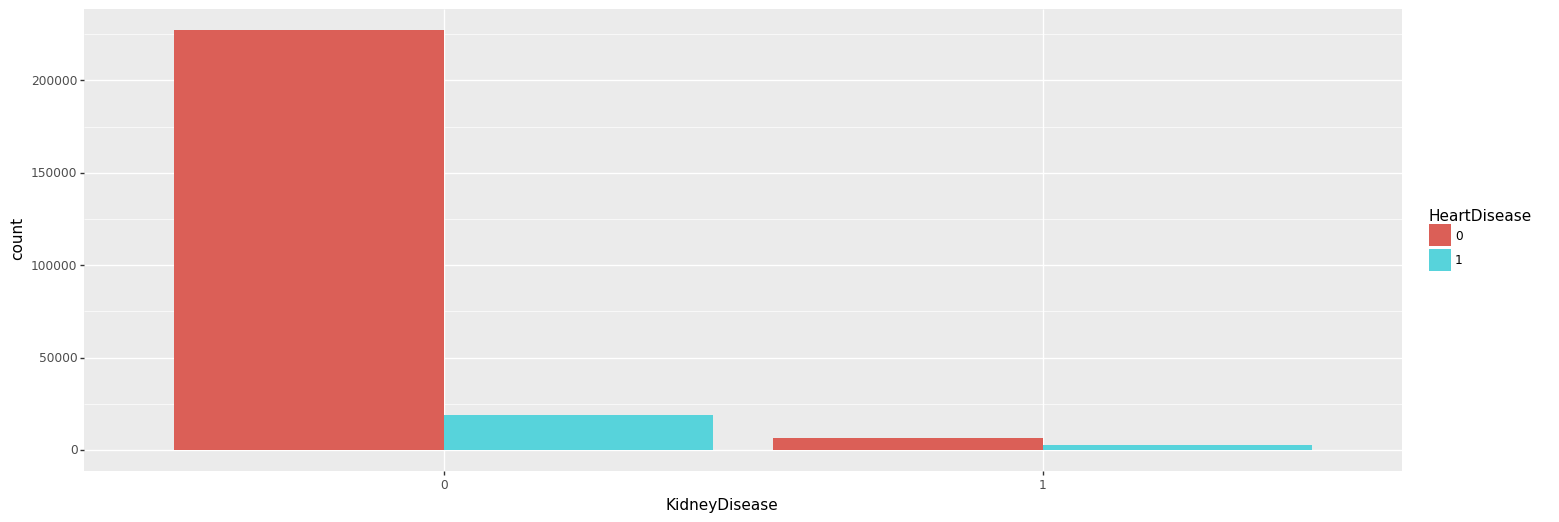

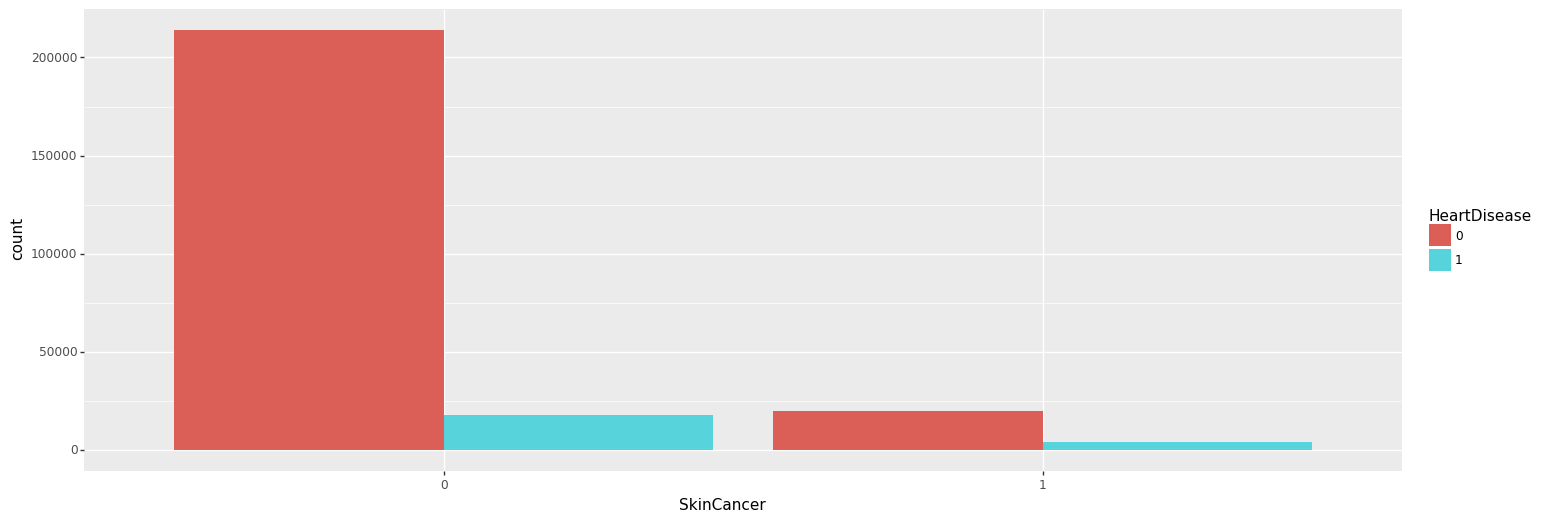

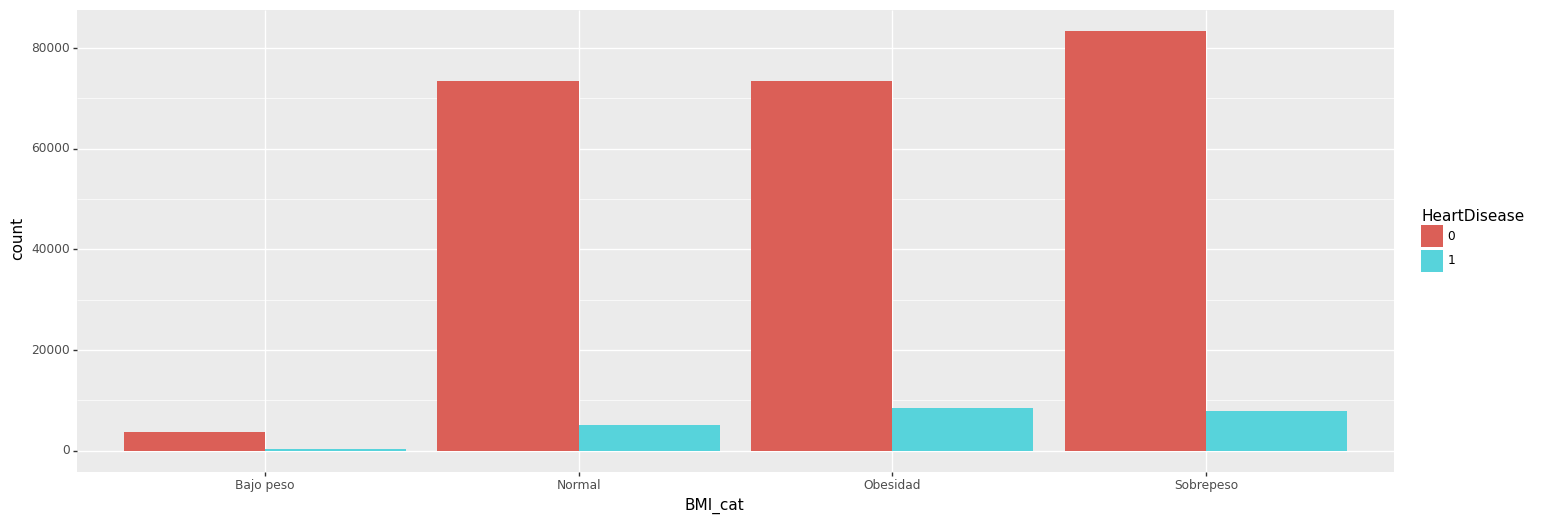

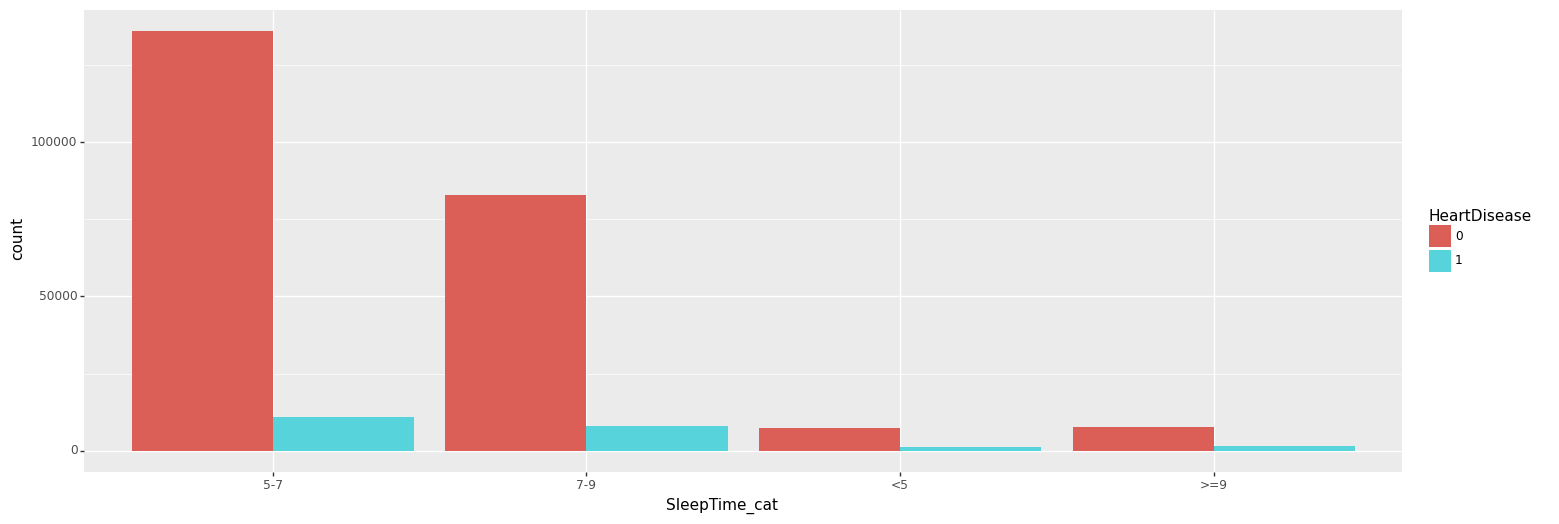

In [23]:
# Configuración de los gráficos
sns.set_style('whitegrid')
sns.set_palette('pastel')
# set the size of the plot
plot_size = (17, 6)

for i, feature in enumerate(categoric_cols):
    plot = ggplot(train_data_preprocessed, aes(x=feature, fill=TARGET_VARIABLE)) + \
    geom_bar(position='dodge') + \
    labs(x=feature, fill=TARGET_VARIABLE)+ \
    theme(figure_size=plot_size)

    plot.draw()

## Correlation Analysis

In [24]:
def calculate_correlation(df: pd.DataFrame, method: str, figsize: tuple = (6, 4)) -> pd.DataFrame:
    """
    Calculates the correlation matrix between numeric features in a pandas DataFrame using a specified correlation method.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to calculate the correlation matrix for.
    method (str): The correlation method to use. Valid options are 'pearson', 'spearman', and 'kendall'.
    figsize (tuple): The size of the heatmap plot. Default is (6, 4).
    
    Returns:
    pd.DataFrame: The correlation matrix between numeric features in the DataFrame.
    """
    # select only the numeric features
    numeric_features = df.select_dtypes(include=['int64', 'float64'])
    X = numeric_features
    
    # scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # calculate correlation matrix
    if method == 'pearson':
        corr_matrix = pd.DataFrame(X_scaled).corr(method='pearson')
    elif method == 'spearman':
        corr_matrix = pd.DataFrame(X_scaled).corr(method='spearman')
    elif method == 'kendall':
        corr_matrix = pd.DataFrame(X_scaled).corr(method='kendall')
    else:
        raise ValueError("Invalid correlation method specified. Valid options are 'pearson', 'spearman', and 'kendall'.")
    
    # set column names of correlation matrix
    corr_matrix.columns = numeric_features.columns
    corr_matrix.index = numeric_features.columns
    
    # plot heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title(f"Correlation Matrix ({method.capitalize()})")
    plt.show()
    
    return corr_matrix

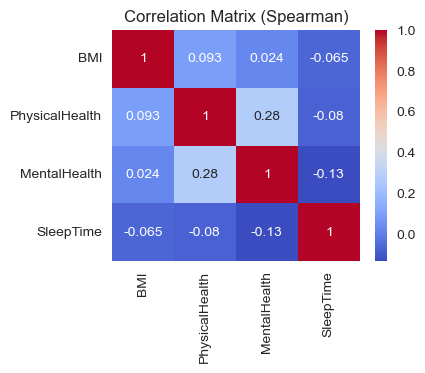

BMI  PhysicalHealth  MentalHealth  SleepTime
BMI             1.000000        0.093044      0.023767  -0.064952
PhysicalHealth  0.093044        1.000000      0.276487  -0.080109
MentalHealth    0.023767        0.276487      1.000000  -0.133738
SleepTime      -0.064952       -0.080109     -0.133738   1.000000

In [25]:
calculate_correlation(train_data_preprocessed, method="spearman", figsize= (4,3)) # spearman used because not all data is normalized

In [29]:
def plot_corr_barchart(df1: pd.DataFrame, target: str,  n: int = 10) -> None:
    """
    Plots a color-gradient bar chart showing top n correlations between features
    Args:
        df1 (pd.DataFrame): the dataframe to plot
        n (int): number of top n correlations to plot
    Returns:
        None
    Sources: 
    https://typefully.com/levikul09/j6qzwR0
    https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
    """
    print(f"Correlation between numeric features (excluding the target variable: {target})\n")

    # drop target
    df1 = df1.drop(columns=target)

    # select only the numeric features
    useful_columns =  df1.select_dtypes(include=['int64', 'float64']).columns

    def get_redundant_pairs(df):
        pairs_to_drop = set()
        cols = df.columns
        for i in range(0,df.shape[1]):
            for j in range(0,i+1):
                pairs_to_drop.add((cols[i],cols[j]))
        return pairs_to_drop

    def get_correlations(df,n=n):
        au_corr = df.corr(method = 'spearman').unstack() # spearman used because not all data is normalized
        labels_to_drop = get_redundant_pairs(df)
        au_corr = au_corr.drop(labels = labels_to_drop).sort_values(ascending=False)
        top_n = au_corr[0:n]    
        bottom_n =  au_corr[-n:]
        top_corr = pd.concat([top_n, bottom_n])
        return top_corr

    corrplot = get_correlations(df1[useful_columns])


    fig, ax = plt.subplots(figsize=(20,15))
    norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax =1)
    colors = [plt.cm.RdYlGn(norm(c)) for c in corrplot.values]
    
    # n*(n-1)/2-->  maximum value of "n" for which there are no repeated correlations
    # n = number of numerical variables = len(useful_columns)
    num_corr = (len(useful_columns)*(len(useful_columns)-1)/2)
    print(f"Max number of correlations (n): {num_corr/2}\n")
    
    print(corrplot)

    corrplot.plot.barh(color=colors)

Correlation between numeric features (excluding the target variable: HeartDisease)

Max number of correlations (n): 3.0

PhysicalHealth  MentalHealth      0.276487
BMI             PhysicalHealth    0.093044
                MentalHealth      0.023767
                SleepTime        -0.064952
PhysicalHealth  SleepTime        -0.080109
MentalHealth    SleepTime        -0.133738
dtype: float64


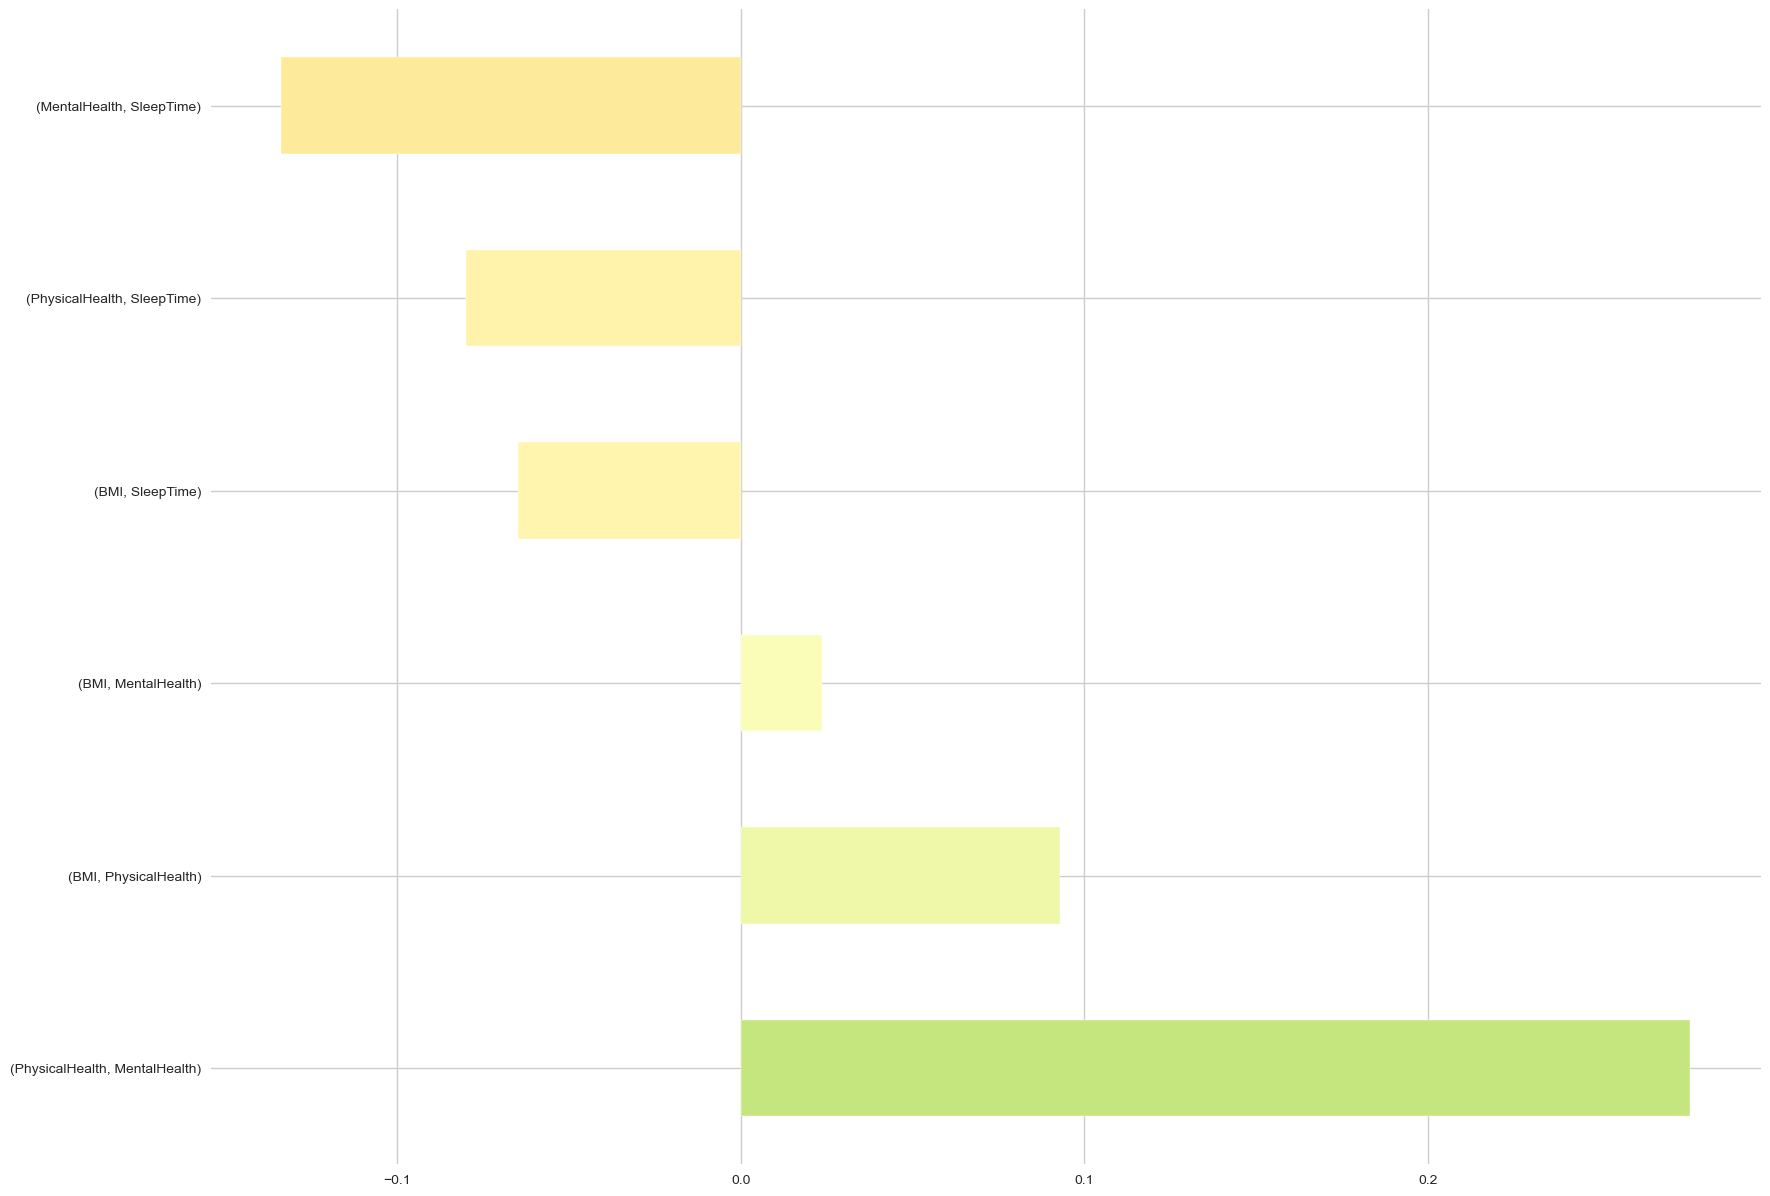

In [27]:
# correlación entre las variables numéricas (excluyendo la variable objetivo)
plot_corr_barchart(train_data_preprocessed, target = TARGET_VARIABLE, n=3) # spearman used because not all data is normalized

In [28]:
def plot_corr_vs_target(df1: pd.DataFrame, target: str, n: int) -> None:
    """
    Plots a color-gradient bar chart showing top n correlations between features and target
    Args:
        target (str): the name of the target column
        df1 (pd.DataFrame): the dataframe to plot
        n (int): number of top n correlations to plot
    Returns:
        None
    """
    print(f"Correlation between numeric features and the target variable {target}\n")

    # select the number of numeric features
    useful_columns =  len(df1.select_dtypes(include=['int64', 'float64']).columns)
    print(f"Max number of correlations (n): {useful_columns/2}\n")
    
    target_series = df1[target]
    
    x = df1.corrwith(target_series, method = 'spearman', numeric_only=True).sort_values(ascending=False)
    top_n = x[0:n]    
    bottom_n =  x[-n:]
    top_corr = pd.concat([top_n, bottom_n])
    x = top_corr
    print(x)

    fig, ax = plt.subplots(figsize=(8,4))
    norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax =1)
    colors = [plt.cm.RdYlGn(norm(c)) for c in x.values]
    x.plot.barh(color=colors)

Correlation between numeric features and the target variable HeartDisease

Max number of correlations (n): 2.0

PhysicalHealth    0.142302
BMI               0.059131
SleepTime         0.007706
MentalHealth     -0.004336
dtype: float64


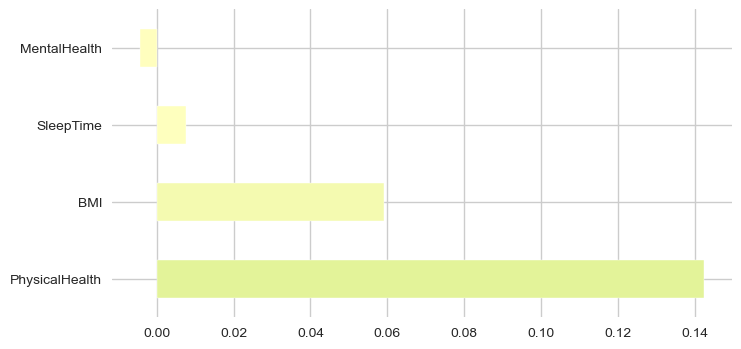

In [29]:
# Correlación entre las variables numéricas y la variable objetivo
plot_corr_vs_target(train_data_preprocessed, target = TARGET_VARIABLE, n=2) # spearman used because not all data is normalized

## ANOVA

In [30]:
def apply_anova():
    for column in numeric_cols:
        mod = ols( column + ' ~ ' + TARGET_VARIABLE, data=train_data_preprocessed).fit()
        aov_table = sm.stats.anova_lm(mod, typ=2)

        if aov_table['PR(>F)'][0] < 0.05:
            print( column + " is relevant with a p-value of " + str(aov_table['PR(>F)'][0]))
        else:
            print( column + " is NOT relevant with a p-value of " + str(aov_table['PR(>F)'][0]))

        print(aov_table)

apply_anova()

BMI is relevant with a p-value of 3.208236525077044e-161
                    sum_sq        df           F         PR(>F)
HeartDisease  2.945217e+04       1.0  733.100592  3.208237e-161
Residual      1.027808e+07  255834.0         NaN            NaN
PhysicalHealth is relevant with a p-value of 0.0
                    sum_sq        df          F  PR(>F)
HeartDisease  4.672284e+05       1.0  7607.8611     0.0
Residual      1.571176e+07  255834.0        NaN     NaN
MentalHealth is relevant with a p-value of 4.44227934430996e-43
                    sum_sq        df           F        PR(>F)
HeartDisease  1.198988e+04       1.0  189.404905  4.442279e-43
Residual      1.619503e+07  255834.0         NaN           NaN
SleepTime is relevant with a p-value of 7.653474598926607e-06
                     sum_sq        df          F    PR(>F)
HeartDisease      41.318717       1.0  20.023361  0.000008
Residual      527919.990040  255834.0        NaN       NaN


## Mutual Information Analysis

In [11]:
def mutual_info_analysis(df: pd.DataFrame, 
                         target_col: str,
                         regression: bool, 
                         figsize: tuple = (10, 15), 
                         encoder: str = None, 
                         ohe_cols: List[str] = None, 
                         le_cols: List[str] = None) -> pd.DataFrame:
    """
    Performs mutual information analysis between the predictors and target variable in the given dataframe and
    returns a sorted dataframe containing feature names and their mutual information scores.
    
    Parameters:
        df: A pandas dataframe containing the predictors and target variable.
        target_col: A string indicating the name of the target variable column.
        regression: A boolean indicating if it is a regression or classification problem.
        figsize: A tuple indicating the size of the output plot (default is (10, 5)).
        encoder: An optional string indicating which encoder to use, either "ohe" for One-Hot Encoding or "le" for Label Encoding.
        ohe_cols: An optional list of column names to be one-hot encoded.
        le_cols: An optional list of column names to be label encoded.
    Returns: 
        A pandas dataframe containing feature names and their mutual information scores.
    """
    # drop rows with na
    df = df.dropna(axis=1)

    # Separate the predictors and target variable
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Apply one-hot encoding if specified
    if ohe_cols:
        categorical_cols = list(set(ohe_cols) & set(X.columns))
        if categorical_cols:
            ohe = OneHotEncoder()
            ohe.fit(X[categorical_cols])
            encoded_cols = ohe.get_feature_names_out(categorical_cols)
            X_encoded = pd.concat([X.drop(categorical_cols, axis=1), 
                                   pd.DataFrame(ohe.transform(X[categorical_cols]).toarray(), 
                                                columns=encoded_cols)], axis=1)
            X = X_encoded
   # Apply encoding if specified
    elif encoder == "ohe":
    # One-hot encode categorical variables
        categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()
        if categorical_cols:
            ohe = OneHotEncoder()
            ohe.fit(X[categorical_cols])
            encoded_cols = ohe.get_feature_names_out(categorical_cols)
            X_encoded = pd.concat([X.drop(categorical_cols, axis=1), 
                                   pd.DataFrame(ohe.transform(X[categorical_cols]).toarray(), 
                                                columns=encoded_cols)], axis=1)
            X = X_encoded
    
    # Apply label encoding if specified
    if le_cols:
        categorical_cols = list(set(le_cols) & set(X.columns))
        if categorical_cols:
            le = LabelEncoder()
            X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))
    elif encoder == "le":
        # Label encode categorical variables
        categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()
        if categorical_cols:
            le = LabelEncoder()
            X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))

    # Delete categorical vars not specified to encode
    cat_vars = X.select_dtypes(include=['category', 'object']).columns.tolist()
    if cat_vars: # if not empty
        # Remove columns with categorical variables
        categorical_cols_in_data = set(cat_vars).intersection(set(X.columns))
        X = X.drop(categorical_cols_in_data, axis=1)

    
    # Determine which predictors are discrete: all discrete features should now have integer dtypes (double-check this before using MI!)
    discrete_features = X.dtypes == int

    if regression: 
    # Calculate mutual information for regression
        mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    else: 
    # Calculate mutual information for classification
        mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    # Plot mutual information scores
    fig, ax = plt.subplots(figsize=figsize)
    mi_scores.sort_values().plot.barh(ax=ax)
    ax.set(title="Mutual Information Scores", xlabel="MI Score", ylabel="Features")
    plt.show()

    return mi_scores

In [12]:
# variables que queremos codificar usando ordinal encoder
oe_cols  = ['BMI_cat','SleepTime_cat','GenHealth','AgeCategory']

# creamos nuevo dataset para no modificar el original
oe_data = train_data_preprocessed.copy(deep=True)

# Define the order of the categories for each column
GenHealth_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
BMI_cat_order = ['Bajo Peso', 'Normal', 'Sobrepeso', 'Obesidad']
SleepTime_cat_order = ['<5', '5-7', '7-9', '>=9']
AgeCategory_order = ['18-24', '25-29','30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']

# Create an instance of the ordinal encoder
encoder = OrdinalEncoder(categories=[GenHealth_order, BMI_cat_order, SleepTime_cat_order, AgeCategory_order ])

for col in oe_cols:
    # Create a new column name for the encoded data
    new_col = col + '_encoded'
    # Create an instance of the ordinal encoder
    encoder = OrdinalEncoder(categories=[eval(col+'_order')])
    # Fit and transform the selected columns
    oe_data[new_col] = encoder.fit_transform(oe_data[[col]])

# Print the encoded data
display(oe_data[['GenHealth','GenHealth_encoded','BMI_cat','BMI_cat_encoded','SleepTime_cat','SleepTime_cat_encoded', 'AgeCategory', 'AgeCategory_encoded']].head())

GenHealth  GenHealth_encoded    BMI_cat  BMI_cat_encoded SleepTime_cat  \
0       Fair                1.0     Normal              1.0           5-7   
1  Very good                3.0     Normal              1.0           7-9   
2       Fair                1.0   Obesidad              3.0           5-7   
3  Very good                3.0     Normal              1.0           7-9   
4  Very good                3.0  Sobrepeso              2.0           5-7   

   SleepTime_cat_encoded AgeCategory  AgeCategory_encoded  
0                    1.0       45-49                  5.0  
1                    2.0       25-29                  1.0  
2                    1.0       30-34                  2.0  
3                    2.0       65-69                  9.0  
4                    1.0       55-59                  7.0

In [13]:
# variables que queremos codificar usando OHE
ohe_vars = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 
            'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 
            'SkinCancer','Race','Diabetic','Sex']

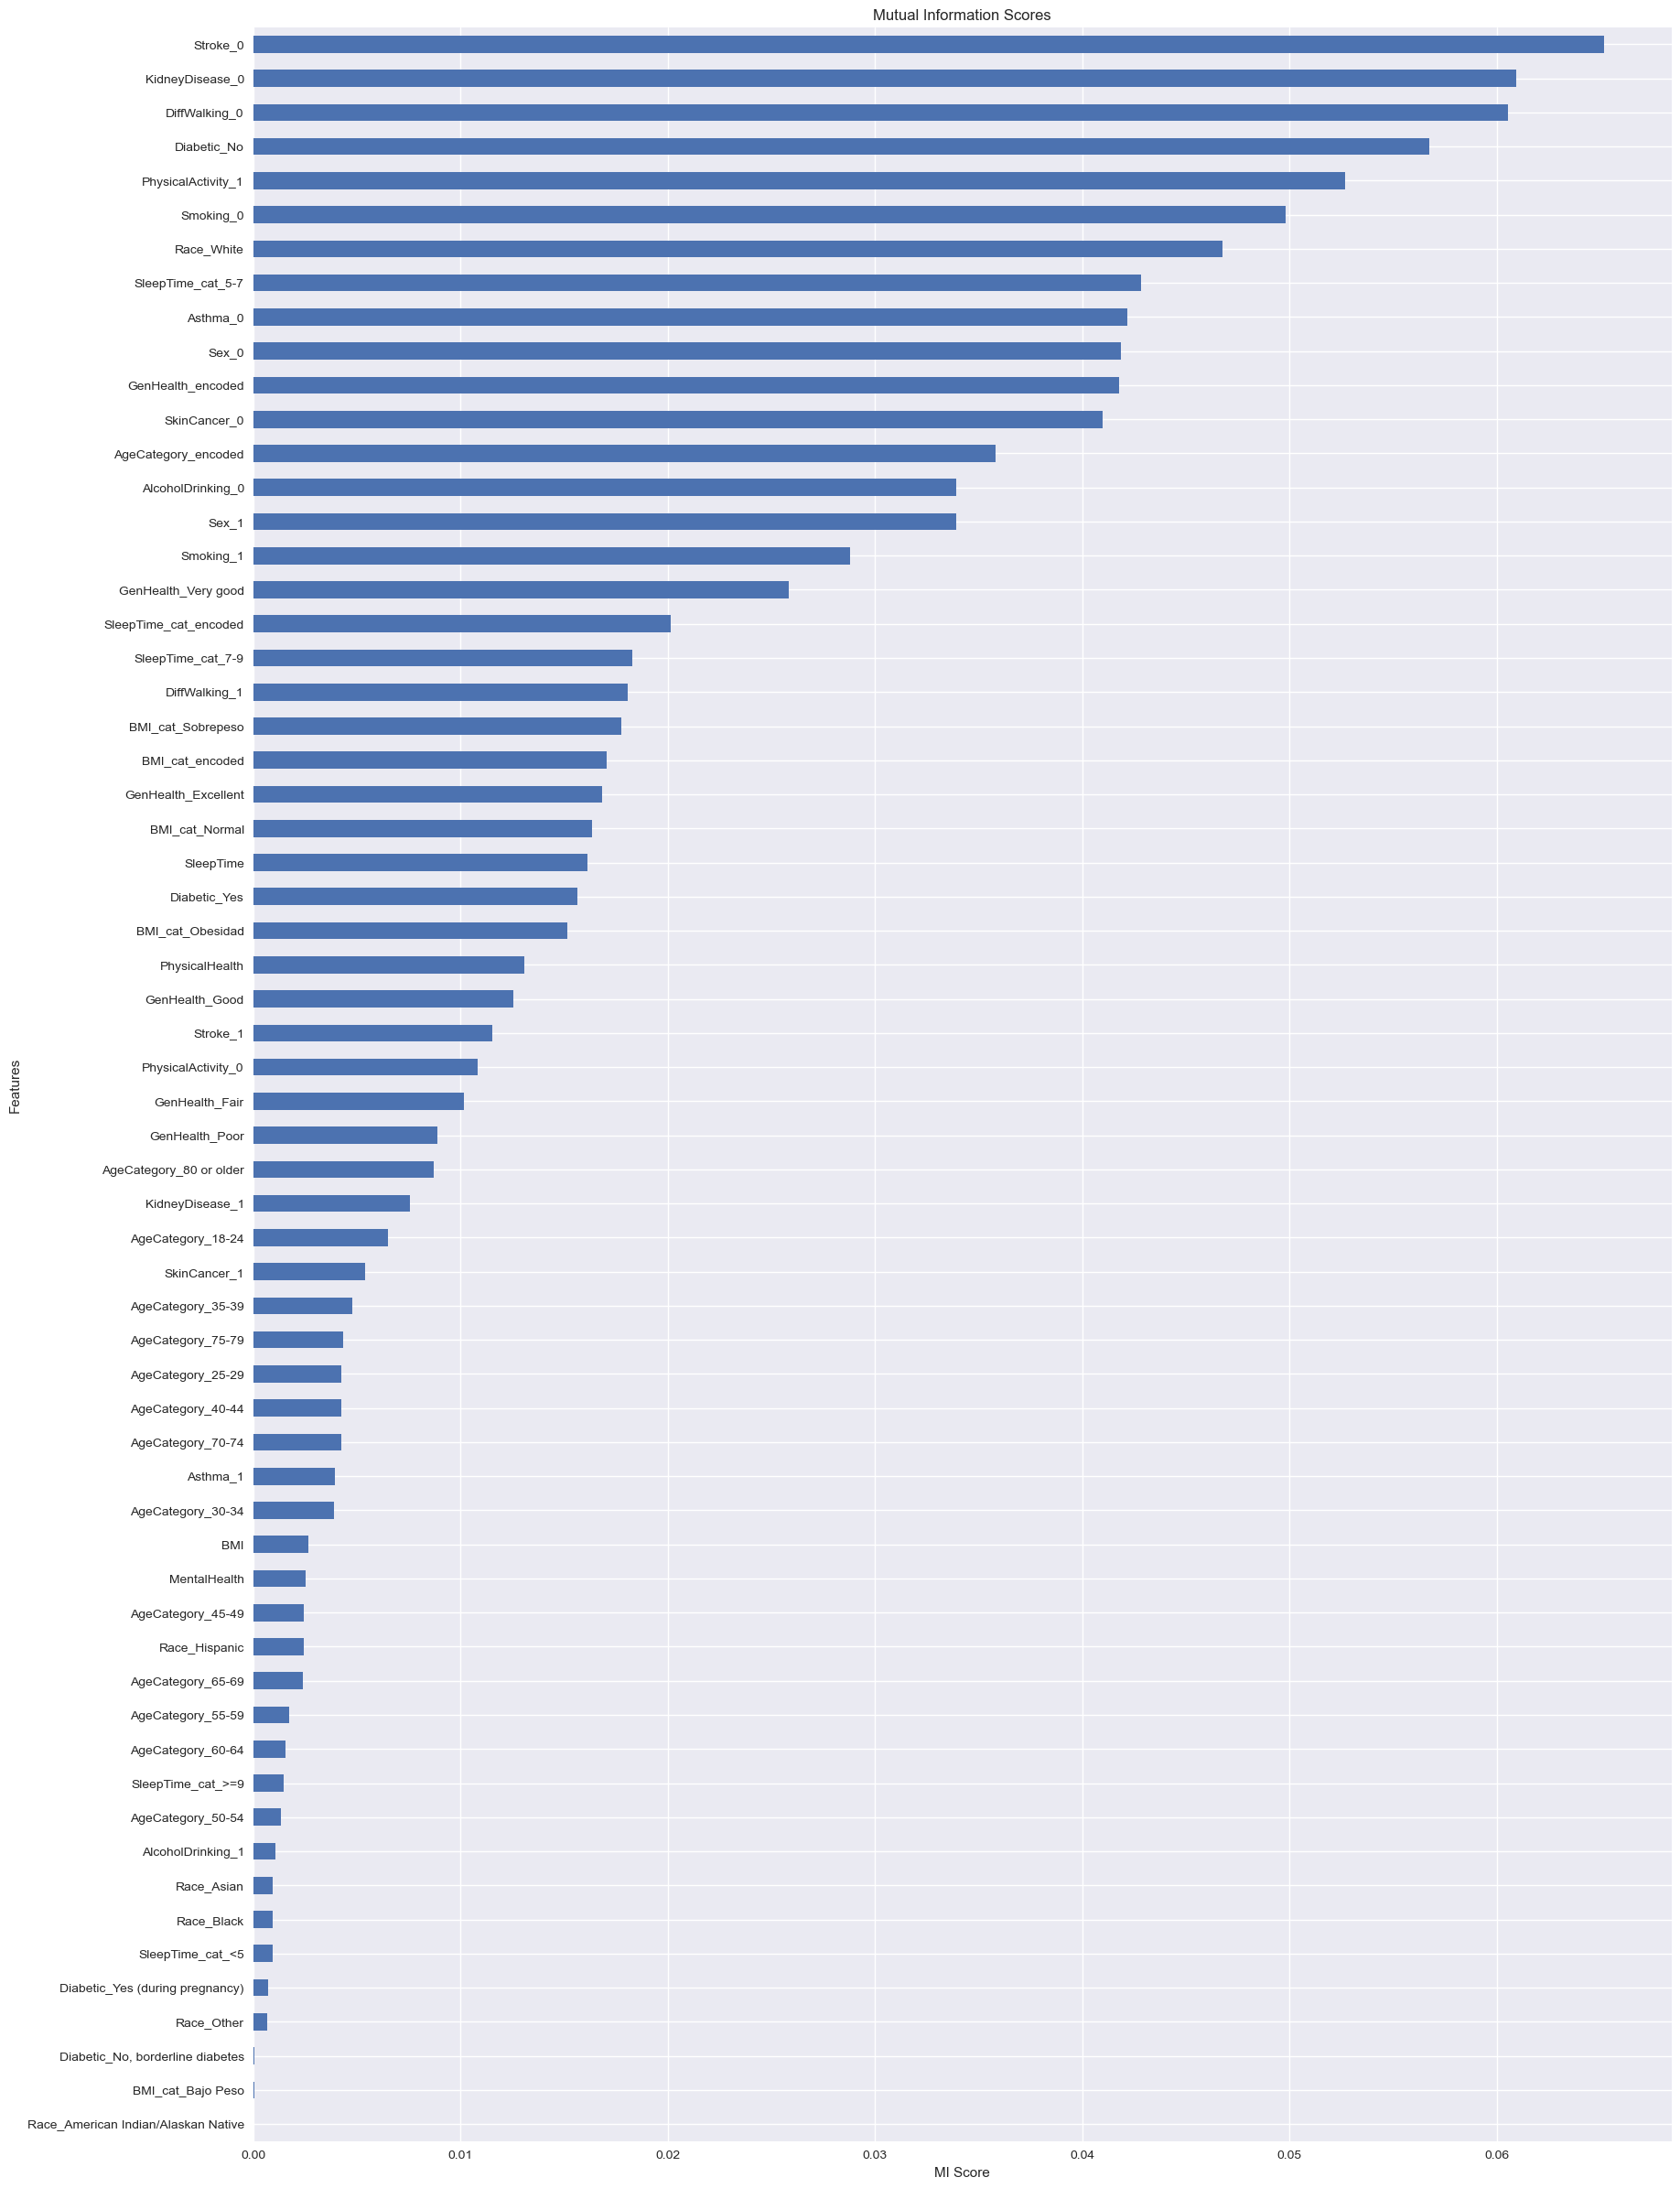

Stroke_0                               0.065172
KidneyDisease_0                        0.060963
DiffWalking_0                          0.060533
Diabetic_No                            0.056747
PhysicalActivity_1                     0.052678
Smoking_0                              0.049824
Race_White                             0.046775
SleepTime_cat_5-7                      0.042841
Asthma_0                               0.042185
Sex_0                                  0.041870
GenHealth_encoded                      0.041778
SkinCancer_0                           0.040992
AgeCategory_encoded                    0.035819
AlcoholDrinking_0                      0.033922
Sex_1                                  0.033917
Smoking_1                              0.028793
GenHealth_Very good                    0.025842
SleepTime_cat_encoded                  0.020167
SleepTime_cat_7-9                      0.018287
DiffWalking_1                          0.018060
BMI_cat_Sobrepeso                      0

In [14]:
mutual_info_analysis(oe_data, TARGET_VARIABLE, False, (20, 30), 'ohe')

## Feature Importance: ExtraTreesClassifier method

In [15]:
def perform_extra_trees_regr_classif(df: pd.DataFrame, 
                                  target_col: str, 
                                  regressor: bool,
                                  figsize: tuple = (10, 15), 
                                  encoder: str = None, 
                                  ohe_cols: List[str] = None, 
                                  le_cols: List[str] = None,
                                  n_estimators: int = 100, 
                                  criterion: str ='squared_error', 
                                  max_features: float = 1.0, 
                                  k: int = 10
                                 ) -> pd.DataFrame:
    """
    Trains an ExtraTreesRegressor model on the given dataframe and returns the k most important features.
    Parameters:
    -----------
    df : pd.DataFrame
        The input dataframe with predictor and target variables.
    target_col : str
        The name of the target variable.
    regressor: bool
        A boolean indicating if it is a regression or classification problem.
    figsize : tuple, optional
        The size of the matplotlib figure to display the feature importances (default is (10, 15)).
    encoder : str, optional
        The type of encoder to use on the categorical variables. Can be either 'ohe' for OneHotEncoder or 'le' for LabelEncoder (default is None).
    ohe_cols : list, optional
        The names of the columns to apply OneHotEncoder to. If not specified, all categorical columns are encoded (default is None).
    le_cols : list, optional
        The names of the columns to apply LabelEncoder to. If not specified, all categorical columns are encoded (default is None).
    n_estimators : int, optional
        The number of trees in the forest (default is 100).
    criterion : str, optional
        The function to measure the quality of a split. Can be either 'mse' for mean squared error or 'mae' for mean absolute error (default is 'squared_error').
    max_features : float, optional
        The maximum number of features each tree is allowed to use (default is 1.0).
    k : int, optional
        The number of top features to return (default is 10).
    Returns:
    --------
    pd.DataFrame
        A dataframe with the k most important features and their corresponding importances.
    """
    # drop rows with na
    df = df.dropna(axis=1)

    # Separate the predictors and target variable
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    # Apply one-hot encoding if specified
    if ohe_cols:
        categorical_cols = list(set(ohe_cols) & set(X.columns))
        if categorical_cols:
            ohe = OneHotEncoder()
            ohe.fit(X[categorical_cols])
            encoded_cols = ohe.get_feature_names_out(categorical_cols)
            X_encoded = pd.concat([X.drop(categorical_cols, axis=1), 
                                   pd.DataFrame(ohe.transform(X[categorical_cols]).toarray(), 
                                                columns=encoded_cols)], axis=1)
            X = X_encoded
   # Apply encoding if specified
    elif encoder == "ohe":
    # One-hot encode categorical variables
        categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()
        if categorical_cols:
            ohe = OneHotEncoder()
            ohe.fit(X[categorical_cols])
            encoded_cols = ohe.get_feature_names_out(categorical_cols)
            X_encoded = pd.concat([X.drop(categorical_cols, axis=1), 
                                   pd.DataFrame(ohe.transform(X[categorical_cols]).toarray(), 
                                                columns=encoded_cols)], axis=1)
            X = X_encoded
    
    # Apply label encoding if specified
    if le_cols:
        categorical_cols = list(set(le_cols) & set(X.columns))
        if categorical_cols:
            le = LabelEncoder()
            X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))
    elif encoder == "le":
        # Label encode categorical variables
        categorical_cols = X.select_dtypes(include=['category', 'object']).columns.tolist()
        if categorical_cols:
            le = LabelEncoder()
            X[categorical_cols] = X[categorical_cols].apply(lambda col: le.fit_transform(col))

    # Delete categorical vars not specified to encode
    cat_vars = X.select_dtypes(include=['category', 'object']).columns.tolist()
    if cat_vars: # if not empty
        # Remove columns with categorical variables
        categorical_cols_in_data = set(cat_vars).intersection(set(X.columns))
        X = X.drop(categorical_cols_in_data, axis=1)
    
    if regressor: 
        model = ExtraTreesRegressor(n_estimators = n_estimators, criterion =criterion, max_features = max_features, random_state=42) # max_features = 0.3
    else: 
        model = ExtraTreesClassifier(n_estimators = n_estimators, criterion =criterion, max_features = max_features, random_state=42) # max_features = 0.3

    model.fit(X,y)
    # use inbuilt class feature importances of tree based classitiers 
    #print(model.feature_importances_)

    # perform feature important using the extra_tree_forest.feature_importances_
    # plot graph of feature importances for better visualization
    
    k = k # k most important features
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    feat_importances.nlargest(k).plot(kind='barh')
    plt.show()
    
    return feat_importances.nlargest(k).sort_values(ascending=False)
    

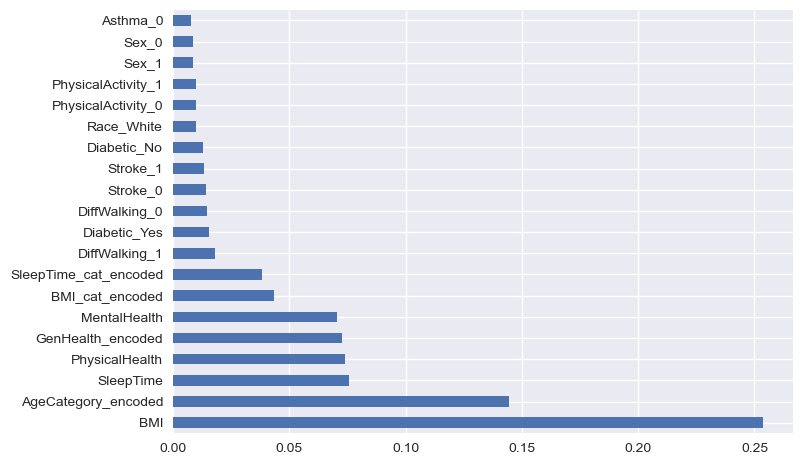

BMI                      0.253865
AgeCategory_encoded      0.144381
SleepTime                0.075788
PhysicalHealth           0.073934
GenHealth_encoded        0.072467
MentalHealth             0.070381
BMI_cat_encoded          0.043445
SleepTime_cat_encoded    0.038232
DiffWalking_1            0.018017
Diabetic_Yes             0.015287
DiffWalking_0            0.014686
Stroke_0                 0.014371
Stroke_1                 0.013262
Diabetic_No              0.013004
Race_White               0.010022
PhysicalActivity_0       0.009809
PhysicalActivity_1       0.009712
Sex_1                    0.008649
Sex_0                    0.008417
Asthma_0                 0.007949
dtype: float64

In [16]:
# aplicamos ExtraTreesClassifier
perform_extra_trees_regr_classif(df = oe_data, 
                                  target_col= TARGET_VARIABLE, 
                                  regressor=False, 
                                  figsize = (10, 15), 
                                  #encoder, 
                                  ohe_cols = ohe_vars, 
                                  #le_cols,
                                  n_estimators = 100, 
                                  criterion = 'entropy', 
                                  max_features = 'sqrt', 
                                  k = 20)

## PCA

In [17]:
def perform_pca(df: pd.DataFrame, target_variable: str, n_components: int = 3) -> Tuple[pd.DataFrame, pd.DataFrame]:
    
    """
    Perform principal component analysis (PCA) on a DataFrame with numeric features and plot the variance explained by each 
    principal component and the loadings for each principal component. Returns the loadings for each component and the transformed data.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with numeric features.
    target_variable : str
        Name of the target variable column to be removed from the DataFrame.
    n_components : int, optional
        Number of principal components to compute. Default is 3.

    Returns:
    --------
    Tuple[pd.DataFrame, pd.DataFrame]
        Tuple containing the loadings for each component and the transformed data.
        
    Example:
    --------
    # perform PCA on the DataFrame
    loadings, transformed_data = perform_pca(df, 'target_variable', 2)
    """

    # remove the target variable from the DataFrame 
    df = df.drop(columns=target_variable)
    
    # select only the numeric features and drop na values 
    numeric_features = df.select_dtypes(include=['int64', 'float64']).dropna()    
    X = numeric_features
    
    # scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # apply PCA
    pca = PCA(n_components=n_components)
    pca.fit(X_scaled)

    # calculate the variance explained by each component
    variance = pd.DataFrame({'variance': pca.explained_variance_ratio_*100, # *100: Percentage of explained variances
                             'PC': ['PC{}'.format(i) for i in range(1, n_components+1)]})
    variance = variance.sort_values('variance', ascending=False)

    # plot the variance explained by each component
    sns.barplot(x='PC', y='variance', data=variance, color='blue')
    plt.title('Variance explained by each principal component')
    plt.xlabel('Principal Component')
    plt.ylabel('Percentage of explained variances') 
    plt.show()

    # get the loadings for each component
    loadings = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i) for i in range(1, n_components+1)], index=X.columns)

    # plot the loadings for each principal component
    n_rows = (n_components + 1) // 2
    fig, axs = plt.subplots(n_rows, 2, figsize=(15, 6 * n_rows), sharey=False, gridspec_kw={'hspace': 0.4, 'wspace': 0.5})
    
    for i in range(n_components):
        row = i // 2
        col = i % 2
        loadings_pc = loadings[f'PC{i+1}'].abs().sort_values(ascending=False)
        sns.barplot(x=loadings_pc.values, y=loadings_pc.index, ax=axs[row, col], color='blue', order=loadings_pc.index)
        axs[row, col].set_title(f'Loadings for PC{i+1}')
        axs[row, col].set_xlabel('Loading Value')
        axs[row, col].set_ylabel('Variable')
        
    # adjust the subplots if n_components is odd to remove an empty subplot
    if n_components % 2 != 0:
        axs[n_rows-1, 1].remove()

    plt.show()

    # return the transformed data and the loadings
    transformed_data = pd.DataFrame(pca.transform(X_scaled), columns=['PC{}'.format(i) for i in range(1, n_components+1)])
    return loadings, transformed_data

In [18]:
# number of numeric variables 
len(train_data_preprocessed.select_dtypes(include=['int64', 'float64']).columns)

4

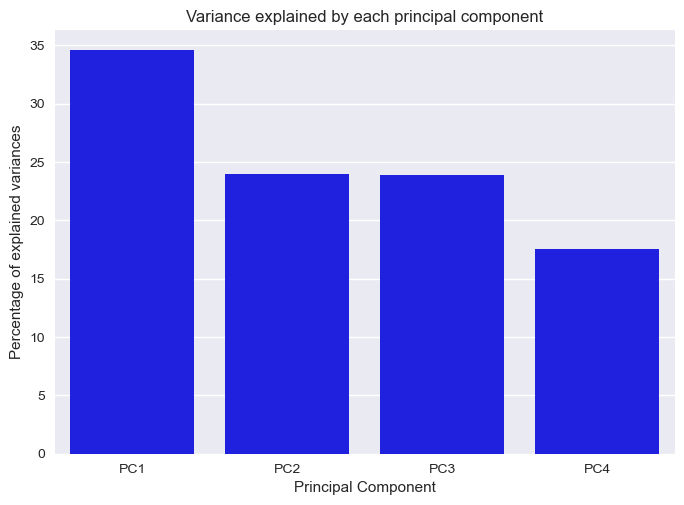

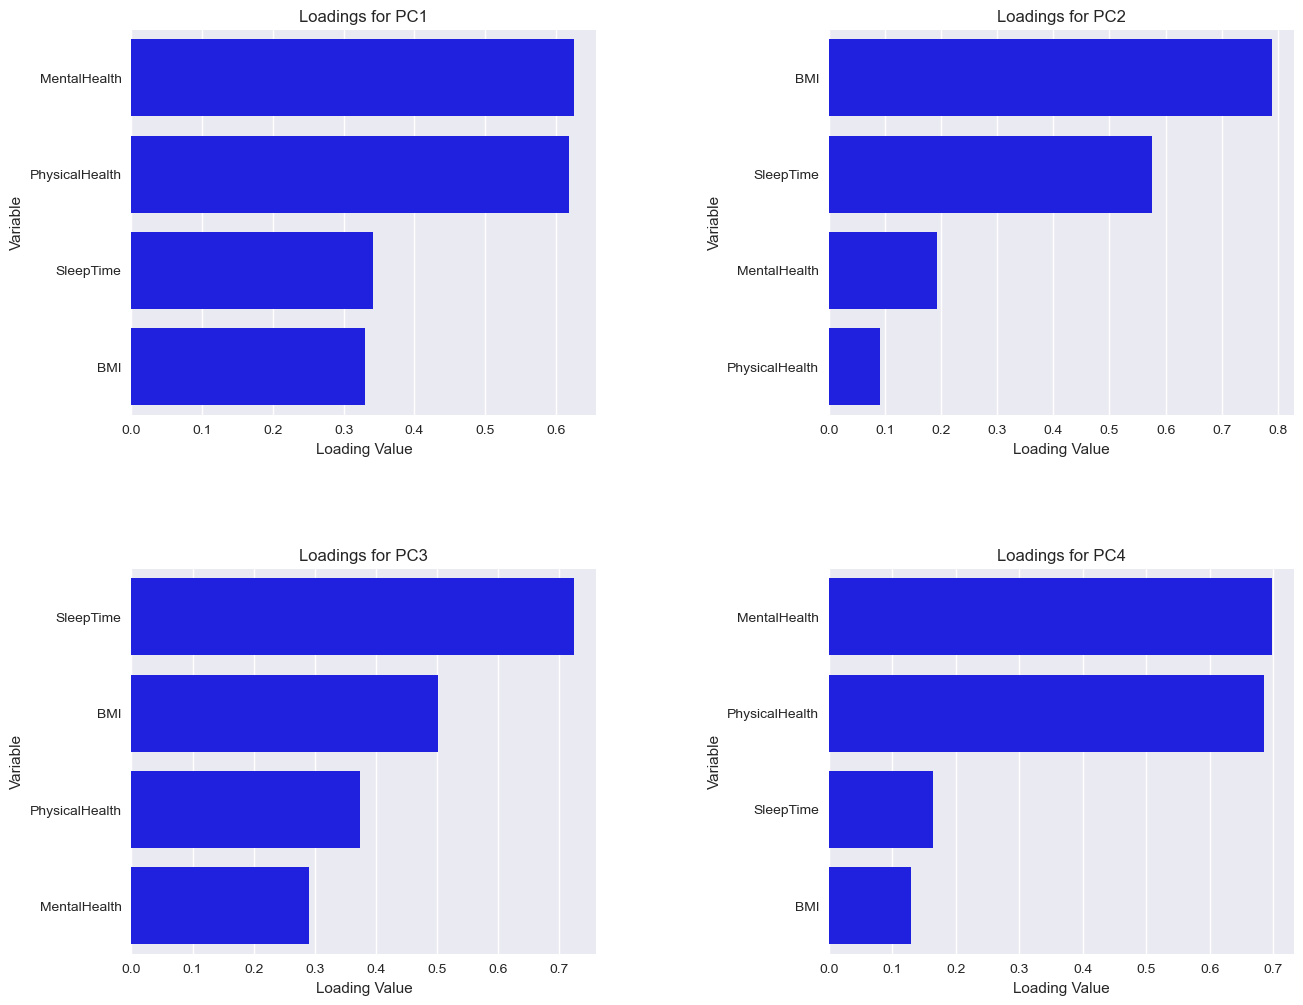

PC1       PC2       PC3       PC4
BMI             0.330454  0.789195 -0.501051  0.130073
PhysicalHealth  0.618189  0.091547  0.374010 -0.685257
MentalHealth    0.626193 -0.192960  0.290127  0.697477
SleepTime      -0.341356  0.575809  0.724494  0.164404

In [19]:
loadings, transdformed_data = perform_pca(train_data_preprocessed, TARGET_VARIABLE, n_components=4)
display(loadings)

## Test set pre-processing

In [20]:
file_path_test = 'test_data.csv'

data_preprocessor = DataPreprocessor()
data_preprocessor.data_preprocessor(file_path_test)

# guardamos en csv
data_preprocessor.df.to_csv('test_data_preprocessed.csv', index=False)

In [221]:
# cargamos el dataset de test preprocesado
test_data_preprocessed = pd.read_csv('test_data_preprocessed.csv', delimiter=',')
# convertimos las categóricas a 'category' ya que al volver a cargar el csv no se conservan los data types modificados
convert_categorical_to_category(test_data_preprocessed)

explore_data(test_data_preprocessed)

The dataset includes 63959 instances (rows) and 20 variables (columns).



HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0            0  27.12       0               0      0            30.0   
1            0  49.39       1               0      0            25.0   
2            0  32.92       0               0      0             3.0   
3            0  26.36       1               0      0             0.0   
4            0  22.71       0               0      0             0.0   

   MentalHealth DiffWalking Sex AgeCategory   Race Diabetic PhysicalActivity  \
0           7.0           0   1       45-49  White      Yes                1   
1           2.0           1   0       45-49  White       No                1   
2          29.0           0   0       35-39  White       No                1   
3           0.0           0   1       70-74  White       No                1   
4          10.0           0   0       65-69  White       No                1   

   GenHealth  SleepTime Asthma KidneyDisease SkinCancer    BMI_cat  \
0       Fair        8.0      0             0          0  Sobrepeso   
1       Fair        6.0      1             0          0   Obesidad   
2       Good        8.0      1             0          0   Obesidad   
3       Fair        7.0      0             0          0  Sobrepeso   
4  Excellent        7.0      0             0          0     Normal   

  SleepTime_cat  
0           7-9  
1           5-7  
2           7-9  
3           5-7  
4           5-7



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63959 entries, 0 to 63958
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   HeartDisease      63959 non-null  category
 1   BMI               63959 non-null  float64 
 2   Smoking           63959 non-null  category
 3   AlcoholDrinking   63959 non-null  category
 4   Stroke            63959 non-null  category
 5   PhysicalHealth    63959 non-null  float64 
 6   MentalHealth      63959 non-null  float64 
 7   DiffWalking       63959 non-null  category
 8   Sex               63959 non-null  category
 9   AgeCategory       63959 non-null  category
 10  Race              63959 non-null  category
 11  Diabetic          63959 non-null  category
 12  PhysicalActivity  63959 non-null  category
 13  GenHealth         63959 non-null  category
 14  SleepTime         63959 non-null  float64 
 15  Asthma            63959 non-null  category
 16  KidneyDisease     63

BMI  PhysicalHealth  MentalHealth     SleepTime
count  63959.000000    63959.000000  63959.000000  63959.000000
mean      28.339361        3.363889      3.879548      7.093482
std        6.390725        7.944886      7.939228      1.433835
min       12.400000        0.000000      0.000000      1.000000
25%       24.030000        0.000000      0.000000      6.000000
50%       27.370000        0.000000      0.000000      7.000000
75%       31.380000        2.000000      3.000000      8.000000
max       91.820000       30.000000     30.000000     24.000000


 Number of duplicates: 1014


## MODELING

En general, queremos alcanzar una alta sensibilidad (tasa de verdaderos positivos) manteniendo al mismo tiempo una alta especificidad (tasa de verdaderos negativos) para minimizar el número de falsos negativos y falsos positivos, respectivamente.

En este caso, como el coste de pasar por alto un caso de cardiopatía (falso negativo) es muy alto, queremos elegir un umbral que maximice la sensibilidad, aunque dé lugar a más falsos positivos. 

Por otro lado, si el coste de un falso positivo fuese elevado (por ejemplo, procedimientos o tratamientos médicos innecesarios), es posible que queramos elegir un umbral que maximice la especificidad, aunque dé lugar a más falsos negativos.

En este caso, queremos la primera opción (queremos elegir un umbral que maximice la sensibilidad), aunque dé lugar a más falsos positivos. 

In [9]:
def one_hot_encode(df: pd.DataFrame, cat_features: List[str]) -> pd.DataFrame:
    """
    Encodes categorical features in a dataframe using scikit-learn's OneHotEncoder.

    Args:
    df (pandas.DataFrame): input dataframe
    cat_features (list): list of categorical feature column names

    Returns:
    pandas.DataFrame: dataframe with categorical features one-hot encoded
    """
    # create OneHotEncoder object and fit on categorical features
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit(df[cat_features])

    # get category names from encoder
    cat_names = encoder.get_feature_names_out(cat_features)

    # transform categorical features to one-hot encoded features and create new dataframe
    encoded_cat_features = encoder.transform(df[cat_features])
    df_encoded = pd.DataFrame(encoded_cat_features, columns=cat_names)

    # add original numerical features to encoded features dataframe
    num_features = df.drop(cat_features, axis=1)
    df_encoded = pd.concat([num_features.reset_index(drop=True), df_encoded], axis=1)

    return df_encoded



def generate_train_test_sets(df_train: pd.DataFrame, 
                             df_test: pd.DataFrame, 
                             target: str) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
        """
            Generate training and test sets.
            Args:
                df_train (pd.DataFrame): Training dataset.
                df_test (pd.DataFrame): Test dataset.
                target (str): Target variable name.
            Returns:
                X_train (pd.DataFrame): Training features.
                y_train (pd.Series): Training target variable.
                X_test (pd.DataFrame): Test features.
                y_test (pd.Series): Test target variable.
        """
        X_train = df_train.drop(columns=[target])
        y_train = df_train[target]

        X_test = df_test.drop(columns=[target])
        y_test = df_test[target]

        return X_train, y_train, X_test, y_test


### CatBoost

In [ ]:
def create_train_test(used_data, cat_feat, num_feat, y_var):

  X = data[cat_feat + num_feat]
  y = data[[y_var]]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

  return X_train, y_train, X_test, y_test

  #normalize(num_features)

In [ ]:
def downsampling(X_sample, y_sample, perc):

  # Set the probability of deleting a row
  prob_delete = perc
  deleted = 0

  # Iterate over the rows in the DataFrame
  for index, row in X_sample.iterrows():
      # Generate a random number between 0 and 1
      random_num = random.random()
      
      # Delete the row if the random number is less than the delete probability
      if random_num < prob_delete and y_sample.loc[index, 'HeartDisease_num'] == 0:
          X_train_balanced.drop(index, inplace=True)
          y_train_balanced.drop(index, inplace=True)
          deleted += 1

          if (deleted%1000) == 0:
            print(deleted)

  return X_train_balanced, y_train_balanced

In [ ]:
from sklearn.preprocessing import LabelEncoder

def create_catboost_model(X_train_func, y_train_func, X_test_func, y_test_func, cat_feat):

  d_train_cat = Pool(X_train_func, y_train_func['HeartDisease_num'], cat_features = cat_feat)
  d_test_cat = Pool(X_test_func, y_test_func['HeartDisease_num'], cat_features = cat_feat)

  clf = CatBoostClassifier()
  params = {'iterations': [50],
            'depth': [6, 9],
            'loss_function': ['Logloss', 'CrossEntropy'],
            'l2_leaf_reg': np.logspace(-20, -19, 2),
            'leaf_estimation_iterations': [10],
             'eval_metric': ['Accuracy', 'F1', 'AUC'],
             #'use_best_model': ['True'],
            'logging_level':['Silent'],
            'random_seed': [42]
          }
  #scorer = make_scorer(accuracy_score)
  clf_grid = GridSearchCV(estimator=clf, param_grid=params, cv=3)

  X_train_enc = X_train_func.apply(LabelEncoder().fit_transform)

  clf_grid.fit(X_train_enc, y_train_func['HeartDisease_num'])
  best_param = clf_grid.best_params_
  print(best_param)

  #{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 100, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'loss_function': 'Logloss', 'random_seed': 42}


  # use_best_model params to prevent model overfitting
  best_cat = CatBoostClassifier(iterations=500,
                           loss_function=best_param['loss_function'],
                           depth=best_param['depth'],
                           l2_leaf_reg=best_param['l2_leaf_reg'],
                           eval_metric=best_param['eval_metric'],
                           leaf_estimation_iterations=best_param['leaf_estimation_iterations'],
                           #use_best_model=True,
                           logging_level='Silent',
                           random_seed=best_param['random_seed']
                          )

  #params = {'depth': 6,
  #          'learning_rate': 0.02,
  #          'iterations': 100}

  # Create CatBoost model with best hyperparameters
  #best_cat = CatBoostClassifier(loss_function='Logloss', **params)

  # Train the model on the training data
  best_cat.fit(d_train_cat)

  # Make predictions on the test data
  y_pred = best_cat.predict(d_test_cat)

  return best_cat, y_pred

In [ ]:
def evaluate_model(model_cat, y_test, y_pred):
  #y_pred = (model.predict(X_test) >= 0.5).astype(int)

  print(classification_report(y_test, y_pred))


  cm = confusion_matrix(y_test, y_pred)

  fig, ax = plt.subplots(figsize=(8, 8))
  ax.imshow(cm)
  ax.grid(False)
  ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  ax.set_ylim(1.5, -0.5)
  for i in range(2):
      for j in range(2):
          ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
  plt.show()


  cat_importance = pd.DataFrame({"Features": model_cat.feature_names_
                                , "Importance": model_cat.feature_importances_}
                              ).sort_values('Importance', ascending=False)
  print(cat_importance)


  plt.rcdefaults()
  fig, ax = plt.subplots()

  ax.barh(y = 'Features'
          , width = 'Importance'
          , data = cat_importance)
  ax.invert_yaxis()  # labels read top-to-bottom
  plt.show()

#### Initial CatBoost model

{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     58576
           1       0.58      0.08      0.14      5383

    accuracy                           0.92     63959
   macro avg       0.75      0.54      0.55     63959
weighted avg       0.89      0.92      0.89     63959



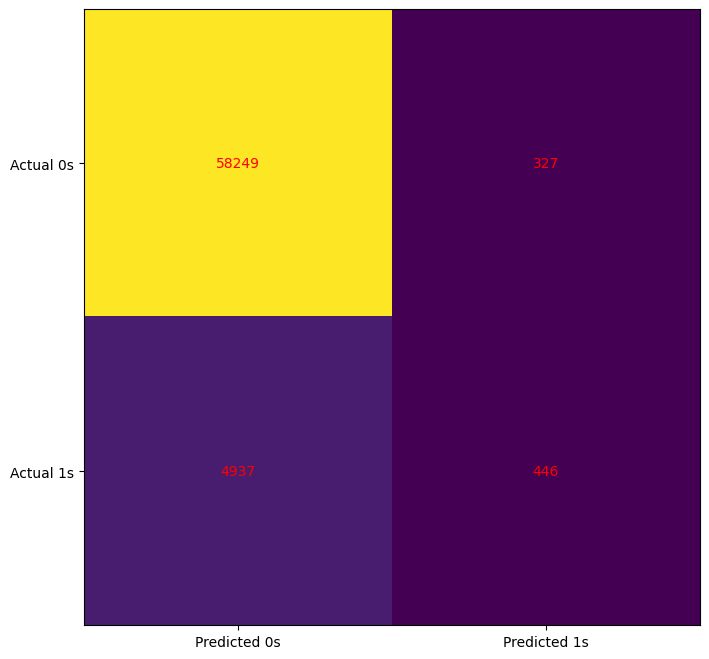

            Features  Importance
12       AgeCategory   35.455662
9          GenHealth   19.207367
11          Diabetic    7.405379
8                Sex    7.154369
2             Stroke    4.327356
14    PhysicalHealth    3.596634
3        DiffWalking    3.531805
0            Smoking    3.402417
10              Race    3.374580
13               BMI    3.206248
16         SleepTime    2.736150
6      KidneyDisease    1.931451
15      MentalHealth    1.393472
5             Asthma    1.323578
7         SkinCancer    0.933179
1    AlcoholDrinking    0.780068
4   PhysicalActivity    0.240283


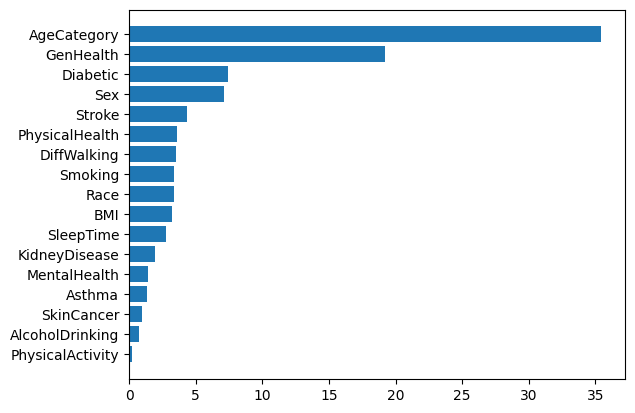

In [ ]:
# Select Features
cat_features = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer', 'Sex', 'GenHealth', 'Race', 'Diabetic', 'AgeCategory' ]
num_features = ['BMI',	'PhysicalHealth',	'MentalHealth',	'SleepTime']
goal = 'HeartDisease_num'

# Train - Test division
X_train, y_train, X_test, y_test = create_train_test(data, cat_features, num_features, goal)

# Downsampling
#X_train_balanced, y_train_balanced = downsampling(X_train, y_train, percentage)

# Hyperparameter selection + Cross Validation / training
best_cat, y_pred = create_catboost_model(X_train, y_train, X_test, y_test, cat_features)

# Model results
evaluate_model(best_cat, y_test, y_pred)

#### Downsampling 70%

{'depth': 9, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     58576
           1       0.35      0.46      0.39      5383

    accuracy                           0.88     63959
   macro avg       0.65      0.69      0.66     63959
weighted avg       0.90      0.88      0.89     63959



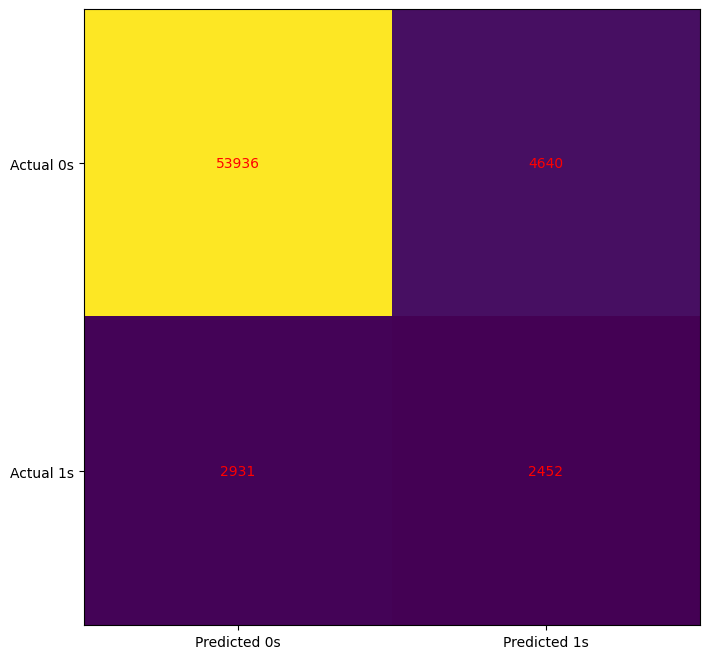

            Features  Importance
12       AgeCategory   18.791724
9          GenHealth   14.852450
11          Diabetic    8.762868
10              Race    8.705708
13               BMI    8.420661
16         SleepTime    6.745869
14    PhysicalHealth    5.542416
15      MentalHealth    4.777041
8                Sex    4.677492
2             Stroke    3.577218
0            Smoking    3.170331
6      KidneyDisease    2.545931
3        DiffWalking    2.520051
5             Asthma    2.227943
1    AlcoholDrinking    1.792115
7         SkinCancer    1.576916
4   PhysicalActivity    1.313268


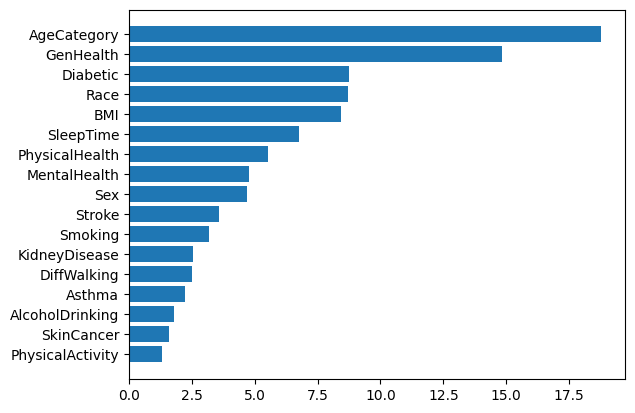

In [ ]:
# Select Features
cat_features = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer', 'Sex', 'GenHealth', 'Race', 'Diabetic', 'AgeCategory' ]
num_features = ['BMI',	'PhysicalHealth',	'MentalHealth',	'SleepTime']
goal = 'HeartDisease_num'

# Train - Test division
X_train, y_train, X_test, y_test = create_train_test(data, cat_features, num_features, goal)

# Downsampling
#X_train_balanced, y_train_balanced = downsampling(X_train, y_train, percentage)

X_train_balanced = pd.read_csv("X_train_balanced_70.csv")
X_train_balanced = X_train_balanced[cat_features + num_features]
y_train_balanced = pd.read_csv("y_train_balanced_70.csv")

for i in range(0,len(cat_features)):
    X_train_balanced[cat_features[i]] = X_train_balanced[cat_features[i]].astype("category")

# Hyperparameter selection + Cross Validation / training
best_cat, y_pred = create_catboost_model(X_train_balanced, y_train_balanced, X_test, y_test, cat_features)

# Model results
evaluate_model(best_cat, y_test, y_pred)

#### Downsampling 90%

{'depth': 9, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.97      0.82      0.88     58576
           1       0.26      0.69      0.37      5383

    accuracy                           0.80     63959
   macro avg       0.61      0.75      0.63     63959
weighted avg       0.91      0.80      0.84     63959



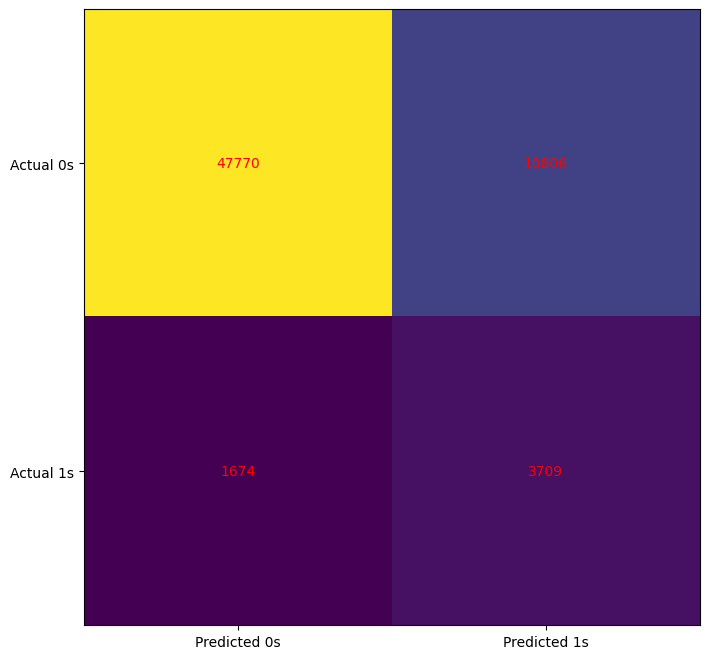

            Features  Importance
12       AgeCategory   19.039365
9          GenHealth   13.110393
10              Race   10.401161
11          Diabetic    8.696860
13               BMI    8.584336
16         SleepTime    7.124170
14    PhysicalHealth    5.356471
8                Sex    4.712056
15      MentalHealth    4.610039
0            Smoking    3.385858
2             Stroke    3.212249
3        DiffWalking    2.590939
6      KidneyDisease    2.236931
5             Asthma    2.028959
7         SkinCancer    1.914963
1    AlcoholDrinking    1.539181
4   PhysicalActivity    1.456068


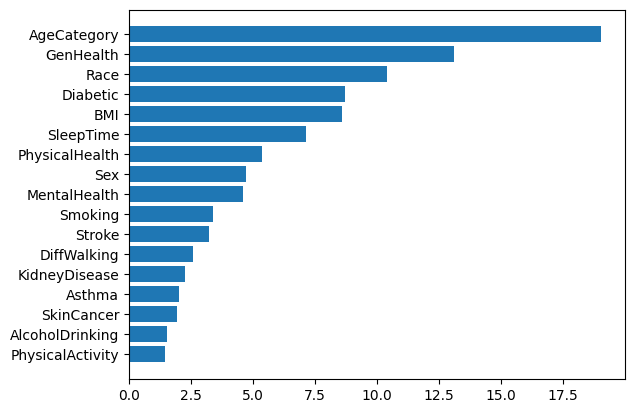

In [ ]:
# Select Features
cat_features = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer', 'Sex', 'GenHealth', 'Race', 'Diabetic', 'AgeCategory' ]
num_features = ['BMI',	'PhysicalHealth',	'MentalHealth',	'SleepTime']
goal = 'HeartDisease_num'

# Train - Test division
X_train, y_train, X_test, y_test = create_train_test(data, cat_features, num_features, goal)

# Downsampling
#X_train_balanced, y_train_balanced = downsampling(X_train, y_train, percentage)

X_train_balanced = pd.read_csv("X_train_balanced_90.csv")
X_train_balanced = X_train_balanced[cat_features + num_features]
y_train_balanced = pd.read_csv("y_train_balanced_90.csv")

for i in range(0,len(cat_features)):
    X_train_balanced[cat_features[i]] = X_train_balanced[cat_features[i]].astype("category")

# Hyperparameter selection + Cross Validation / training
best_cat, y_pred = create_catboost_model(X_train_balanced, y_train_balanced, X_test, y_test, cat_features)

# Model results
evaluate_model(best_cat, y_test, y_pred)


#### Only variables that can be actually changed

{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.95      0.83      0.88     58576
           1       0.22      0.52      0.31      5383

    accuracy                           0.80     63959
   macro avg       0.58      0.68      0.60     63959
weighted avg       0.89      0.80      0.84     63959



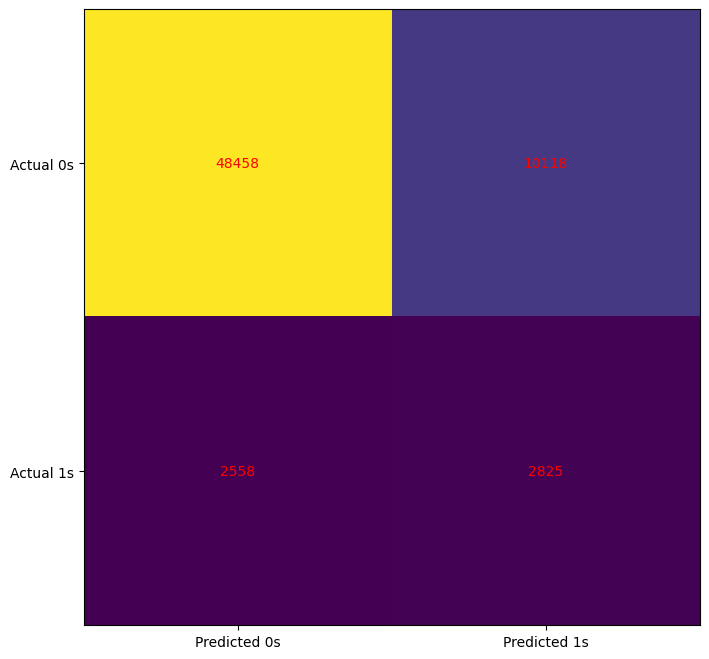

           Features  Importance
3         GenHealth   33.744501
4               BMI   16.051194
7         SleepTime   13.149471
6      MentalHealth   11.954637
5    PhysicalHealth    9.394598
0           Smoking    7.925003
1   AlcoholDrinking    4.693456
2  PhysicalActivity    3.087140


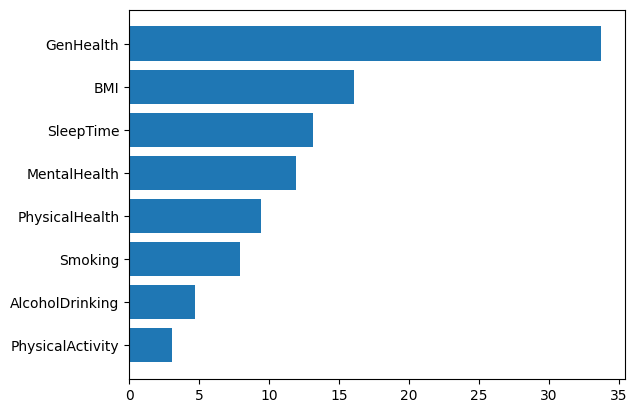

In [ ]:
# Select Features
cat_features = ['Smoking', 'AlcoholDrinking', 'PhysicalActivity', 'GenHealth' ]
num_features = ['BMI',	'PhysicalHealth',	'MentalHealth',	'SleepTime']
goal = 'HeartDisease_num'

# Train - Test division
X_train, y_train, X_test, y_test = create_train_test(data, cat_features, num_features, goal)

# Downsampling
#X_train_balanced, y_train_balanced = downsampling(X_train, y_train, percentage)

X_train_balanced = pd.read_csv("X_train_balanced_90.csv")
X_train_balanced = X_train_balanced[cat_features + num_features]
y_train_balanced = pd.read_csv("y_train_balanced_90.csv")

for i in range(0,len(cat_features)):
    X_train_balanced[cat_features[i]] = X_train_balanced[cat_features[i]].astype("category")

X_test = X_test[cat_features + num_features]

# Hyperparameter selection + Cross Validation / training
best_cat, y_pred = create_catboost_model(X_train_balanced, y_train_balanced, X_test, y_test, cat_features)

# Model results
evaluate_model(best_cat, y_test, y_pred)

#### Divide by age chunks

Model for age 55-59
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5413
           1       0.37      0.04      0.07       411

    accuracy                           0.93      5824
   macro avg       0.65      0.52      0.51      5824
weighted avg       0.89      0.93      0.90      5824



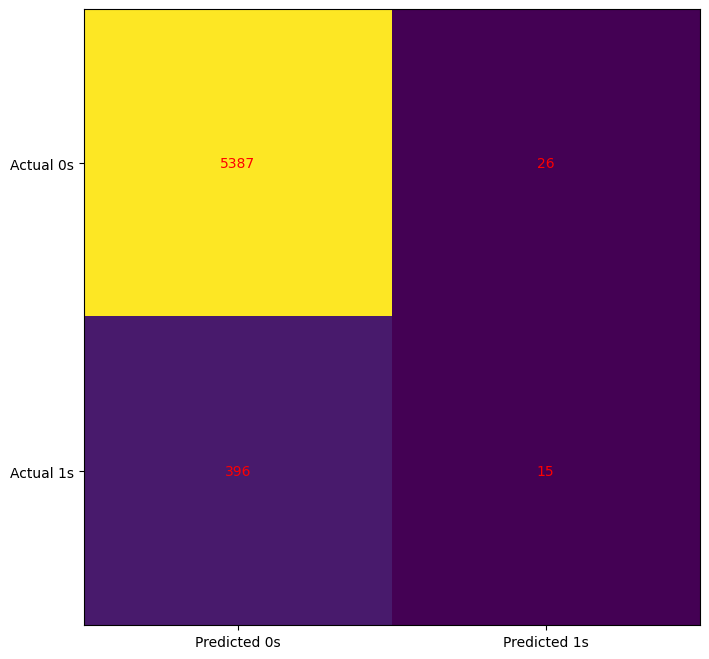

            Features  Importance
9          GenHealth   16.478457
10              Race   14.244217
16         SleepTime   13.861688
13               BMI   10.295382
11          Diabetic    8.517188
15      MentalHealth    6.161603
14    PhysicalHealth    5.754438
8                Sex    4.406598
0            Smoking    3.478182
2             Stroke    3.319986
6      KidneyDisease    3.176447
3        DiffWalking    2.763767
5             Asthma    2.326874
1    AlcoholDrinking    1.869418
4   PhysicalActivity    1.747838
7         SkinCancer    1.597918
12       AgeCategory    0.000000


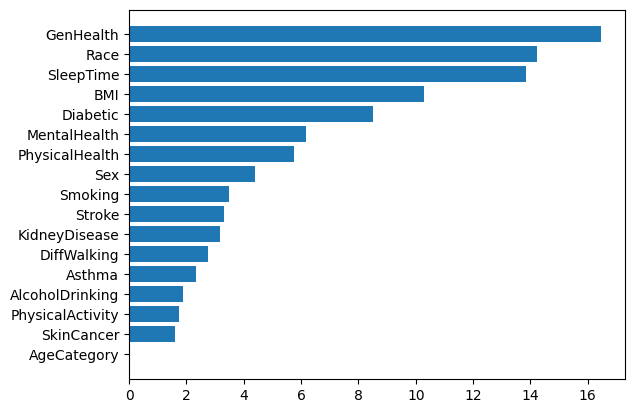

Model for age 80 or older
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.79      0.97      0.87      3700
           1       0.57      0.12      0.20      1060

    accuracy                           0.78      4760
   macro avg       0.68      0.55      0.54      4760
weighted avg       0.74      0.78      0.72      4760



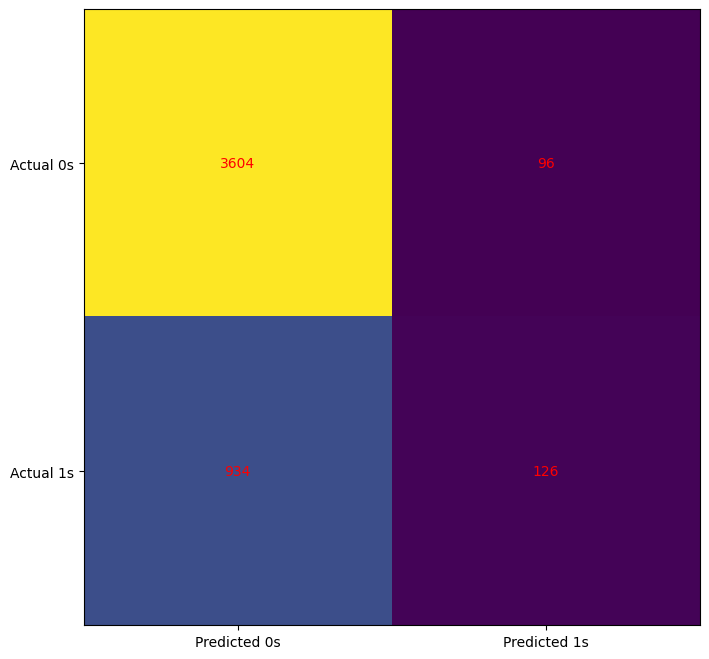

            Features  Importance
9          GenHealth   17.045379
11          Diabetic   14.127550
10              Race   13.693842
13               BMI   12.921961
16         SleepTime    9.316559
14    PhysicalHealth    5.881262
8                Sex    5.586028
15      MentalHealth    4.293998
2             Stroke    3.196333
3        DiffWalking    3.024879
6      KidneyDisease    2.918998
0            Smoking    2.054531
7         SkinCancer    1.987678
5             Asthma    1.683080
4   PhysicalActivity    1.261256
1    AlcoholDrinking    1.006668
12       AgeCategory    0.000000


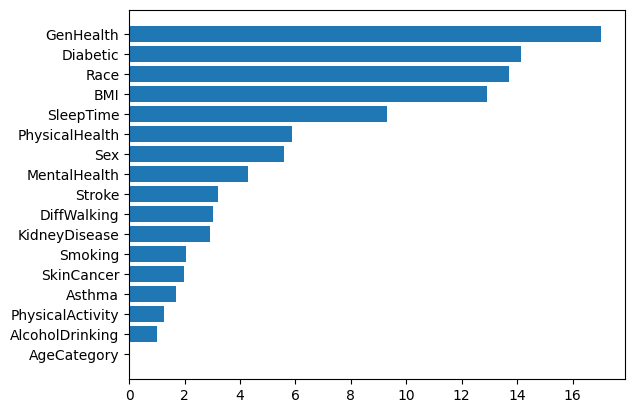

Model for age 65-69
{'depth': 9, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      6004
           1       0.43      0.07      0.12       783

    accuracy                           0.88      6787
   macro avg       0.66      0.53      0.53      6787
weighted avg       0.84      0.88      0.84      6787



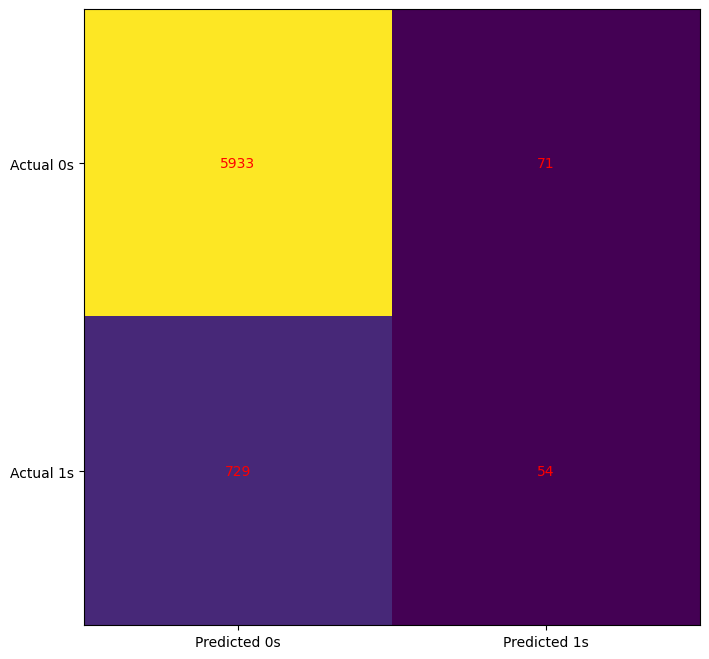

            Features  Importance
9          GenHealth   16.142253
13               BMI   12.921349
11          Diabetic    9.895718
16         SleepTime    9.126254
10              Race    8.383372
14    PhysicalHealth    7.078644
15      MentalHealth    7.018775
8                Sex    6.249846
0            Smoking    4.450158
6      KidneyDisease    3.197801
5             Asthma    3.170366
3        DiffWalking    3.028796
4   PhysicalActivity    2.955186
7         SkinCancer    2.705222
2             Stroke    2.433212
1    AlcoholDrinking    1.243046
12       AgeCategory    0.000000


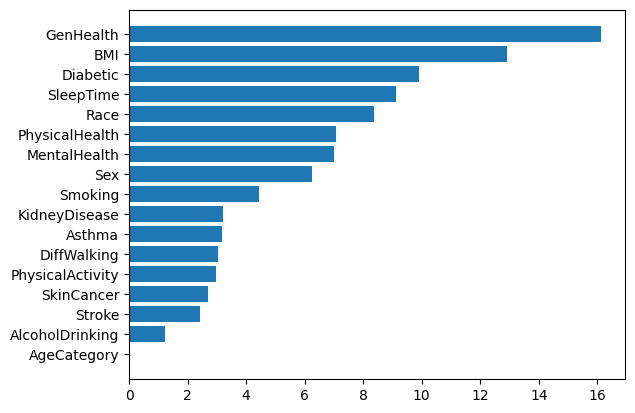

Model for age 75-79
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      3577
           1       0.53      0.12      0.19       785

    accuracy                           0.82      4362
   macro avg       0.68      0.55      0.55      4362
weighted avg       0.78      0.82      0.77      4362



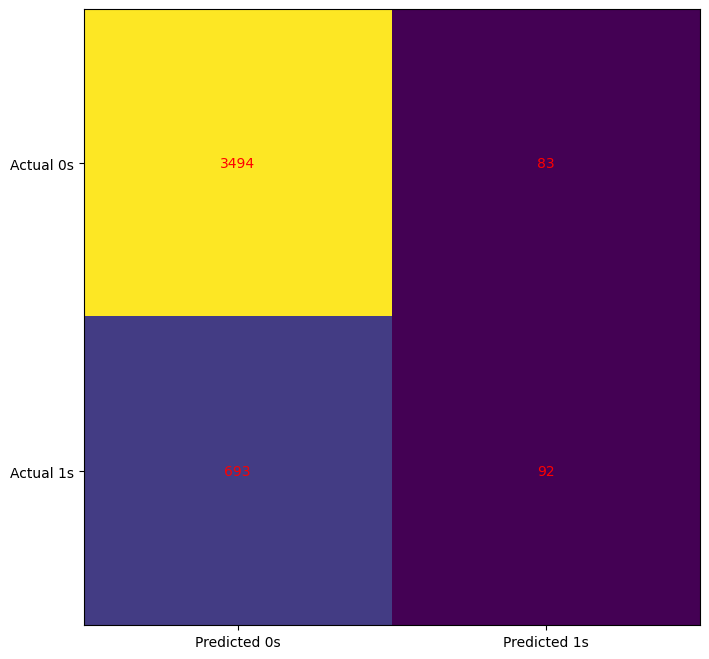

            Features  Importance
9          GenHealth   19.954432
13               BMI   12.295519
10              Race   12.018370
11          Diabetic    9.549914
16         SleepTime    9.222721
8                Sex    6.988695
14    PhysicalHealth    6.828291
15      MentalHealth    5.611876
2             Stroke    3.817047
7         SkinCancer    2.547773
6      KidneyDisease    2.392973
0            Smoking    2.302807
5             Asthma    2.002956
1    AlcoholDrinking    1.937507
3        DiffWalking    1.330130
4   PhysicalActivity    1.198990
12       AgeCategory    0.000000


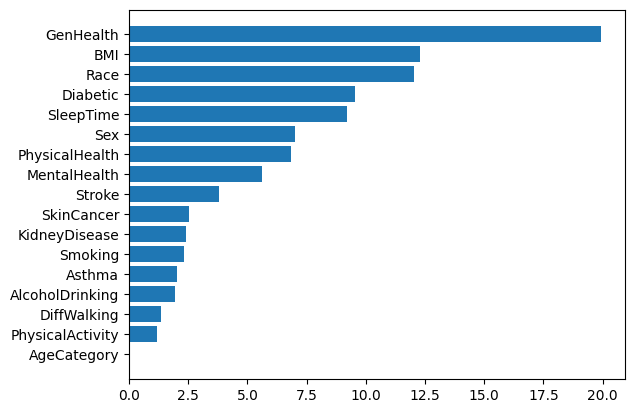

Model for age 40-44
{'depth': 9, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4108
           1       0.50      0.02      0.04       103

    accuracy                           0.98      4211
   macro avg       0.74      0.51      0.51      4211
weighted avg       0.96      0.98      0.96      4211



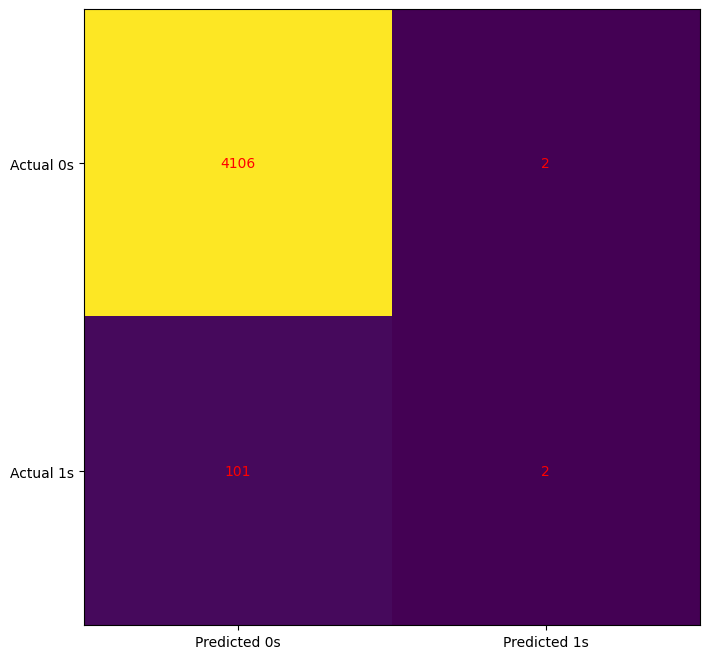

            Features  Importance
13               BMI   15.150732
9          GenHealth   15.007014
16         SleepTime   11.608350
15      MentalHealth   10.771131
14    PhysicalHealth    9.133623
8                Sex    8.660838
10              Race    7.120727
0            Smoking    5.327731
11          Diabetic    4.893982
1    AlcoholDrinking    3.742329
5             Asthma    2.801479
4   PhysicalActivity    2.095450
3        DiffWalking    1.681459
2             Stroke    0.922108
7         SkinCancer    0.600079
6      KidneyDisease    0.482968
12       AgeCategory    0.000000


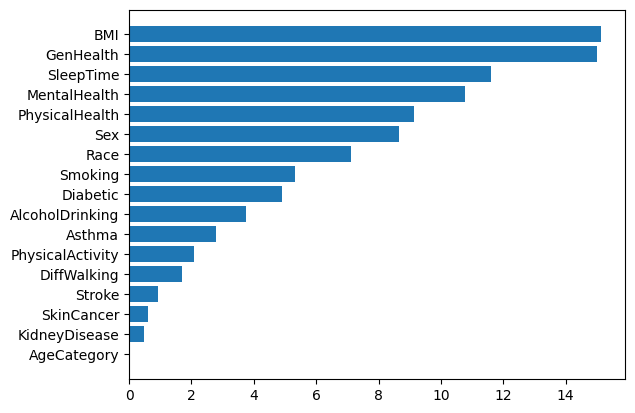

Model for age 70-74
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.86      0.98      0.91      5350
           1       0.53      0.12      0.19       991

    accuracy                           0.85      6341
   macro avg       0.70      0.55      0.55      6341
weighted avg       0.81      0.85      0.80      6341



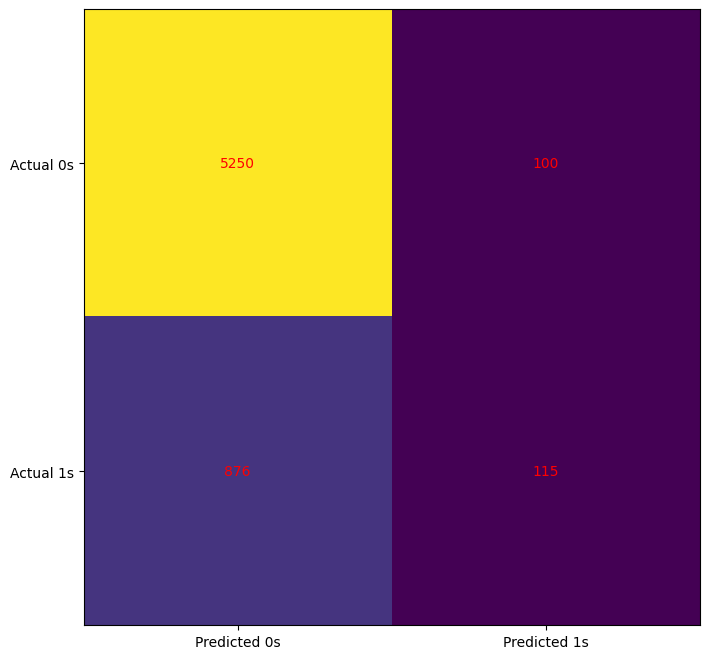

            Features  Importance
9          GenHealth   17.813784
13               BMI   13.604151
10              Race   13.074172
11          Diabetic   11.118668
16         SleepTime    7.824557
8                Sex    6.805700
14    PhysicalHealth    6.037563
15      MentalHealth    4.322611
0            Smoking    4.125834
2             Stroke    3.374223
1    AlcoholDrinking    2.419899
6      KidneyDisease    2.259996
3        DiffWalking    2.052927
5             Asthma    1.904182
4   PhysicalActivity    1.754564
7         SkinCancer    1.507172
12       AgeCategory    0.000000


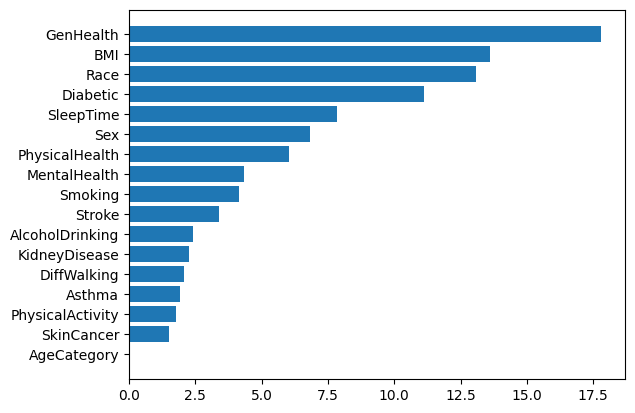

Model for age 60-64
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      6151
           1       0.63      0.08      0.14       653

    accuracy                           0.91      6804
   macro avg       0.77      0.54      0.54      6804
weighted avg       0.88      0.91      0.87      6804



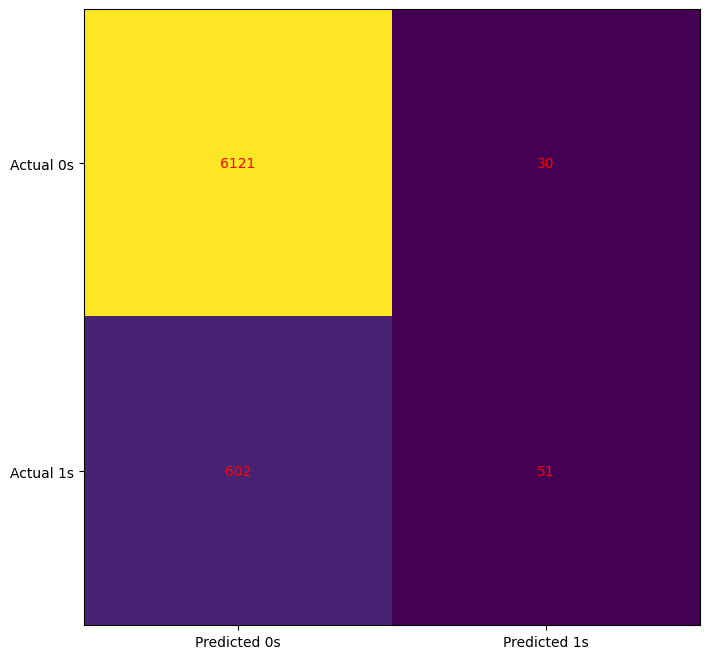

            Features  Importance
9          GenHealth   18.858528
13               BMI   11.976691
11          Diabetic   10.725021
10              Race   10.239379
16         SleepTime    9.868681
14    PhysicalHealth    6.640968
15      MentalHealth    6.639259
8                Sex    5.174188
6      KidneyDisease    2.979643
2             Stroke    2.872295
0            Smoking    2.747484
3        DiffWalking    2.612106
7         SkinCancer    2.579857
5             Asthma    2.474928
1    AlcoholDrinking    1.927394
4   PhysicalActivity    1.683577
12       AgeCategory    0.000000


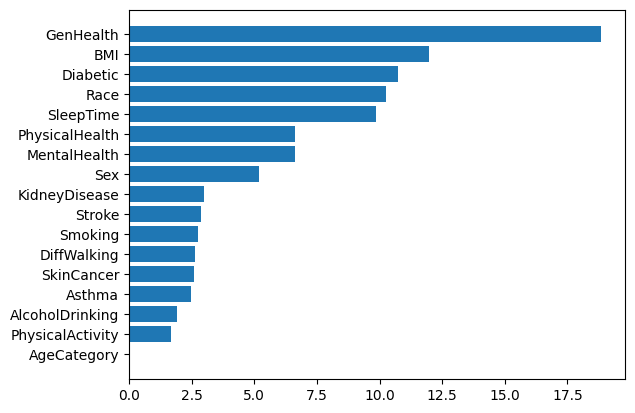

Model for age 50-54
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4769
           1       0.62      0.07      0.13       291

    accuracy                           0.94      5060
   macro avg       0.78      0.53      0.55      5060
weighted avg       0.93      0.94      0.92      5060



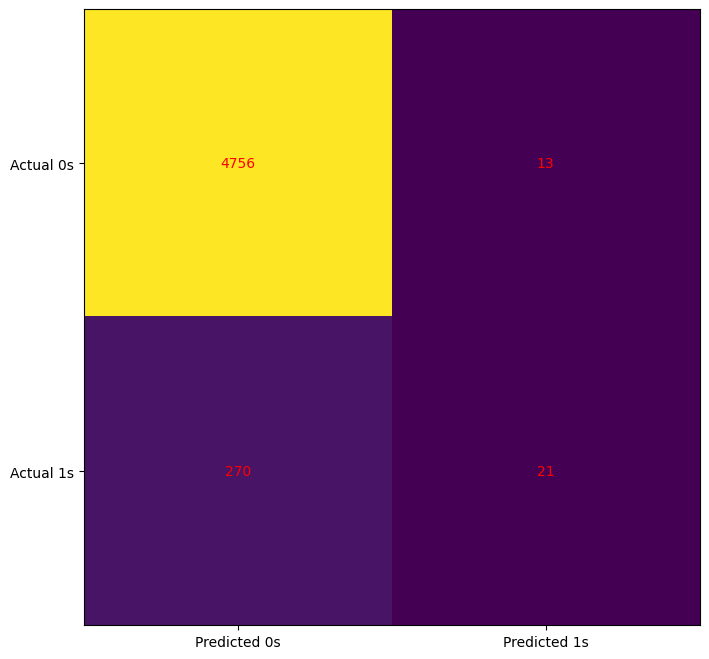

            Features  Importance
9          GenHealth   17.979356
13               BMI   12.864473
10              Race   11.112236
16         SleepTime   10.063665
11          Diabetic    8.110290
14    PhysicalHealth    7.548050
15      MentalHealth    7.030171
0            Smoking    3.892432
6      KidneyDisease    3.858243
8                Sex    3.383034
4   PhysicalActivity    2.964496
3        DiffWalking    2.800161
5             Asthma    2.726017
2             Stroke    2.649267
1    AlcoholDrinking    1.904570
7         SkinCancer    1.113540
12       AgeCategory    0.000000


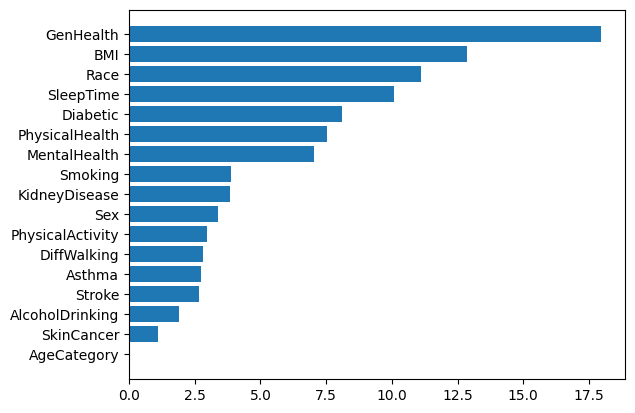

Model for age 45-49
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4203
           1       0.17      0.01      0.02       152

    accuracy                           0.96      4355
   macro avg       0.57      0.51      0.50      4355
weighted avg       0.94      0.96      0.95      4355



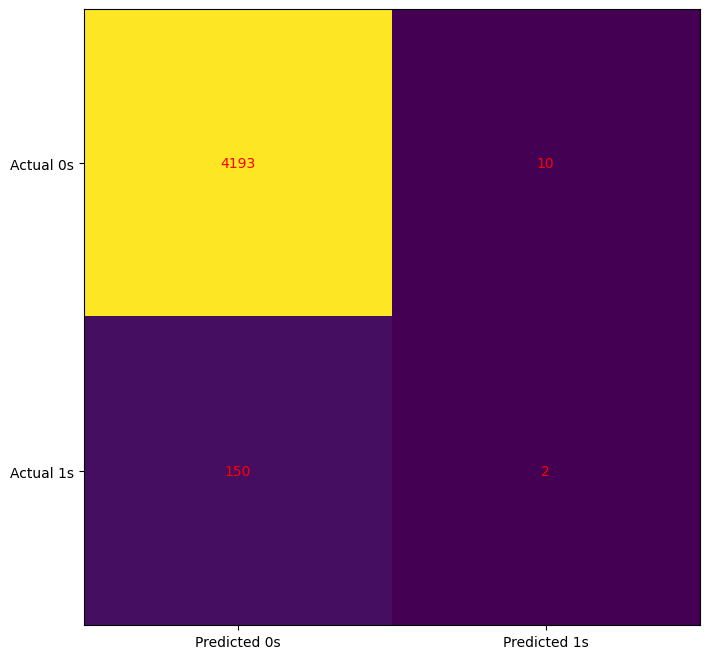

            Features  Importance
13               BMI   17.028391
9          GenHealth   16.317725
16         SleepTime   14.480057
10              Race   12.330152
11          Diabetic    8.985184
15      MentalHealth    5.676772
14    PhysicalHealth    5.169611
8                Sex    3.944652
6      KidneyDisease    2.970722
0            Smoking    2.759426
5             Asthma    2.648994
3        DiffWalking    2.030005
2             Stroke    1.887533
7         SkinCancer    1.404970
4   PhysicalActivity    1.333155
1    AlcoholDrinking    1.032650
12       AgeCategory    0.000000


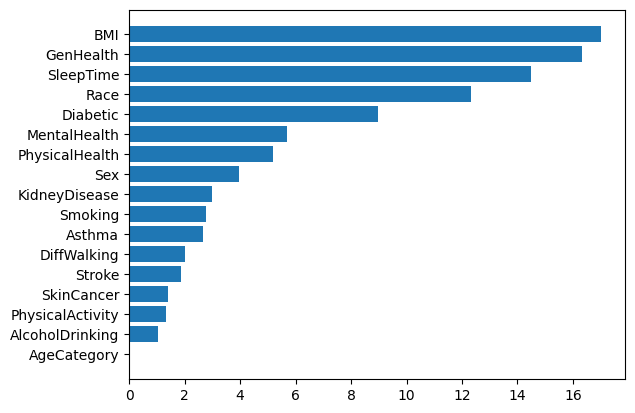

Model for age 18-24
{'depth': 9, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4122
           1       0.00      0.00      0.00        31

    accuracy                           0.99      4153
   macro avg       0.50      0.50      0.50      4153
weighted avg       0.99      0.99      0.99      4153



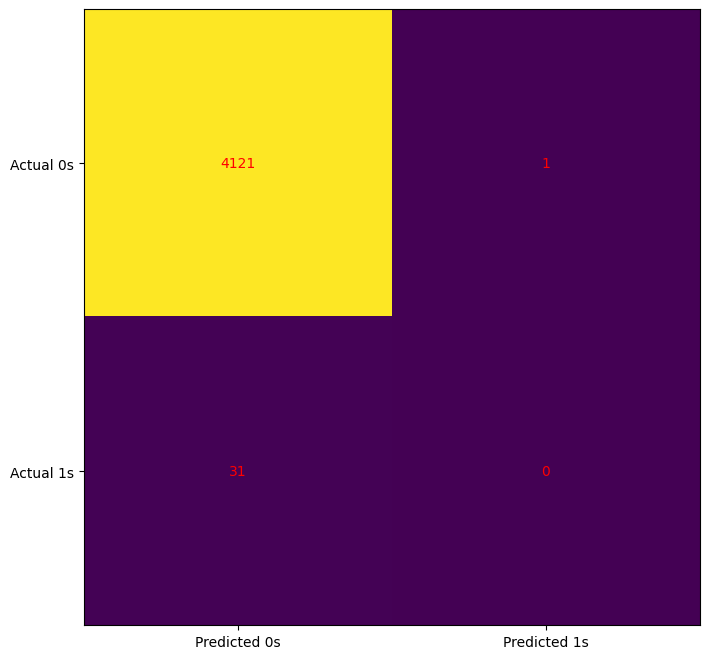

            Features  Importance
13               BMI   16.797486
15      MentalHealth   14.666338
16         SleepTime   12.931279
9          GenHealth   12.601311
10              Race   11.472718
8                Sex    7.242268
14    PhysicalHealth    7.222870
5             Asthma    4.670641
0            Smoking    3.442800
4   PhysicalActivity    3.329945
1    AlcoholDrinking    2.786657
11          Diabetic    1.961505
3        DiffWalking    0.502131
2             Stroke    0.197722
6      KidneyDisease    0.096640
7         SkinCancer    0.077689
12       AgeCategory    0.000000


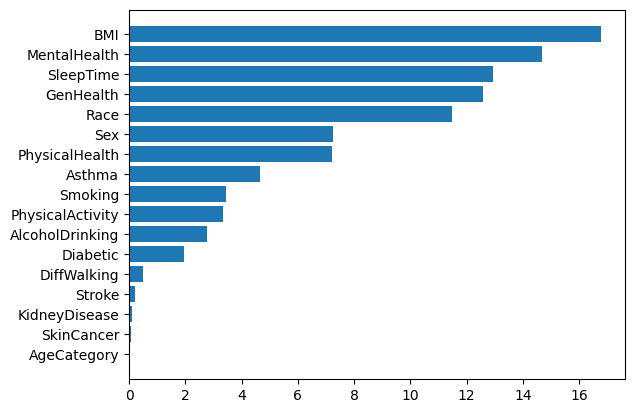

Model for age 35-39
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4128
           1       0.00      0.00      0.00        58

    accuracy                           0.99      4186
   macro avg       0.49      0.50      0.50      4186
weighted avg       0.97      0.99      0.98      4186



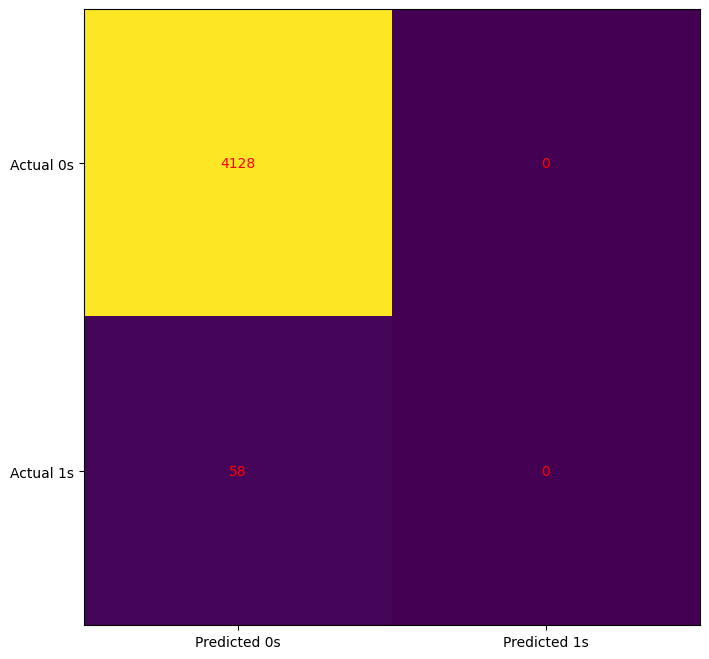

            Features  Importance
13               BMI   20.052171
9          GenHealth   14.088812
16         SleepTime   12.010785
15      MentalHealth    9.663589
14    PhysicalHealth    7.833285
11          Diabetic    7.361086
10              Race    7.037429
8                Sex    4.130338
1    AlcoholDrinking    3.635465
0            Smoking    3.324606
5             Asthma    2.987790
4   PhysicalActivity    2.786584
3        DiffWalking    2.048203
2             Stroke    1.107518
6      KidneyDisease    1.058239
7         SkinCancer    0.874101
12       AgeCategory    0.000000


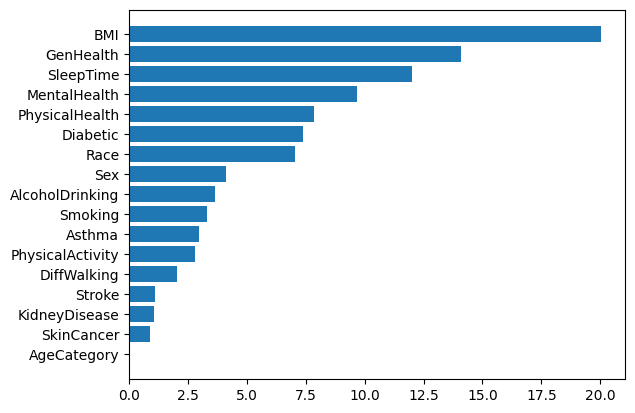

Model for age 30-34
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3632
           1       0.00      0.00      0.00        43

    accuracy                           0.99      3675
   macro avg       0.49      0.50      0.50      3675
weighted avg       0.98      0.99      0.98      3675



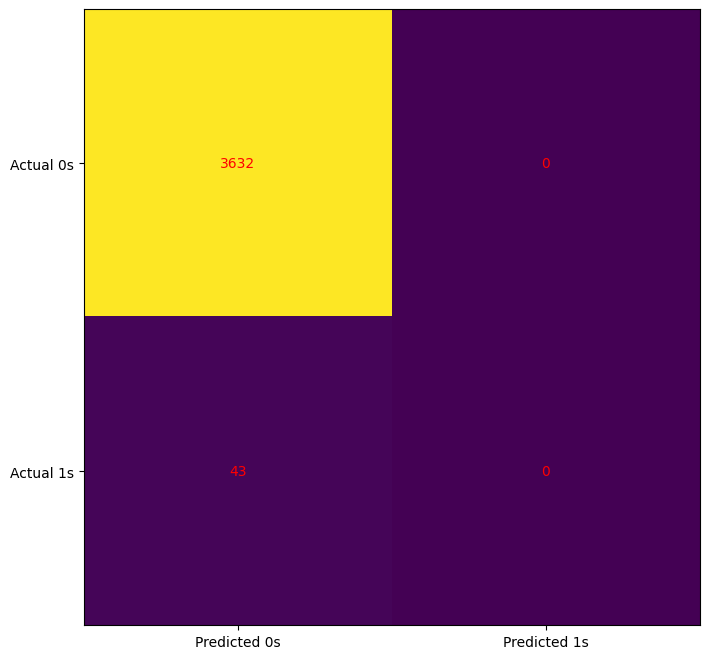

            Features  Importance
13               BMI   21.029142
16         SleepTime   11.582823
9          GenHealth   10.898235
15      MentalHealth   10.350933
10              Race    9.674823
14    PhysicalHealth    9.052862
0            Smoking    5.963842
8                Sex    4.817007
3        DiffWalking    4.558565
5             Asthma    3.737584
11          Diabetic    2.540572
4   PhysicalActivity    2.101420
1    AlcoholDrinking    2.017195
2             Stroke    0.941198
6      KidneyDisease    0.634579
7         SkinCancer    0.099221
12       AgeCategory    0.000000


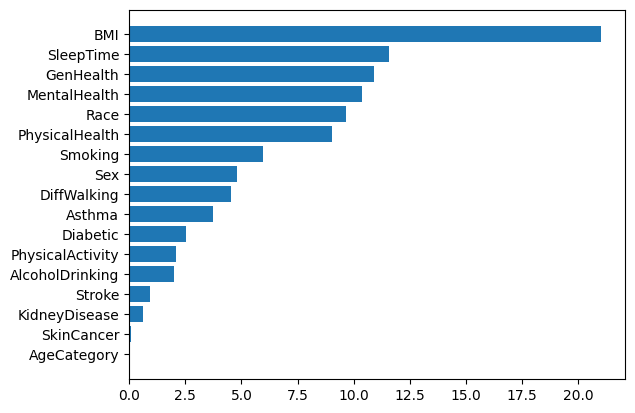

Model for age 25-29
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3419
           1       0.00      0.00      0.00        22

    accuracy                           0.99      3441
   macro avg       0.50      0.50      0.50      3441
weighted avg       0.99      0.99      0.99      3441



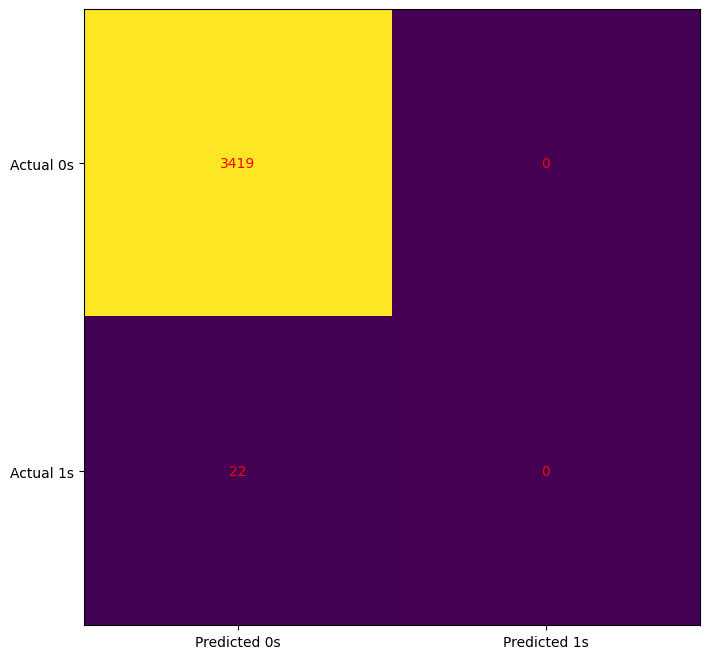

            Features  Importance
13               BMI   21.217630
15      MentalHealth   14.630975
9          GenHealth   11.562635
16         SleepTime   10.797017
14    PhysicalHealth    9.182074
10              Race    7.259063
5             Asthma    5.602368
1    AlcoholDrinking    4.338411
8                Sex    4.137808
0            Smoking    3.330978
4   PhysicalActivity    3.217514
11          Diabetic    2.475816
3        DiffWalking    1.031087
2             Stroke    0.810950
6      KidneyDisease    0.286460
7         SkinCancer    0.119215
12       AgeCategory    0.000000


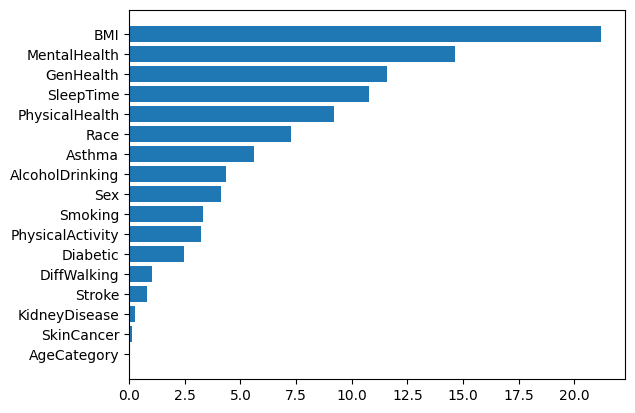

In [ ]:
# Select Features
cat_features = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer', 'Sex', 'GenHealth', 'Race', 'Diabetic', 'AgeCategory' ]
num_features = ['BMI',	'PhysicalHealth',	'MentalHealth',	'SleepTime']
goal = 'HeartDisease_num'

# Train - Test division
X_train, y_train, X_test, y_test = create_train_test(data, cat_features, num_features, goal)

# Downsampling
#X_train_balanced, y_train_balanced = downsampling(X_train, y_train, percentage)

for agecat in data['AgeCategory'].unique():

  print("Model for age " + agecat)

  X_train['HeartDisease_num'] = y_train['HeartDisease_num']
  X_test['HeartDisease_num'] = y_test['HeartDisease_num']

  X_train_age = X_train[ X_train['AgeCategory'] == agecat ]
  X_test_age = X_test[ X_test['AgeCategory'] == agecat ]

  #y_train_balanced_age = y_train_balanced
  #y_test_age = y_test

  y_train_age = pd.DataFrame()
  y_test_age = pd.DataFrame()

  y_train_age['HeartDisease_num'] = X_train_age['HeartDisease_num']
  y_test_age['HeartDisease_num'] = X_test_age['HeartDisease_num']

  X_train_age.drop(['HeartDisease_num'], inplace=True, axis=1)
  X_test_age.drop(['HeartDisease_num'], inplace=True, axis=1)

  # Hyperparameter selection + Cross Validation / training
  best_cat, y_pred = create_catboost_model(X_train_age, y_train_age, X_test_age, y_test_age, cat_features)

  # Model results
  evaluate_model(best_cat, y_test_age, y_pred)

#### Divide by age chunks 90%

In [ ]:
data['AgeCategory'].value_counts()

65-69          34151
60-64          33686
70-74          31065
55-59          29757
50-54          25382
80 or older    24153
45-49          21791
75-79          21482
18-24          21064
40-44          21006
35-39          20550
30-34          18753
25-29          16955
Name: AgeCategory, dtype: int64

Model for age 55-59
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      5413
           1       0.23      0.58      0.33       411

    accuracy                           0.83      5824
   macro avg       0.60      0.71      0.61      5824
weighted avg       0.91      0.83      0.86      5824



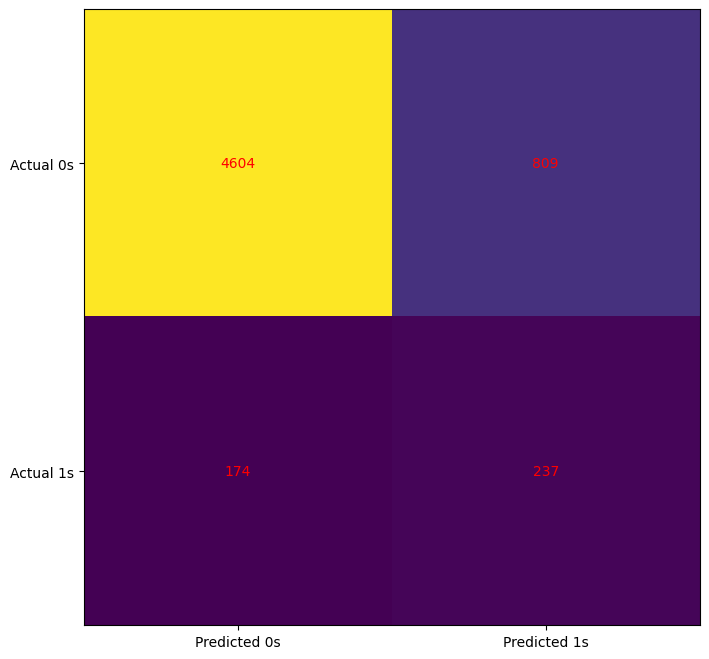

            Features  Importance
9          GenHealth   20.210238
10              Race   13.775743
13               BMI   13.537419
11          Diabetic   13.470829
16         SleepTime    6.224776
15      MentalHealth    5.561835
14    PhysicalHealth    5.330825
8                Sex    5.151633
2             Stroke    4.588306
6      KidneyDisease    2.236215
5             Asthma    2.215407
3        DiffWalking    2.208394
0            Smoking    2.172193
7         SkinCancer    1.342095
1    AlcoholDrinking    1.004967
4   PhysicalActivity    0.969126
12       AgeCategory    0.000000


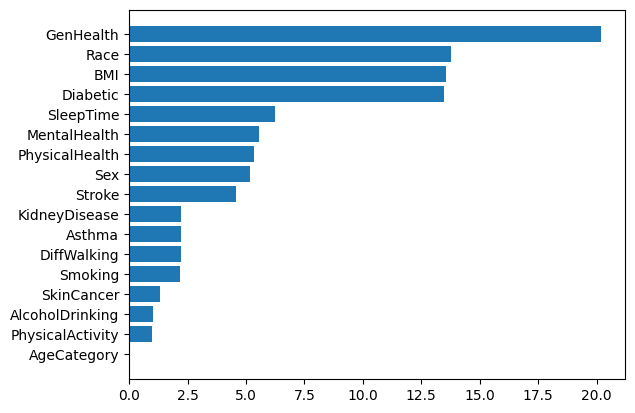

Model for age 80 or older
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.92      0.34      0.49      3700
           1       0.28      0.89      0.42      1060

    accuracy                           0.46      4760
   macro avg       0.60      0.62      0.46      4760
weighted avg       0.77      0.46      0.48      4760



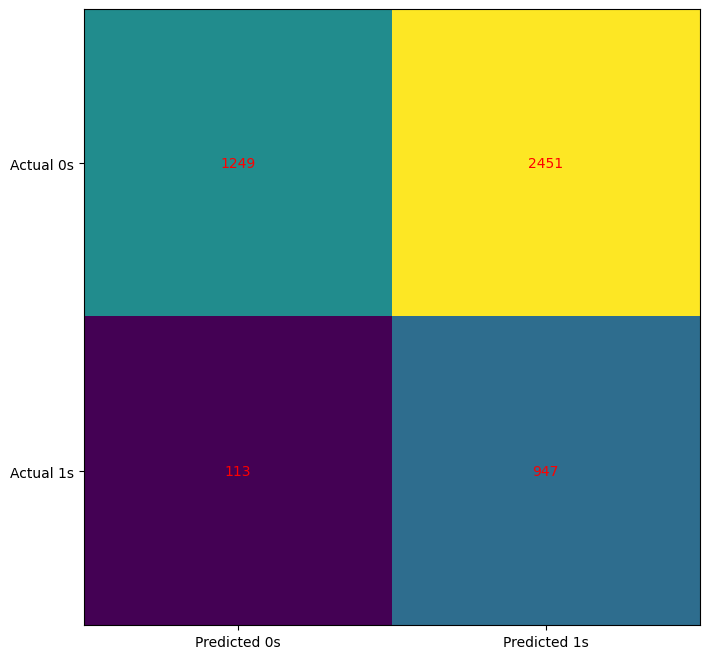

            Features  Importance
13               BMI   15.847114
9          GenHealth   15.824617
11          Diabetic   12.257009
10              Race   11.191134
16         SleepTime    9.018445
14    PhysicalHealth    6.984428
15      MentalHealth    6.329120
8                Sex    4.711314
2             Stroke    3.857749
6      KidneyDisease    3.219587
3        DiffWalking    2.666784
0            Smoking    2.200632
7         SkinCancer    1.992734
4   PhysicalActivity    1.441902
5             Asthma    1.427476
1    AlcoholDrinking    1.029956
12       AgeCategory    0.000000


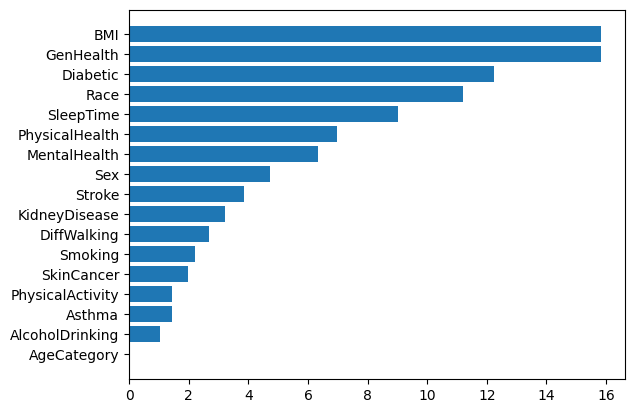

Model for age 65-69
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.94      0.71      0.81      6004
           1       0.23      0.67      0.35       783

    accuracy                           0.71      6787
   macro avg       0.59      0.69      0.58      6787
weighted avg       0.86      0.71      0.76      6787



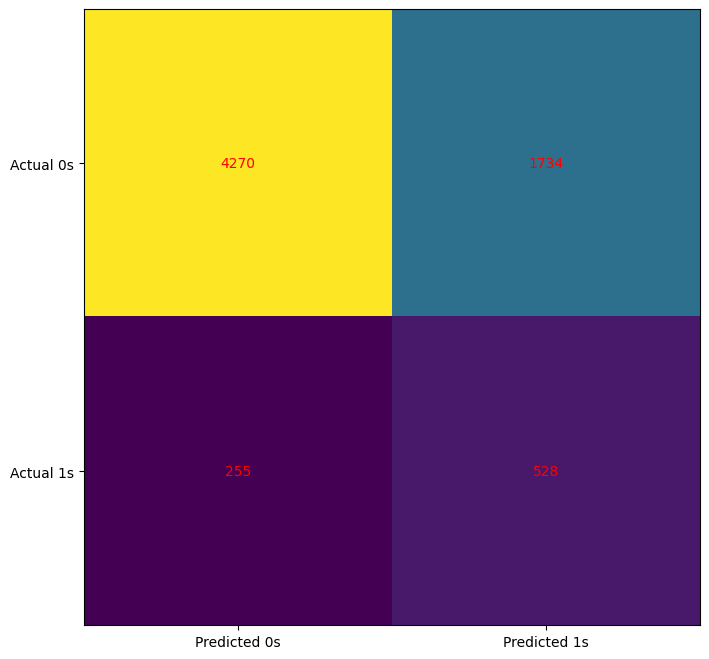

            Features  Importance
9          GenHealth   16.676938
13               BMI   15.493139
10              Race   12.493829
11          Diabetic   11.034241
16         SleepTime    6.756531
14    PhysicalHealth    6.624287
15      MentalHealth    5.837479
8                Sex    5.541094
2             Stroke    3.879095
0            Smoking    3.645947
5             Asthma    2.756868
6      KidneyDisease    2.490897
1    AlcoholDrinking    2.422598
7         SkinCancer    1.590494
3        DiffWalking    1.428326
4   PhysicalActivity    1.328237
12       AgeCategory    0.000000


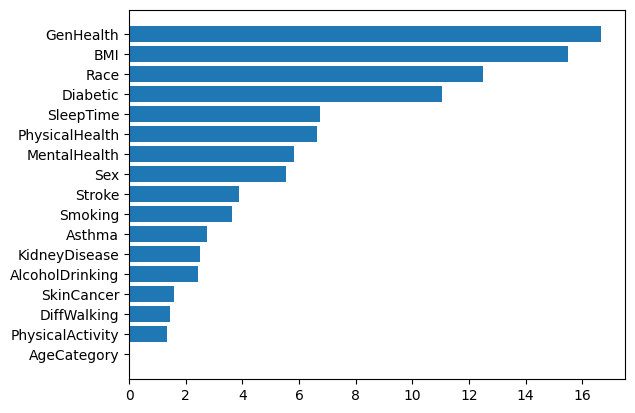

Model for age 75-79
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.93      0.49      0.64      3577
           1       0.26      0.83      0.40       785

    accuracy                           0.55      4362
   macro avg       0.60      0.66      0.52      4362
weighted avg       0.81      0.55      0.60      4362



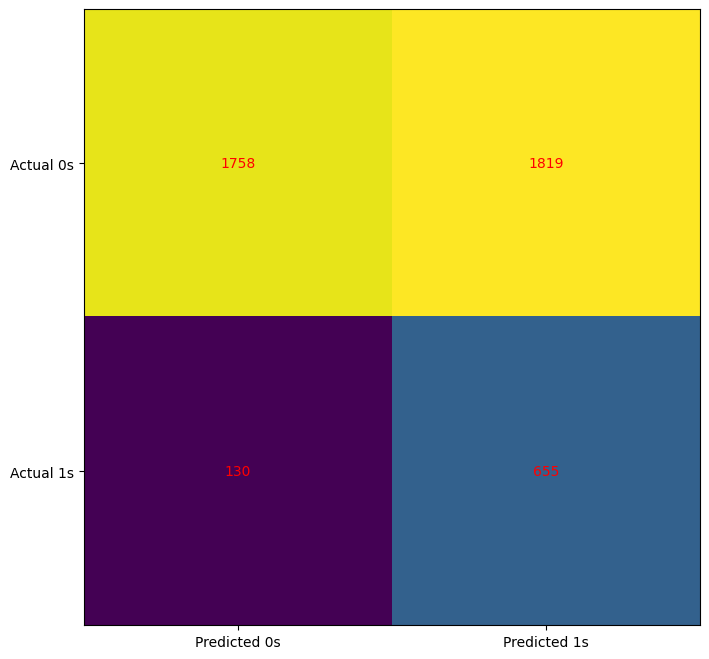

            Features  Importance
9          GenHealth   17.306889
13               BMI   14.392796
11          Diabetic   11.032104
10              Race   10.374015
16         SleepTime    7.533062
14    PhysicalHealth    7.125926
15      MentalHealth    6.679576
8                Sex    5.752936
2             Stroke    4.592676
7         SkinCancer    3.269357
0            Smoking    2.928935
3        DiffWalking    2.269327
6      KidneyDisease    2.162844
5             Asthma    1.616505
1    AlcoholDrinking    1.537317
4   PhysicalActivity    1.425737
12       AgeCategory    0.000000


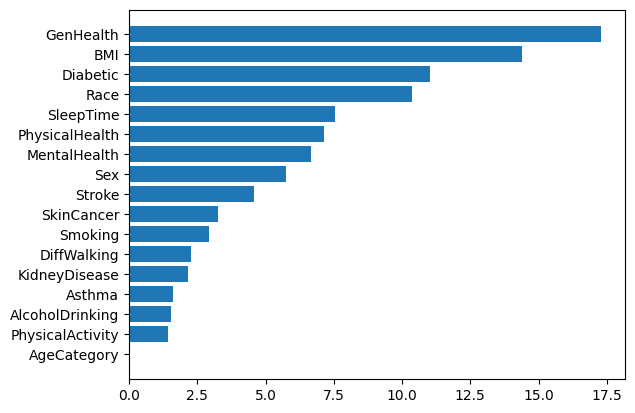

Model for age 40-44
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4108
           1       0.19      0.22      0.21       103

    accuracy                           0.96      4211
   macro avg       0.59      0.60      0.59      4211
weighted avg       0.96      0.96      0.96      4211



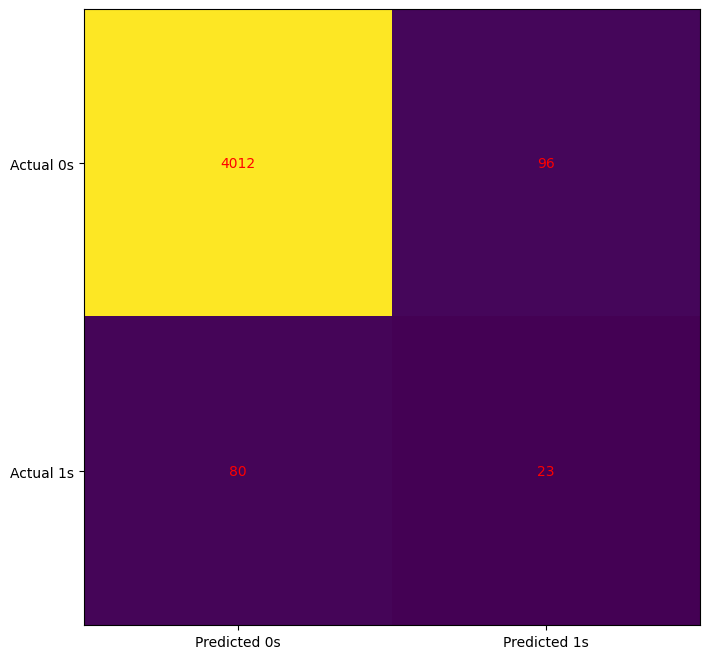

            Features  Importance
9          GenHealth   20.216468
13               BMI   16.608288
10              Race   13.786461
16         SleepTime    9.189871
11          Diabetic    9.016961
14    PhysicalHealth    7.576130
15      MentalHealth    6.791044
8                Sex    3.561680
0            Smoking    3.123735
2             Stroke    2.365470
5             Asthma    2.194490
4   PhysicalActivity    2.190750
3        DiffWalking    1.265998
1    AlcoholDrinking    1.212304
6      KidneyDisease    0.569427
7         SkinCancer    0.330921
12       AgeCategory    0.000000


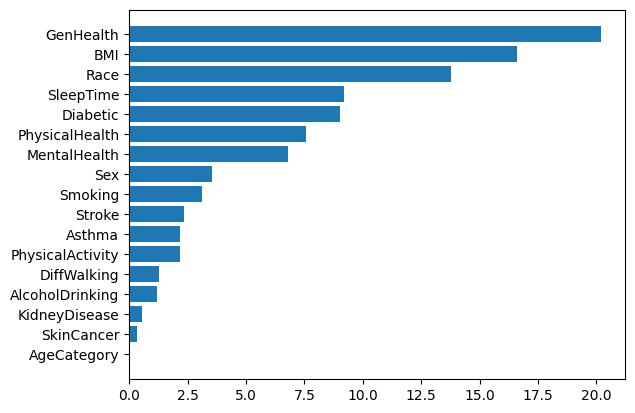

Model for age 70-74
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.92      0.63      0.75      5350
           1       0.26      0.71      0.39       991

    accuracy                           0.65      6341
   macro avg       0.59      0.67      0.57      6341
weighted avg       0.82      0.65      0.69      6341



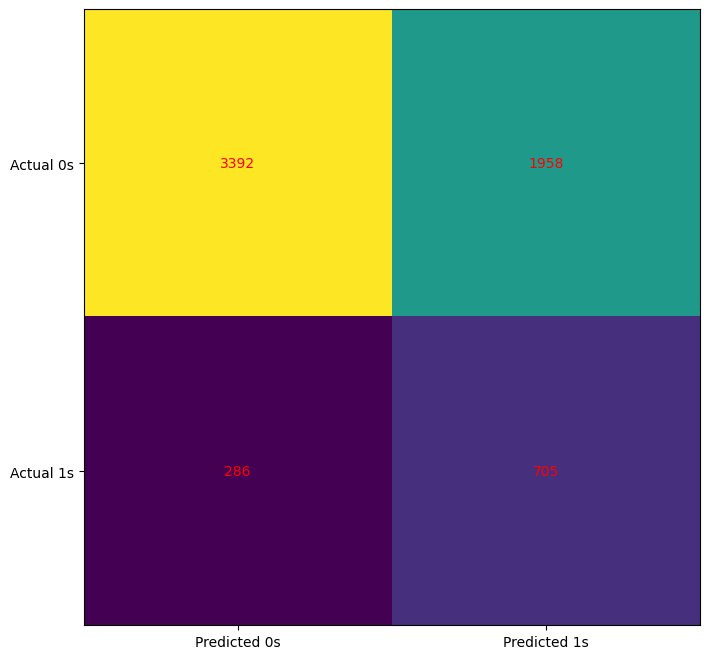

            Features  Importance
9          GenHealth   17.303352
13               BMI   15.723562
10              Race   11.062571
11          Diabetic    9.734586
14    PhysicalHealth    7.290015
16         SleepTime    7.214564
15      MentalHealth    6.791215
8                Sex    5.454720
2             Stroke    4.129011
0            Smoking    3.305432
6      KidneyDisease    2.854481
1    AlcoholDrinking    2.595730
3        DiffWalking    2.336266
7         SkinCancer    1.845959
4   PhysicalActivity    1.445363
5             Asthma    0.913175
12       AgeCategory    0.000000


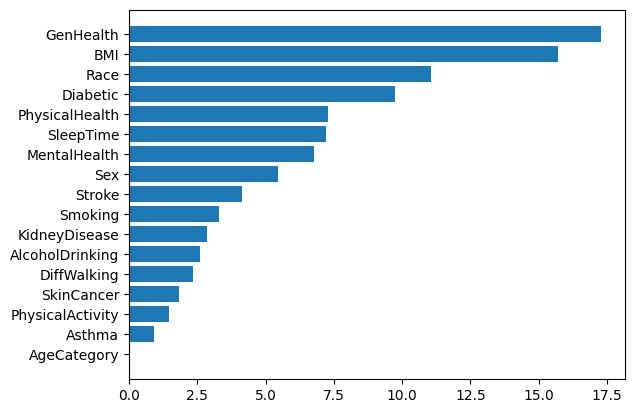

Model for age 60-64
{'depth': 9, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      6151
           1       0.21      0.57      0.31       653

    accuracy                           0.75      6804
   macro avg       0.58      0.67      0.58      6804
weighted avg       0.87      0.75      0.80      6804



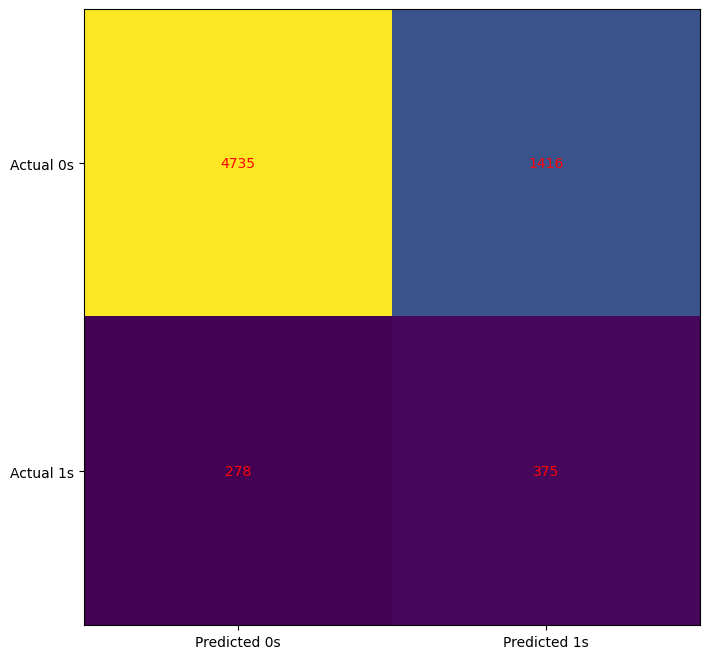

            Features  Importance
9          GenHealth   17.230377
13               BMI   14.474537
11          Diabetic    9.958897
16         SleepTime    9.630399
10              Race    9.232557
8                Sex    6.880212
14    PhysicalHealth    6.842609
15      MentalHealth    6.558741
0            Smoking    4.710783
4   PhysicalActivity    3.039884
3        DiffWalking    2.604062
7         SkinCancer    2.122230
2             Stroke    2.078287
1    AlcoholDrinking    1.736391
5             Asthma    1.607278
6      KidneyDisease    1.292757
12       AgeCategory    0.000000


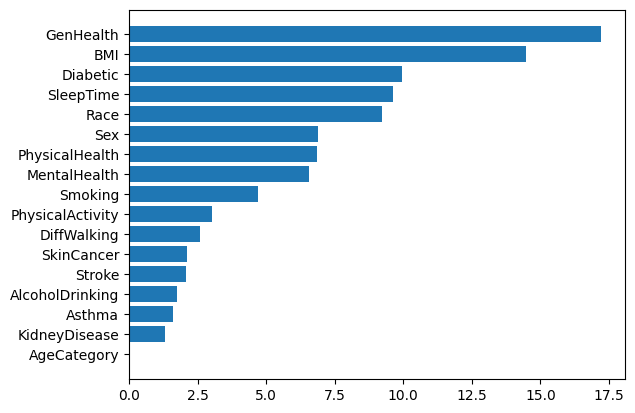

Model for age 50-54
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      4769
           1       0.22      0.47      0.30       291

    accuracy                           0.88      5060
   macro avg       0.59      0.68      0.62      5060
weighted avg       0.92      0.88      0.90      5060



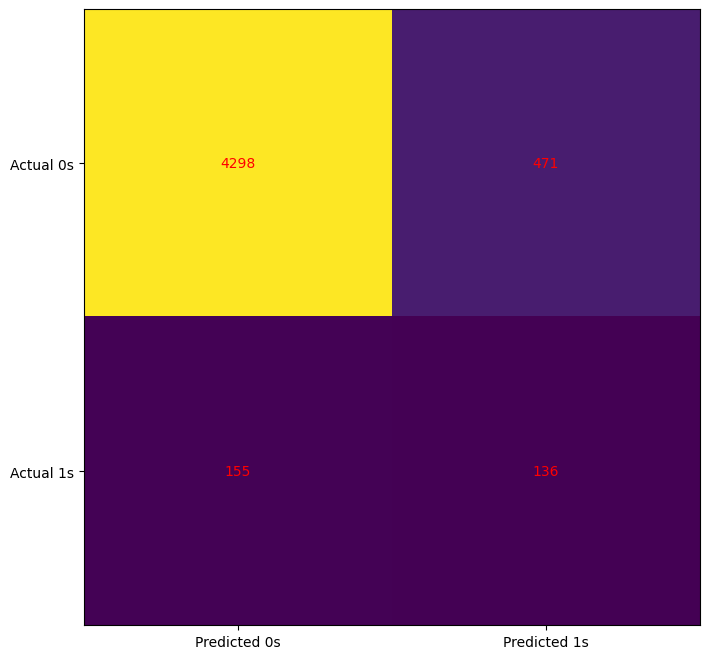

            Features  Importance
9          GenHealth   16.760174
13               BMI   14.997635
10              Race   13.729912
11          Diabetic   11.125318
15      MentalHealth    8.116583
16         SleepTime    7.318357
14    PhysicalHealth    5.956667
8                Sex    4.063893
2             Stroke    3.756462
0            Smoking    3.260287
5             Asthma    2.560468
4   PhysicalActivity    1.999493
7         SkinCancer    1.797681
3        DiffWalking    1.777500
6      KidneyDisease    1.670132
1    AlcoholDrinking    1.109438
12       AgeCategory    0.000000


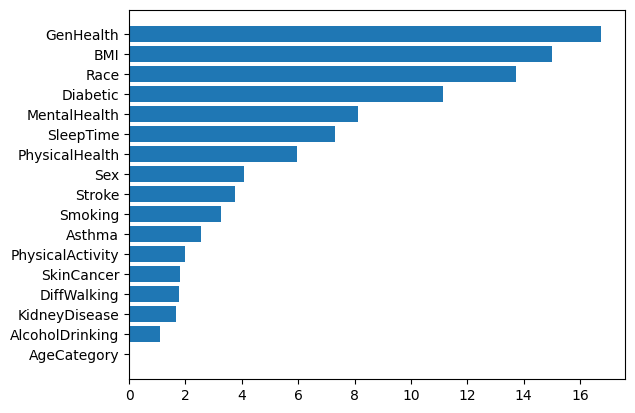

Model for age 45-49
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      4203
           1       0.23      0.38      0.28       152

    accuracy                           0.93      4355
   macro avg       0.60      0.66      0.62      4355
weighted avg       0.95      0.93      0.94      4355



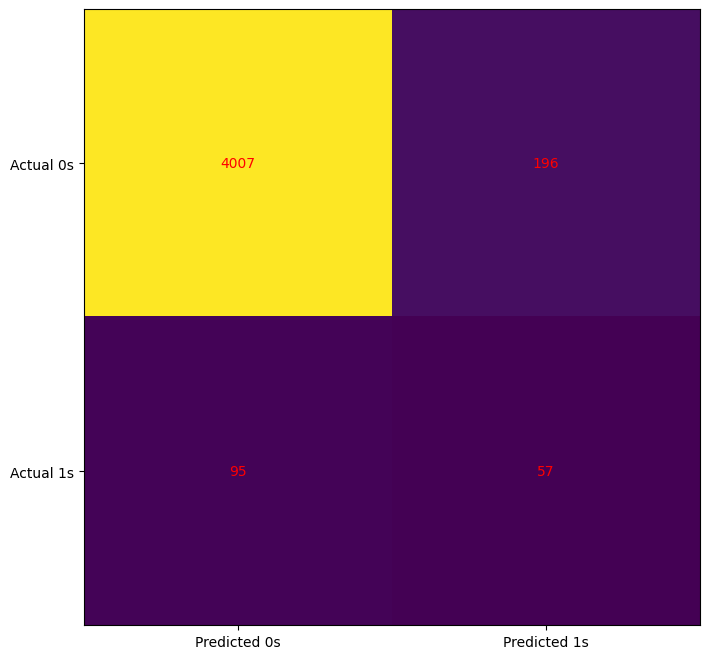

            Features  Importance
9          GenHealth   18.470419
13               BMI   17.741030
10              Race   11.278369
16         SleepTime   11.046741
11          Diabetic    9.665151
15      MentalHealth    7.871108
14    PhysicalHealth    5.089329
8                Sex    4.154076
0            Smoking    2.971295
2             Stroke    2.909722
5             Asthma    2.554294
1    AlcoholDrinking    1.517997
3        DiffWalking    1.465994
7         SkinCancer    1.319223
4   PhysicalActivity    1.192546
6      KidneyDisease    0.752705
12       AgeCategory    0.000000


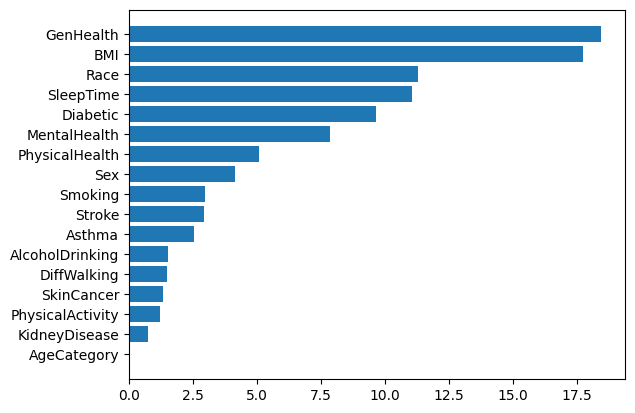

Model for age 18-24
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4122
           1       0.20      0.03      0.06        31

    accuracy                           0.99      4153
   macro avg       0.60      0.52      0.53      4153
weighted avg       0.99      0.99      0.99      4153



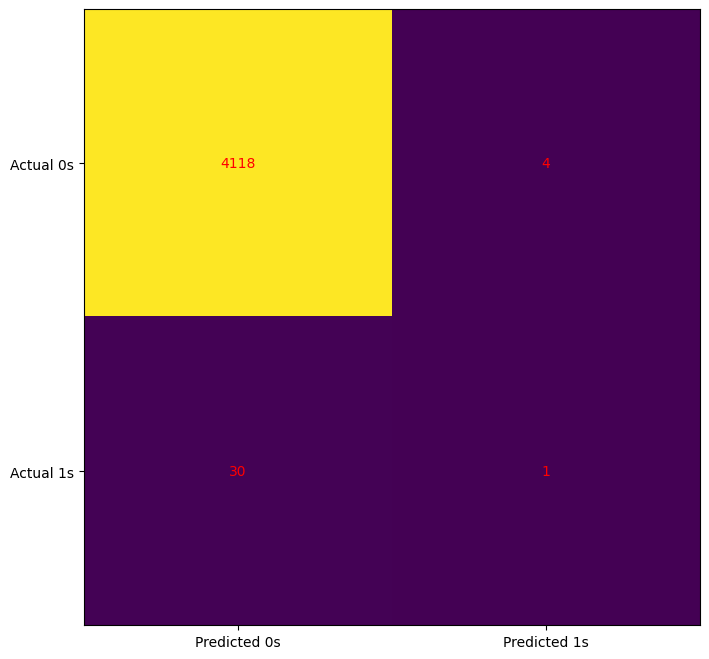

            Features  Importance
13               BMI   23.190740
9          GenHealth   13.204102
16         SleepTime   12.275816
15      MentalHealth   11.838987
10              Race   11.735192
14    PhysicalHealth   10.912810
8                Sex    4.326444
5             Asthma    2.841099
4   PhysicalActivity    2.162391
11          Diabetic    2.016995
0            Smoking    1.999665
1    AlcoholDrinking    1.570009
2             Stroke    0.980825
3        DiffWalking    0.591379
7         SkinCancer    0.224200
6      KidneyDisease    0.129345
12       AgeCategory    0.000000


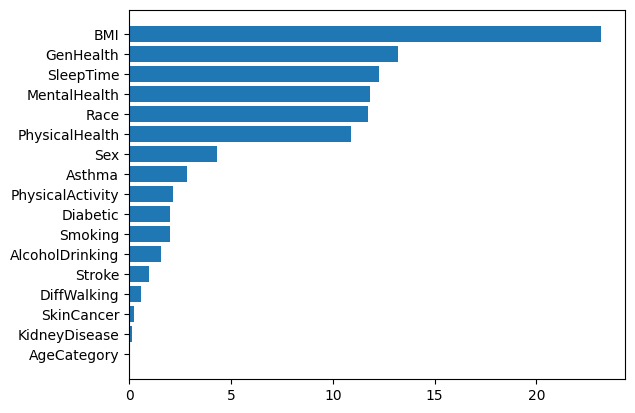

Model for age 35-39
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4128
           1       0.12      0.12      0.12        58

    accuracy                           0.98      4186
   macro avg       0.55      0.55      0.55      4186
weighted avg       0.98      0.98      0.98      4186



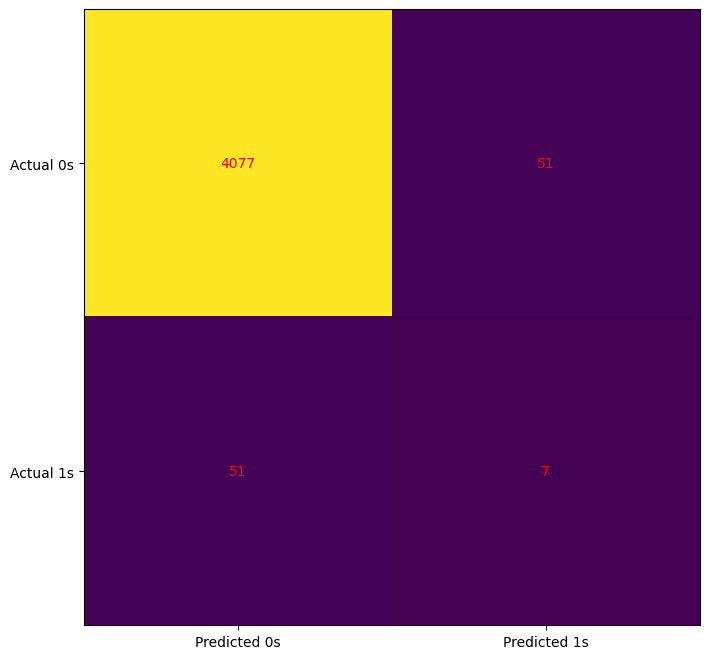

            Features  Importance
13               BMI   21.012632
9          GenHealth   18.816529
10              Race   11.637382
16         SleepTime   10.191590
15      MentalHealth   10.049976
11          Diabetic    6.854546
14    PhysicalHealth    4.836129
8                Sex    3.979627
0            Smoking    3.752293
4   PhysicalActivity    2.612076
5             Asthma    2.401473
1    AlcoholDrinking    1.079980
3        DiffWalking    1.035055
2             Stroke    0.877713
6      KidneyDisease    0.465013
7         SkinCancer    0.397987
12       AgeCategory    0.000000


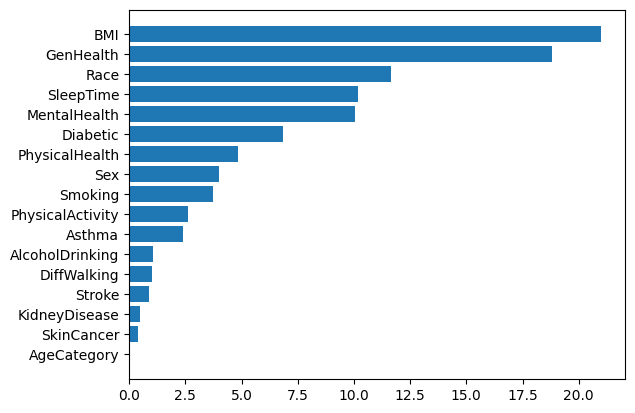

Model for age 30-34
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3632
           1       0.08      0.05      0.06        43

    accuracy                           0.98      3675
   macro avg       0.53      0.52      0.53      3675
weighted avg       0.98      0.98      0.98      3675



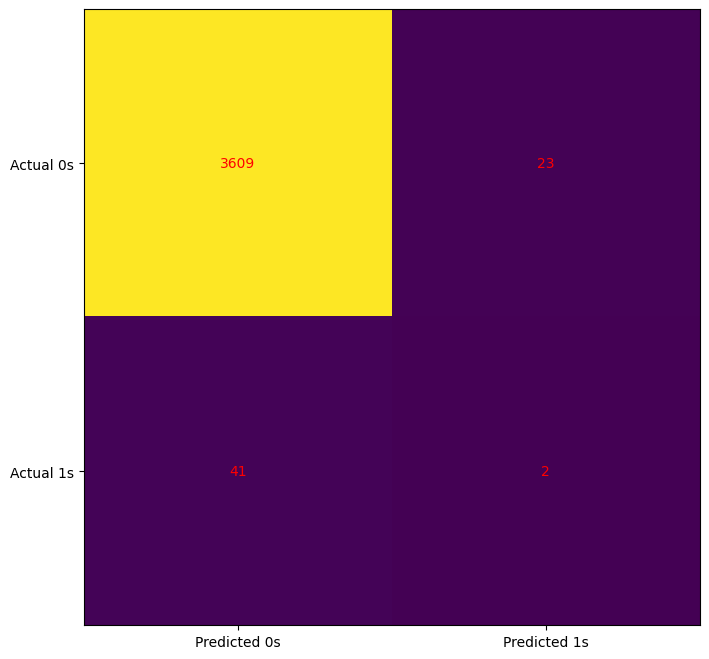

            Features  Importance
13               BMI   20.551475
9          GenHealth   15.303210
10              Race   12.398501
16         SleepTime   10.970162
15      MentalHealth    7.323726
8                Sex    5.494100
14    PhysicalHealth    5.472629
11          Diabetic    5.390574
0            Smoking    4.878111
5             Asthma    3.334199
1    AlcoholDrinking    3.139393
4   PhysicalActivity    2.933577
3        DiffWalking    1.670373
2             Stroke    0.882484
6      KidneyDisease    0.211233
7         SkinCancer    0.046252
12       AgeCategory    0.000000


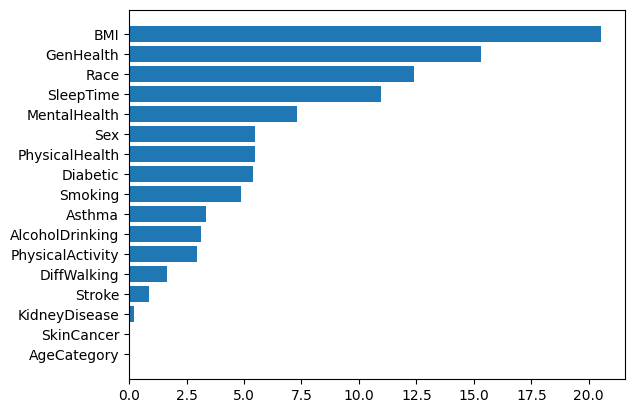

Model for age 25-29
{'depth': 9, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3419
           1       0.00      0.00      0.00        22

    accuracy                           0.99      3441
   macro avg       0.50      0.50      0.50      3441
weighted avg       0.99      0.99      0.99      3441



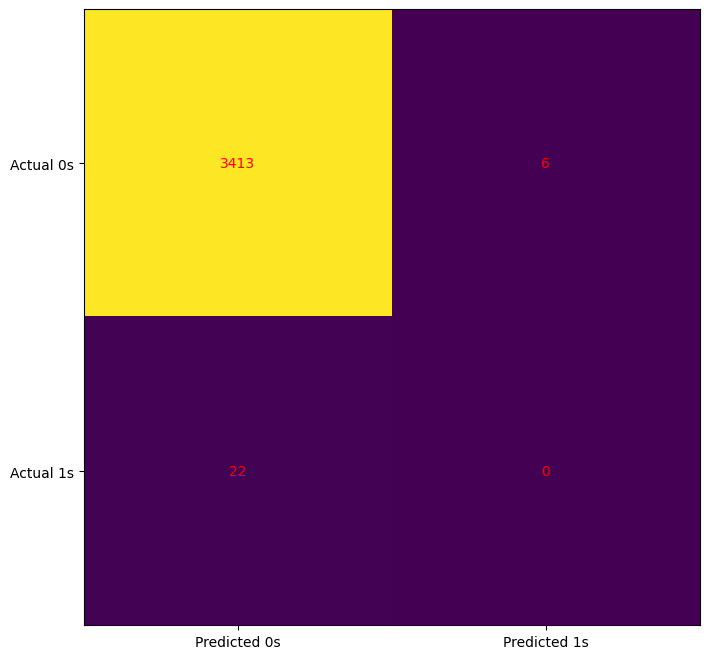

            Features  Importance
9          GenHealth   17.227442
13               BMI   15.019856
10              Race   13.109777
15      MentalHealth   12.982659
16         SleepTime   11.628925
14    PhysicalHealth    5.666157
11          Diabetic    5.273393
5             Asthma    4.646809
8                Sex    4.508083
0            Smoking    4.232986
4   PhysicalActivity    2.862100
1    AlcoholDrinking    1.939018
2             Stroke    0.526240
3        DiffWalking    0.311436
6      KidneyDisease    0.044582
7         SkinCancer    0.020536
12       AgeCategory    0.000000


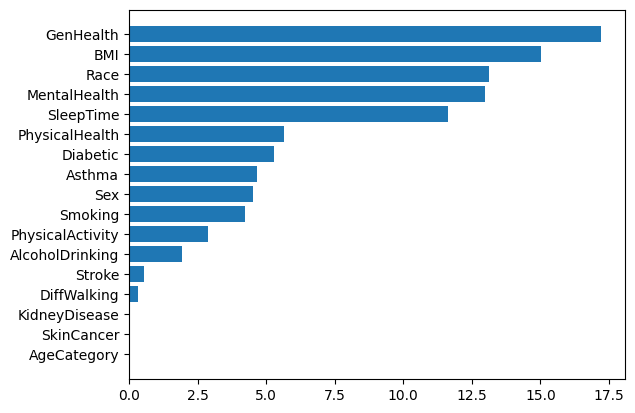

In [ ]:

# Select Features
cat_features = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer', 'Sex', 'GenHealth', 'Race', 'Diabetic', 'AgeCategory' ]
num_features = ['BMI',	'PhysicalHealth',	'MentalHealth',	'SleepTime']
goal = 'HeartDisease_num'

# Train - Test division
X_train, y_train, X_test, y_test = create_train_test(data, cat_features, num_features, goal)

# Downsampling
#X_train_balanced, y_train_balanced = downsampling(X_train, y_train, percentage)

X_train_balanced = pd.read_csv("X_train_balanced_90.csv")
X_train_balanced = X_train_balanced[cat_features + num_features]
y_train_balanced = pd.read_csv("y_train_balanced_90.csv")

for i in range(0,len(cat_features)):
    X_train_balanced[cat_features[i]] = X_train_balanced[cat_features[i]].astype("category")

for agecat in data['AgeCategory'].unique():

  print("Model for age " + agecat)

  X_train_balanced['HeartDisease_num'] = y_train_balanced['HeartDisease_num']
  X_test['HeartDisease_num'] = y_test['HeartDisease_num']

  X_train_balanced_age = X_train_balanced[ X_train_balanced['AgeCategory'] == agecat ]
  X_test_age = X_test[ X_test['AgeCategory'] == agecat ]

  #y_train_balanced_age = y_train_balanced
  #y_test_age = y_test

  y_train_balanced_age = pd.DataFrame()
  y_test_age = pd.DataFrame()

  y_train_balanced_age['HeartDisease_num'] = X_train_balanced_age['HeartDisease_num']
  y_test_age['HeartDisease_num'] = X_test_age['HeartDisease_num']

  X_train_balanced_age.drop(['HeartDisease_num'], inplace=True, axis=1)
  X_test_age.drop(['HeartDisease_num'], inplace=True, axis=1)

  # Hyperparameter selection + Cross Validation / training
  best_cat, y_pred = create_catboost_model(X_train_balanced_age, y_train_balanced_age, X_test_age, y_test_age, cat_features)

  # Model results
  evaluate_model(best_cat, y_test_age, y_pred)

#### Divide by Age chunks variables that can be changed

Model for age 55-59
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      5413
           1       0.19      0.48      0.27       411

    accuracy                           0.82      5824
   macro avg       0.57      0.66      0.58      5824
weighted avg       0.90      0.82      0.85      5824



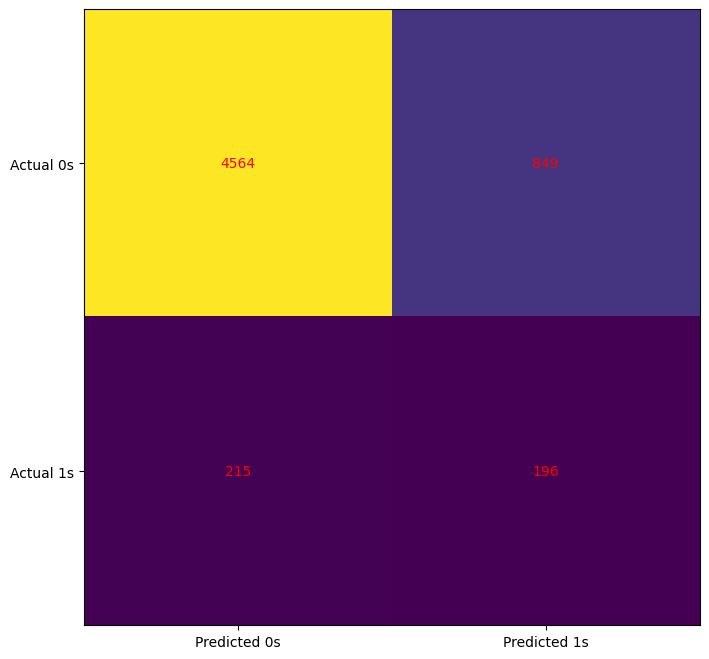

           Features  Importance
3         GenHealth   25.595099
5               BMI   25.588457
8         SleepTime   13.613636
6    PhysicalHealth   11.461463
7      MentalHealth   10.768368
2  PhysicalActivity    4.543041
1   AlcoholDrinking    4.299171
0           Smoking    4.130765
4       AgeCategory    0.000000


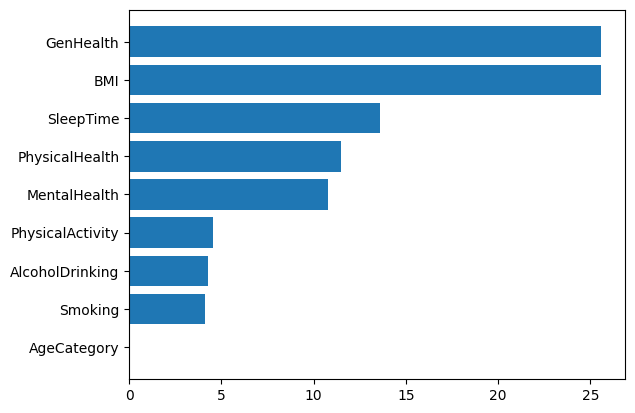

Model for age 80 or older
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.90      0.24      0.38      3700
           1       0.26      0.91      0.40      1060

    accuracy                           0.39      4760
   macro avg       0.58      0.58      0.39      4760
weighted avg       0.76      0.39      0.38      4760



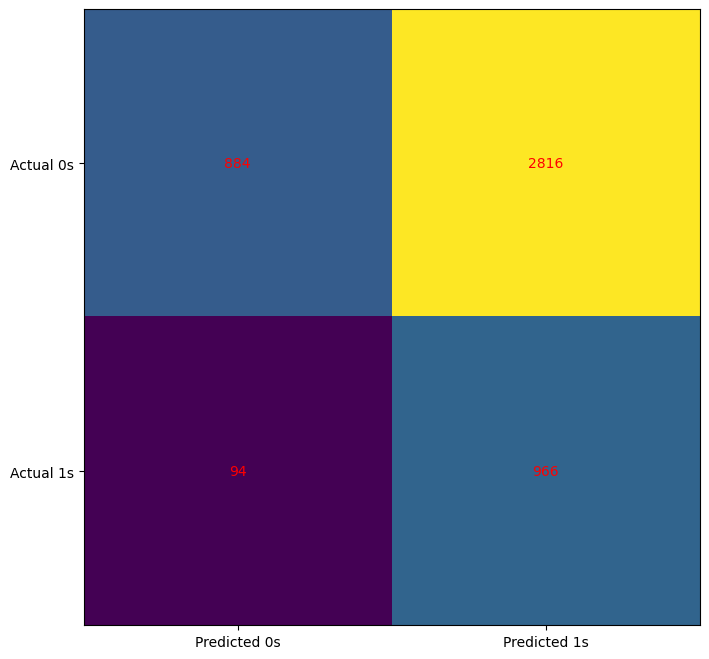

           Features  Importance
3         GenHealth   24.757448
5               BMI   22.747342
8         SleepTime   14.608862
6    PhysicalHealth   12.843669
7      MentalHealth   11.481813
0           Smoking    5.115205
1   AlcoholDrinking    4.515352
2  PhysicalActivity    3.930310
4       AgeCategory    0.000000


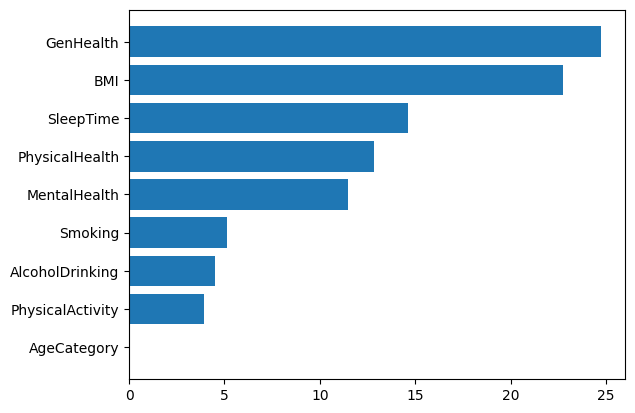

Model for age 65-69
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.94      0.71      0.81      6004
           1       0.22      0.63      0.33       783

    accuracy                           0.70      6787
   macro avg       0.58      0.67      0.57      6787
weighted avg       0.85      0.70      0.75      6787



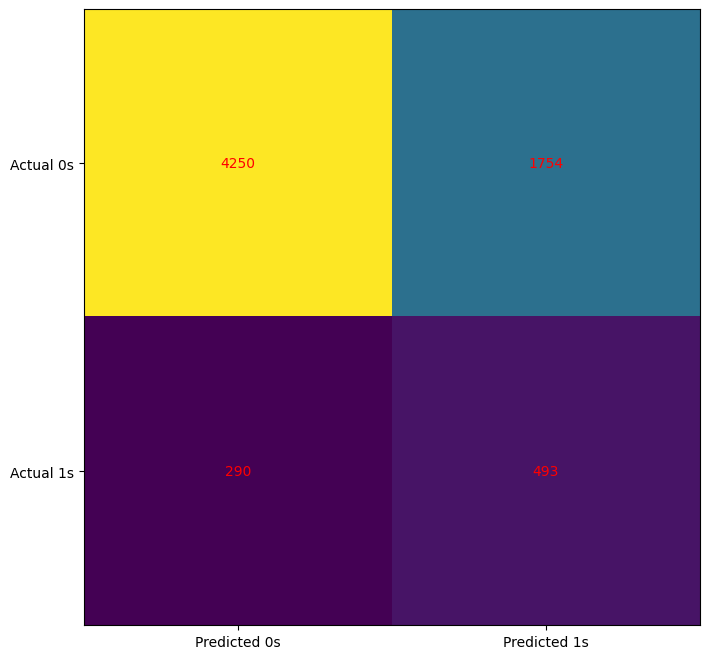

           Features  Importance
3         GenHealth   26.496906
5               BMI   24.865907
8         SleepTime   13.335672
6    PhysicalHealth   11.059869
7      MentalHealth   10.075049
0           Smoking    5.843850
1   AlcoholDrinking    4.543160
2  PhysicalActivity    3.779586
4       AgeCategory    0.000000


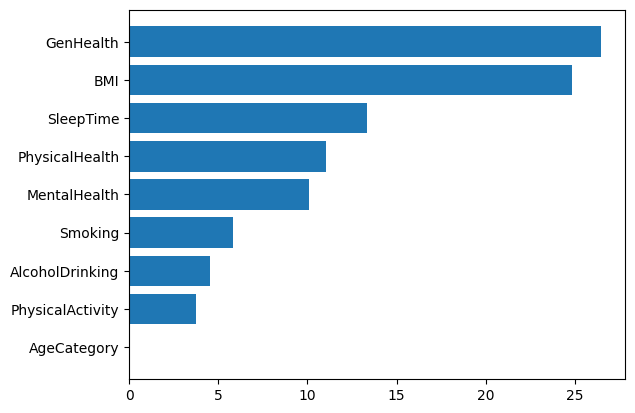

Model for age 75-79
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.91      0.42      0.57      3577
           1       0.24      0.82      0.37       785

    accuracy                           0.49      4362
   macro avg       0.57      0.62      0.47      4362
weighted avg       0.79      0.49      0.54      4362



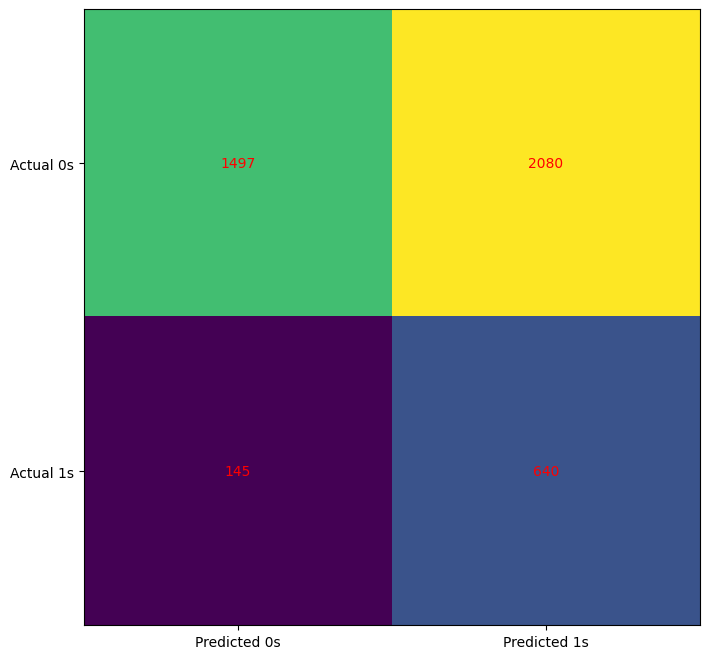

           Features  Importance
3         GenHealth   24.796605
5               BMI   24.432930
8         SleepTime   15.285405
6    PhysicalHealth   11.378299
7      MentalHealth   10.974866
0           Smoking    5.279045
2  PhysicalActivity    4.347736
1   AlcoholDrinking    3.505115
4       AgeCategory    0.000000


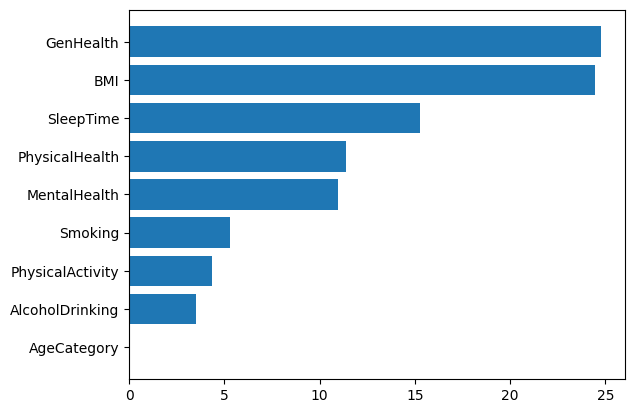

Model for age 40-44
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      4108
           1       0.15      0.22      0.18       103

    accuracy                           0.95      4211
   macro avg       0.56      0.60      0.58      4211
weighted avg       0.96      0.95      0.95      4211



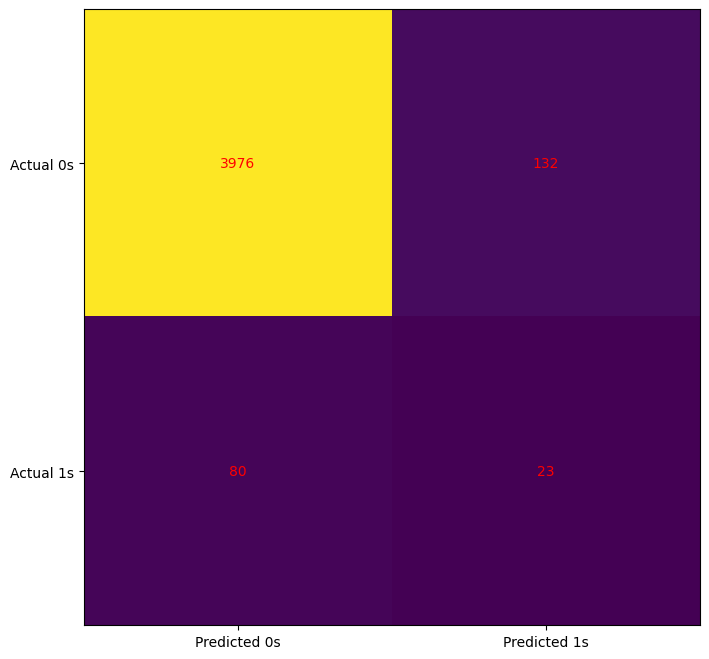

           Features  Importance
5               BMI   27.760541
3         GenHealth   23.340395
8         SleepTime   13.060119
7      MentalHealth   11.351220
6    PhysicalHealth   11.307331
0           Smoking    6.020696
2  PhysicalActivity    3.997141
1   AlcoholDrinking    3.162557
4       AgeCategory    0.000000


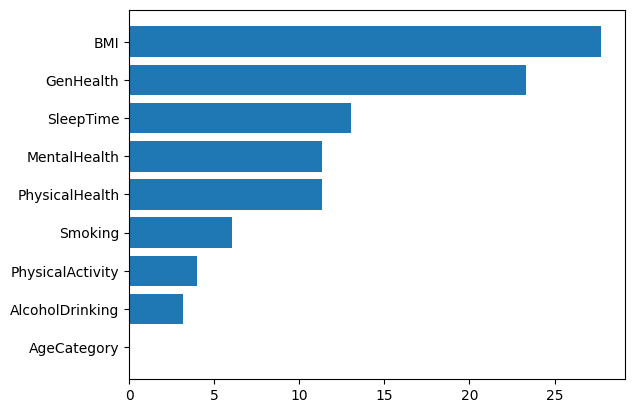

Model for age 70-74
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.92      0.56      0.69      5350
           1       0.23      0.72      0.35       991

    accuracy                           0.58      6341
   macro avg       0.57      0.64      0.52      6341
weighted avg       0.81      0.58      0.64      6341



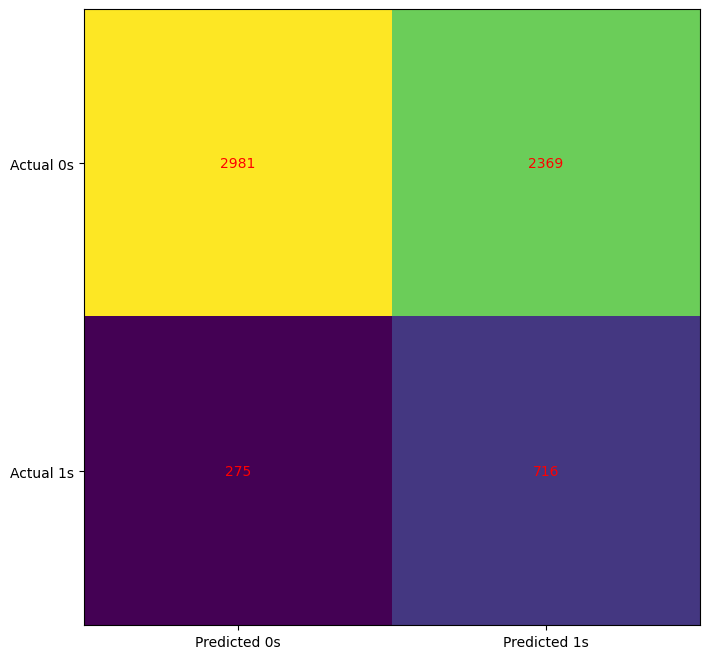

           Features  Importance
3         GenHealth   25.701567
5               BMI   25.003430
8         SleepTime   14.402551
6    PhysicalHealth   11.102316
7      MentalHealth   10.311757
0           Smoking    5.935489
2  PhysicalActivity    3.773911
1   AlcoholDrinking    3.768978
4       AgeCategory    0.000000


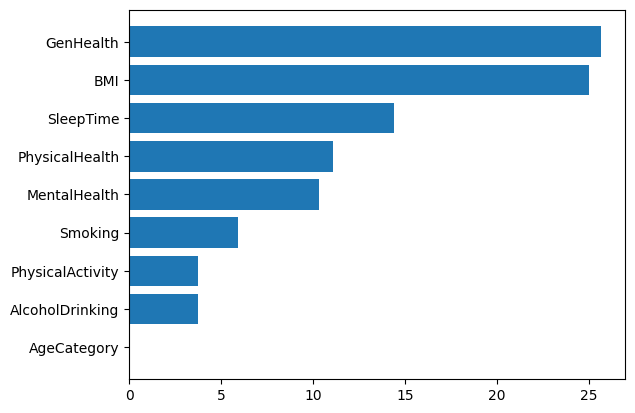

Model for age 60-64
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      6151
           1       0.21      0.53      0.30       653

    accuracy                           0.76      6804
   macro avg       0.58      0.66      0.58      6804
weighted avg       0.87      0.76      0.81      6804



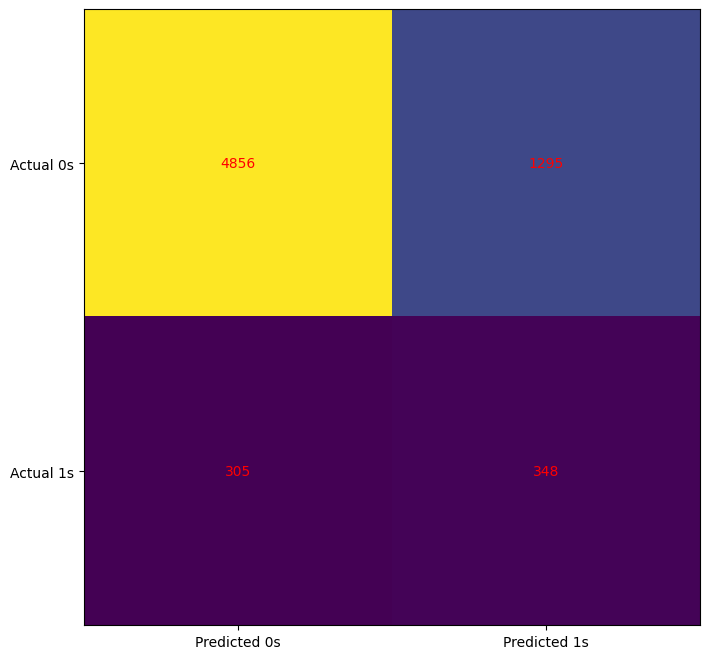

           Features  Importance
3         GenHealth   25.903925
5               BMI   22.674848
8         SleepTime   15.373153
7      MentalHealth   11.754763
6    PhysicalHealth   10.738692
0           Smoking    5.219835
1   AlcoholDrinking    4.648914
2  PhysicalActivity    3.685870
4       AgeCategory    0.000000


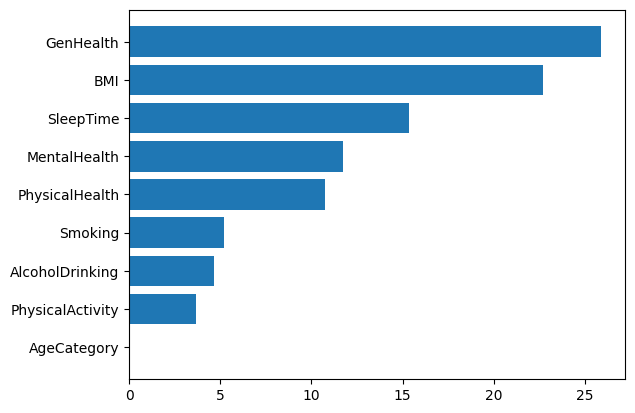

Model for age 50-54
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.96      0.89      0.93      4769
           1       0.18      0.37      0.24       291

    accuracy                           0.86      5060
   macro avg       0.57      0.63      0.58      5060
weighted avg       0.91      0.86      0.89      5060



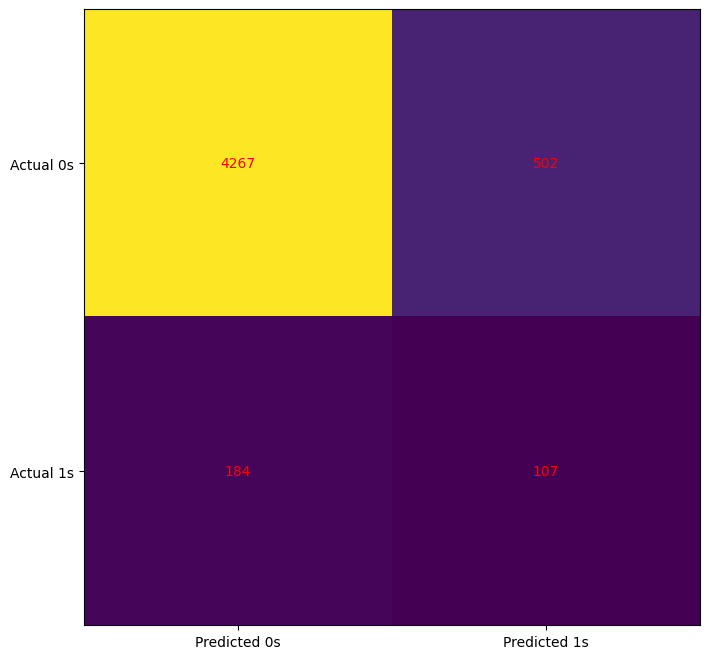

           Features  Importance
3         GenHealth   26.209902
5               BMI   25.949290
8         SleepTime   12.921398
7      MentalHealth   12.152784
6    PhysicalHealth   10.153091
0           Smoking    4.859094
2  PhysicalActivity    4.088265
1   AlcoholDrinking    3.666176
4       AgeCategory    0.000000


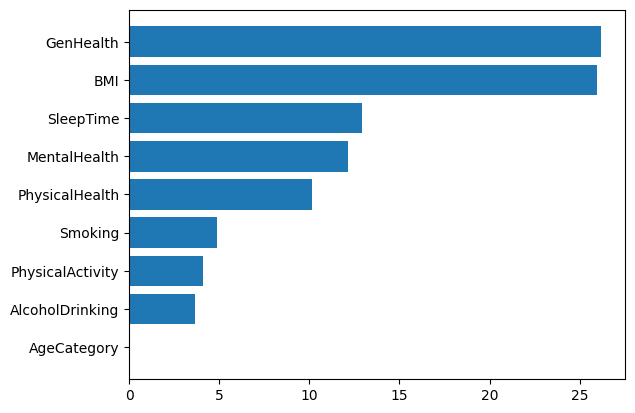

Model for age 45-49
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      4203
           1       0.16      0.29      0.21       152

    accuracy                           0.92      4355
   macro avg       0.57      0.62      0.58      4355
weighted avg       0.95      0.92      0.93      4355



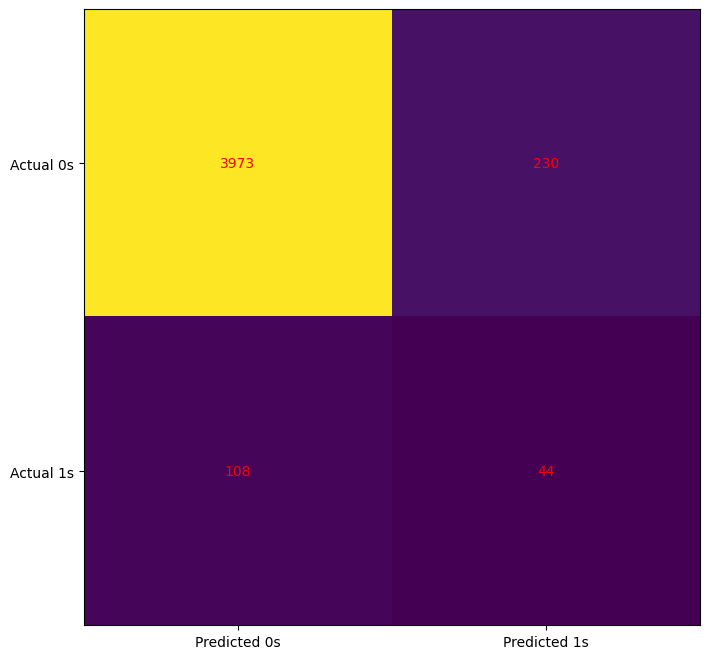

           Features  Importance
5               BMI   27.066380
3         GenHealth   23.465572
8         SleepTime   14.375074
7      MentalHealth   11.975876
6    PhysicalHealth   10.823064
0           Smoking    5.528665
2  PhysicalActivity    3.974042
1   AlcoholDrinking    2.791328
4       AgeCategory    0.000000


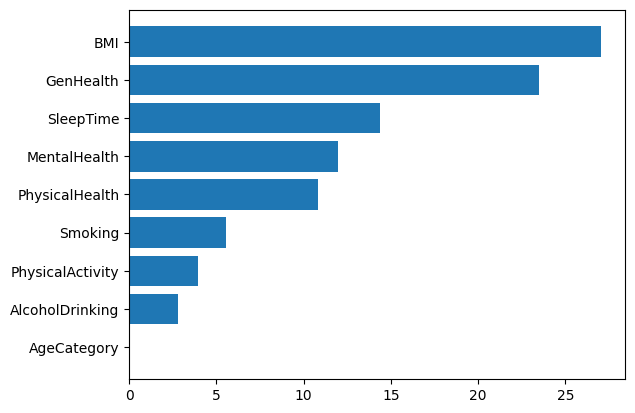

Model for age 18-24
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4122
           1       0.00      0.00      0.00        31

    accuracy                           0.99      4153
   macro avg       0.50      0.50      0.50      4153
weighted avg       0.99      0.99      0.99      4153



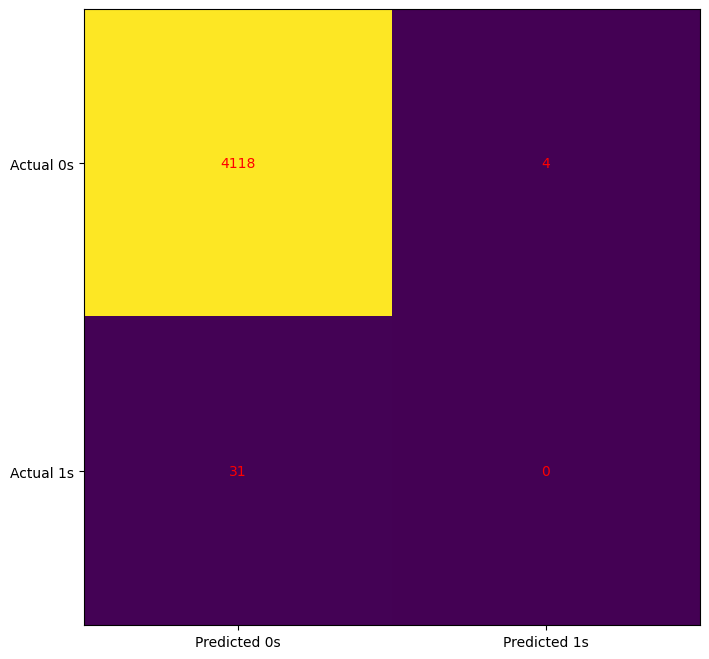

           Features  Importance
5               BMI   26.912788
7      MentalHealth   18.227414
3         GenHealth   15.989198
8         SleepTime   14.000646
6    PhysicalHealth   10.939172
0           Smoking    7.421195
1   AlcoholDrinking    3.819077
2  PhysicalActivity    2.690509
4       AgeCategory    0.000000


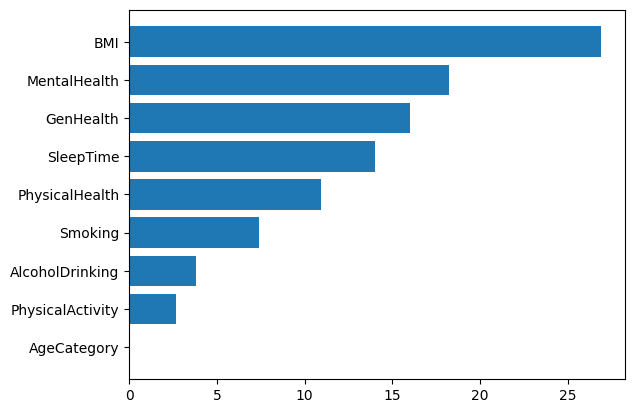

Model for age 35-39
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      4128
           1       0.04      0.05      0.05        58

    accuracy                           0.97      4186
   macro avg       0.51      0.52      0.52      4186
weighted avg       0.97      0.97      0.97      4186



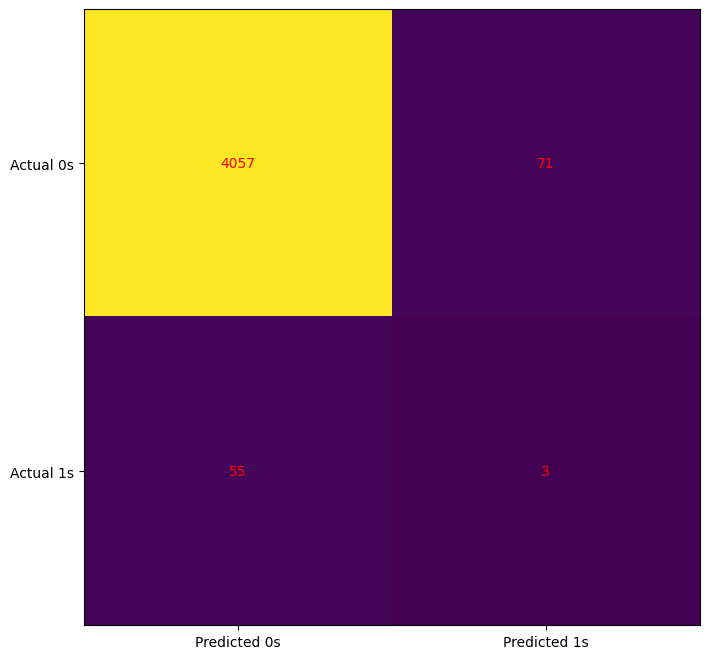

           Features  Importance
5               BMI   27.832490
3         GenHealth   19.786994
8         SleepTime   14.480641
7      MentalHealth   13.964098
6    PhysicalHealth    9.736343
2  PhysicalActivity    5.685514
0           Smoking    5.369568
1   AlcoholDrinking    3.144352
4       AgeCategory    0.000000


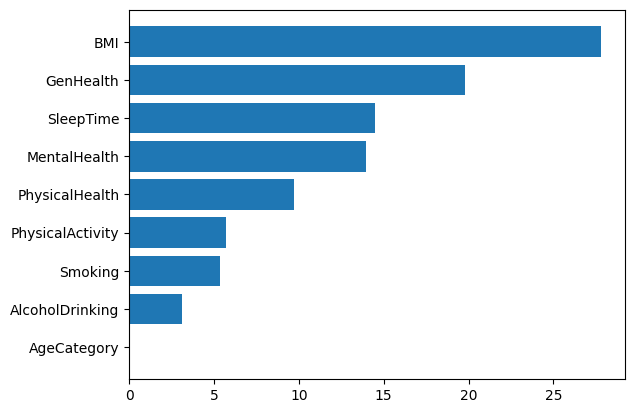

Model for age 30-34
{'depth': 9, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3632
           1       0.00      0.00      0.00        43

    accuracy                           0.98      3675
   macro avg       0.49      0.49      0.49      3675
weighted avg       0.98      0.98      0.98      3675



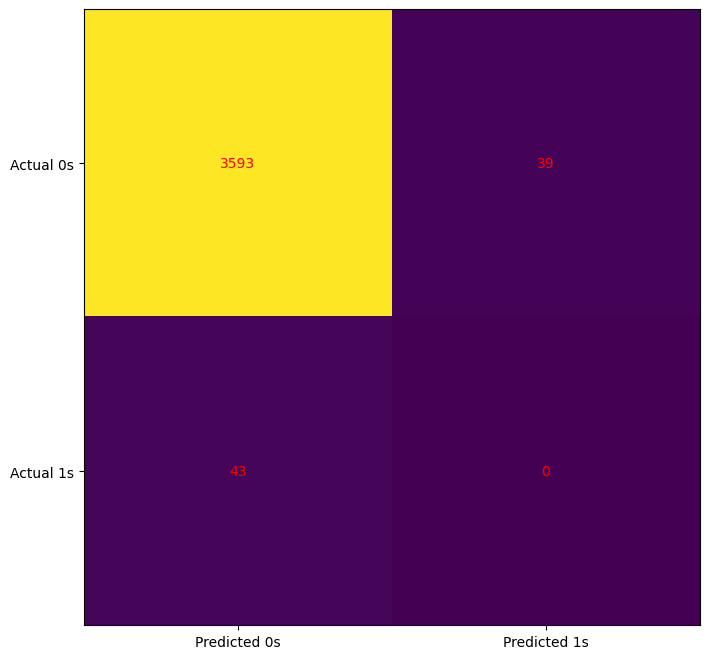

           Features  Importance
5               BMI   22.245286
3         GenHealth   18.457750
7      MentalHealth   16.002138
8         SleepTime   14.756025
0           Smoking    9.599410
6    PhysicalHealth    8.481133
2  PhysicalActivity    5.900977
1   AlcoholDrinking    4.557281
4       AgeCategory    0.000000


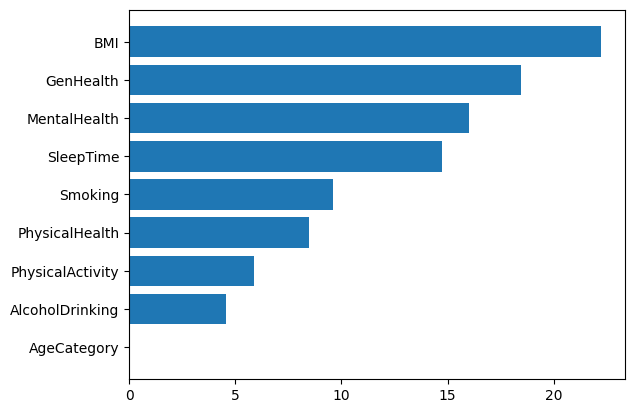

Model for age 25-29
{'depth': 6, 'eval_metric': 'Accuracy', 'iterations': 50, 'l2_leaf_reg': 1e-20, 'leaf_estimation_iterations': 10, 'logging_level': 'Silent', 'loss_function': 'Logloss', 'random_seed': 42}
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3419
           1       0.00      0.00      0.00        22

    accuracy                           0.99      3441
   macro avg       0.50      0.50      0.50      3441
weighted avg       0.99      0.99      0.99      3441



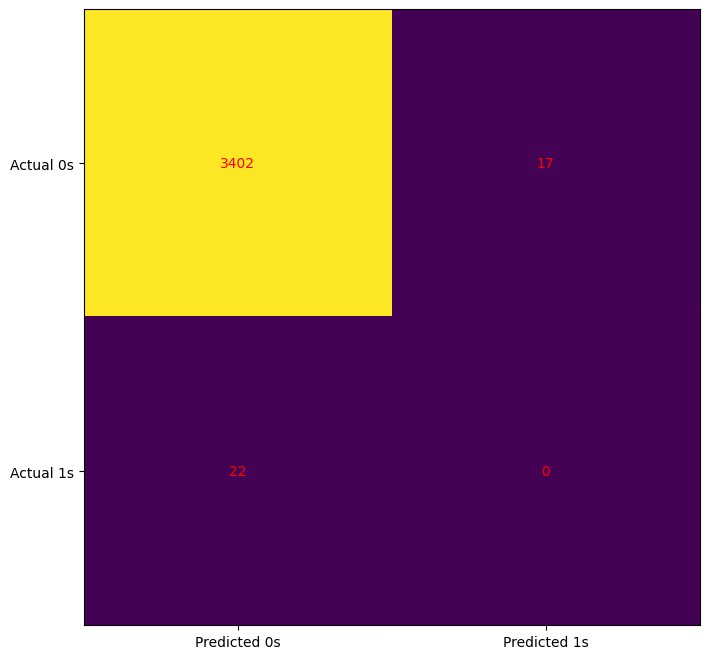

           Features  Importance
5               BMI   26.389089
3         GenHealth   24.478960
7      MentalHealth   14.207993
8         SleepTime   12.069194
6    PhysicalHealth   10.086719
0           Smoking    5.298375
2  PhysicalActivity    4.174972
1   AlcoholDrinking    3.294698
4       AgeCategory    0.000000


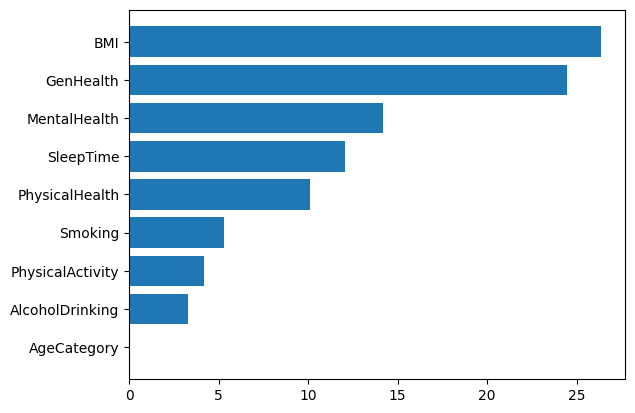

In [ ]:
# Select Features
cat_features = ['Smoking', 'AlcoholDrinking', 'PhysicalActivity', 'GenHealth', 'AgeCategory' ]
num_features = ['BMI',	'PhysicalHealth',	'MentalHealth',	'SleepTime']
goal = 'HeartDisease_num'

# Train - Test division
X_train, y_train, X_test, y_test = create_train_test(data, cat_features, num_features, goal)

# Downsampling
#X_train_balanced, y_train_balanced = downsampling(X_train, y_train, percentage)

X_train_balanced = pd.read_csv("X_train_balanced_90.csv")
X_train_balanced = X_train_balanced[cat_features + num_features]
y_train_balanced = pd.read_csv("y_train_balanced_90.csv")

for i in range(0,len(cat_features)):
    X_train_balanced[cat_features[i]] = X_train_balanced[cat_features[i]].astype("category")

for agecat in data['AgeCategory'].unique():

  print("Model for age " + agecat)

  X_train_balanced['HeartDisease_num'] = y_train_balanced['HeartDisease_num']
  X_test['HeartDisease_num'] = y_test['HeartDisease_num']

  X_train_balanced_age = X_train_balanced[ X_train_balanced['AgeCategory'] == agecat ]
  X_test_age = X_test[ X_test['AgeCategory'] == agecat ]

  #y_train_balanced_age = y_train_balanced
  #y_test_age = y_test

  y_train_balanced_age = pd.DataFrame()
  y_test_age = pd.DataFrame()

  y_train_balanced_age['HeartDisease_num'] = X_train_balanced_age['HeartDisease_num']
  y_test_age['HeartDisease_num'] = X_test_age['HeartDisease_num']

  X_train_balanced_age.drop(['HeartDisease_num'], inplace=True, axis=1)
  X_test_age.drop(['HeartDisease_num'], inplace=True, axis=1)

  # Hyperparameter selection + Cross Validation / training
  best_cat, y_pred = create_catboost_model(X_train_balanced_age, y_train_balanced_age, X_test_age, y_test_age, cat_features)

  # Model results
  evaluate_model(best_cat, y_test_age, y_pred)

### Random Forest

A continuación realizaremos 5 modelos distintos de Random Forest utilizando distintas técnicas de desbalanceo de datos y escogiendo distintas variables:
- Modelo 0: utilizaremos todas las variables que teníamos inicialmente más las que hemos creado durante el preprocesamiento anterior pero en esta primera aproximación no aplicaremos ninguna técnica de debalanceo.
- Modelo 1:  utilizaremos solo las variables del dataset inicial sin preprocesar y aplicaremos la técnica de undersampling con un porcentaje del 70%.
- Modelo 2: : utilizaremos solo las variables del dataset inicial sin preprocesar y aplicaremos la técnica de undersampling con un porcentaje del 90%.
- Modelo 3: utilizaremos las mismas variables del modelo 1 (todas) pero también aplicaremos el desblanceo 50-50 para tener el mismo numero de instancias en cada clase.
- Model 4: utilizaremos solo aquellas variables que dependen del paciente y por tanto puede cambiar (fumar, beber, hacer ejercicio, etc...). También aplicaremos la técnica de desbalanceo de datos para tener el mismo número de instancias en ambas clases (50 - 50).
- Modelo 5: : utilizaremos las variables que en el análisis de los datos anterior hemos visto que tenían más importancia, en relación a la variable objetivo, y aplicaremos la técnica de undersmapling del 90%.

### Model 0

#### Dataset pre-processing

In [ ]:
X_train_rf0 = train_data_preprocessed.drop(['HeartDisease'], axis = 1)
y_train_rf0 = train_data_preprocessed['HeartDisease']
X_test_rf0 = test_data_preprocessed.drop(['HeartDisease'], axis = 1)
y_test_rf0 = test_data_preprocessed['HeartDisease']

In [ ]:
y_train_rf0.value_counts()

0    233938
1     21898
Name: HeartDisease, dtype: int64

- **Ordinal encoder**

In [ ]:
# variables que queremos codificar usando ordinal encoder
oe_cols  = ['BMI_cat','SleepTime_cat','GenHealth','AgeCategory']

# Define the order of the categories for each column
GenHealth_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
BMI_cat_order = ['Bajo Peso', 'Normal', 'Sobrepeso', 'Obesidad']
SleepTime_cat_order = ['<5', '5-7', '7-9', '>=9']
AgeCategory_order = ['18-24', '25-29','30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']

# Create an instance of the ordinal encoder
encoder = OrdinalEncoder(categories=[GenHealth_order, 
                                     BMI_cat_order, 
                                     SleepTime_cat_order, 
                                     AgeCategory_order ])
for col in oe_cols:
    # Create a new column name for the encoded data
    new_col = col + '_encoded'
    # Create an instance of the ordinal encoder
    encoder = OrdinalEncoder(categories=[eval(col+'_order')])
    # Fit and transform the selected columns
    X_train_rf0[new_col] = encoder.fit_transform(X_train_rf0[[col]])
    X_test_rf0[new_col] = encoder.fit_transform(X_test_rf0[[col]])

- **One_hot encoding**

In [ ]:
# variables que queremos codificar usando OHE
ohe_vars_rf0 = ['Smoking', 'AlcoholDrinking', 'Stroke', 
            'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 
            'SkinCancer','Race','Diabetic','Sex']

# aplicamos one - hot encoding al dataset
X_train_rf0 = one_hot_encode(X_train_rf0, ohe_vars_rf0)
X_test_rf0 = one_hot_encode(X_test_rf0, ohe_vars_rf0)

In [ ]:
# una vez codificadas, eliminamos las columnas categóricas 
X_train_rf0.drop(columns=['AgeCategory', 'GenHealth', 'BMI_cat', 'SleepTime_cat'], inplace = True)
X_test_rf0.drop(columns=['AgeCategory', 'GenHealth', 'BMI_cat', 'SleepTime_cat'], inplace = True)

#### GridSearch

In [ ]:
#we enumerate the values to try
parameters_rf0 = [{"n_estimators":[ 10, 20, 50, 100, 200],
                   "criterion":['gini','entropy','log_loss'],
                   "max_depth": [2, 3, 4, 5, 6, 7, 9],
                   "min_samples_split": [2, 5, 10]}]

#instantiate the classifier
rf0_cv = RandomForestClassifier()

# Grid search function
grid_bag_rf0 = GridSearchCV(cv = 10, estimator=rf0_cv, param_grid=parameters_rf0)
grid_bag_rf0.fit(X_train_rf0, y_train_rf0)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_depth': [2, 3, 4, 5, 6, 7, 9],
                          'min_samples_split': [2, 5, 10],
                          'n_estimators': [10, 20, 50, 100, 200]}])

In [ ]:
grid_bag_rf0.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_split': 5,
 'n_estimators': 200}

#### Model training with cross validation

In [ ]:
# Creamos el modelo con los hiperpametros seleccionados en el punto anterior
rf0 = RandomForestClassifier(n_estimators = grid_bag_rf0.best_params_['n_estimators'], 
                             criterion = grid_bag_rf0.best_params_['criterion'], 
                             max_depth = grid_bag_rf0.best_params_['max_depth'],
                            min_samples_split = grid_bag_rf0.best_params_['min_samples_split'])

# Entrenamos el modelo con el dataset de entrenamiento mediante cross validation
model_rf0 = cross_validate(rf0, X_train_rf0, y_train_rf0, cv = 10, scoring = "f1")

for i, score in enumerate(model_rf0["test_score"]):
    print(f"F1score for the fold no. {i} on the test set: {score}")

F1score for the fold no. 0 on the test set: 0.08503401360544217
F1score for the fold no. 1 on the test set: 0.0735042735042735
F1score for the fold no. 2 on the test set: 0.07225806451612904
F1score for the fold no. 3 on the test set: 0.06893580353295993
F1score for the fold no. 4 on the test set: 0.07777777777777779
F1score for the fold no. 5 on the test set: 0.08739923631735257
F1score for the fold no. 6 on the test set: 0.07757885763000852
F1score for the fold no. 7 on the test set: 0.07432721059376335
F1score for the fold no. 8 on the test set: 0.07880085653104926
F1score for the fold no. 9 on the test set: 0.07935153583617748


#### Model predictions

In [ ]:
# Train the model on the training data
rf0.fit(X_train_rf0, y_train_rf0)
# Make predictions on the test data
y_pred_rf0= rf0.predict(X_test_rf0)

#### Model evaluation

[Text(0.5, 1.0, 'Random Forest 0 with Hyperparameters (cv=10)')]

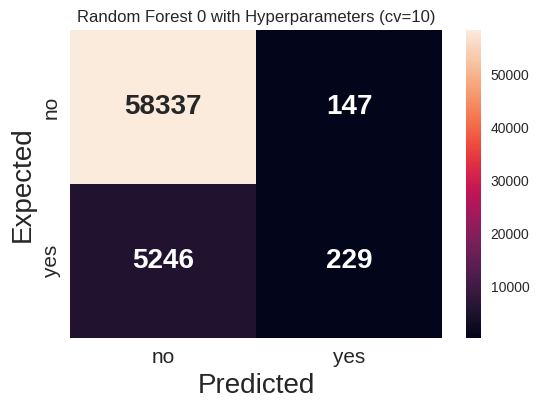

In [ ]:
# Plot confusion matrix
_, ax = plt.subplots(figsize=(6,4))
ax = sns.heatmap(confusion_matrix(y_test_rf0, y_pred_rf0), annot=True, fmt='d', annot_kws={"size": 20, "weight": "bold"})  
labels = ['yes', 'no']
ax.set_xticklabels(labels[::-1], fontsize=15);
ax.set_yticklabels(labels[::-1], fontsize=15);
ax.set_ylabel('Expected', fontsize=20);
ax.set_xlabel('Predicted', fontsize=20)
ax.set(title='Random Forest 0 with Hyperparameters (cv=10)')

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test_rf0, y_pred_rf0).ravel()
(tn, fp, fn, tp)

(58337, 147, 5246, 229)

In [ ]:
print(classification_report(y_test_rf0, y_pred_rf0))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     58484
           1       0.61      0.04      0.08      5475

    accuracy                           0.92     63959
   macro avg       0.76      0.52      0.52     63959
weighted avg       0.89      0.92      0.88     63959



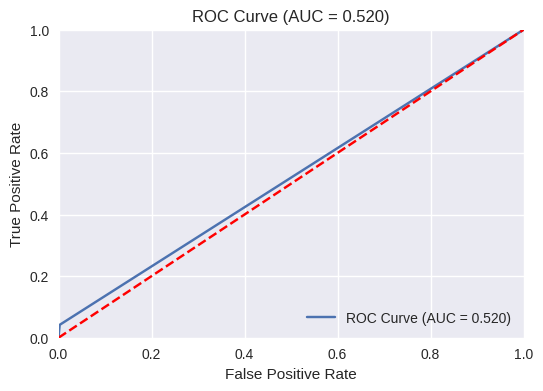

ROC - AUC score = 0.520


In [ ]:
# Compute false positive rate, true positive rate, and threshold
fpr, tpr, threshold = roc_curve(y_test_rf0, y_pred_rf0)

# Compute AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.legend(loc="lower right")
plt.show()
# score
print(f"ROC - AUC score = {roc_auc_score(y_test_rf0, y_pred_rf0):.3f}")

### Model 1

#### Data pre-processing

In [ ]:
data_original = pd.read_csv('heart_2020.csv', delimiter = ',')
data_original['HeartDisease'] = data_original['HeartDisease'].map({'No': 0, 'Yes': 1})

In [ ]:
X_train_balanced70 = pd.read_csv("X_train_balanced_70.csv")
y_train_balanced70 = pd.read_csv("y_train_balanced_70.csv")

In [ ]:
y_train_balanced70.value_counts()

HeartDisease
0               69525
1               21990
dtype: int64

In [ ]:
X_train_balanced70.head()

Unnamed: 0 Smoking AlcoholDrinking Stroke DiffWalking PhysicalActivity  \
0      129604     Yes              No     No         Yes              Yes   
1      281756     Yes              No     No          No              Yes   
2       25539     Yes              No     No          No              Yes   
3      303891     Yes              No     No          No              Yes   
4      243837      No              No     No          No               No   

  Asthma KidneyDisease SkinCancer     Sex  GenHealth   Race Diabetic  \
0     No            No         No    Male  Very good  White       No   
1    Yes            No         No  Female  Very good  White       No   
2     No            No         No    Male  Very good  White       No   
3     No            No         No    Male       Fair  White       No   
4     No            No         No  Female  Very good  White       No   

  AgeCategory    BMI  PhysicalHealth  MentalHealth  SleepTime  
0       65-69  28.04             5.0           0.0        4.0  
1       45-49  29.26             3.0           3.0        7.0  
2       45-49  38.65            30.0           5.0        7.0  
3       30-34  27.12             0.0          30.0        5.0  
4       35-39  16.64             0.0           0.0       10.0

In [ ]:
data_original.head()

HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0             0  16.60     Yes              No     No             3.0   
1             0  20.34      No              No    Yes             0.0   
2             0  26.58     Yes              No     No            20.0   
3             0  24.21      No              No     No             0.0   
4             0  23.71      No              No     No            28.0   

   MentalHealth DiffWalking     Sex  AgeCategory   Race Diabetic  \
0          30.0          No  Female        55-59  White      Yes   
1           0.0          No  Female  80 or older  White       No   
2          30.0          No    Male        65-69  White      Yes   
3           0.0          No  Female        75-79  White       No   
4           0.0         Yes  Female        40-44  White       No   

  PhysicalActivity  GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
0              Yes  Very good        5.0    Yes            No        Yes  
1              Yes  Very good        7.0     No            No         No  
2              Yes       Fair        8.0    Yes            No         No  
3               No       Good        6.0     No            No        Yes  
4              Yes  Very good        8.0     No            No         No

In [ ]:
y_train_balanced70.head()

Unnamed: 0  HeartDisease_num
0      129604                 0
1      281756                 0
2       25539                 0
3      303891                 0
4      243837                 0

In [ ]:
### X_TRAIN y X_TEST
# Eliminamos primera columna
X_train_balanced70 = X_train_balanced70.drop(columns=['Unnamed: 0'])

# Transform Yes/No to numeric
categorical_yn = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']
for var in categorical_yn:
    X_train_balanced70[var] = X_train_balanced70[var].map({'No': 0, 'Yes': 1})
    data_original[var] = data_original[var].map({'No': 0, 'Yes': 1})
    
# Transform Sex/Feamle to numeric
X_train_balanced70['Sex'] = X_train_balanced70['Sex'].map({'Female': 0, 'Male': 1})
X_train_balanced70['Sex'] = X_train_balanced70['Sex'].astype("category")
data_original['Sex'] = data_original['Sex'].map({'Female': 0, 'Male': 1})
data_original['Sex'] = data_original['Sex'].astype("category")

# Transform to categorical variables
categoric_cols = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer', 'Sex', 'GenHealth', 'Race', 'Diabetic', 'AgeCategory' ]
for var in categoric_cols:
    X_train_balanced70[var] = X_train_balanced70[var].astype("category")
    data_original[var] = data_original[var].astype("category")
    
### Y_TRAIN 
# Eliminamos primera columna
y_train_balanced70 = y_train_balanced70.drop(columns=['Unnamed: 0'])
# Modificamos nombre de la columna HeartDisease_num
y_train_balanced70 = y_train_balanced70.rename(columns={'HeartDisease_num': 'HeartDisease'})
# Pasamos HeartDisease a category
y_train_balanced70["HeartDisease"] = y_train_balanced70["HeartDisease"].astype("category")
data_original["HeartDisease"] = data_original["HeartDisease"].astype("category")

In [ ]:
data_original.head()

HeartDisease    BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  \
0            0  16.60       1               0      0             3.0   
1            0  20.34       0               0      1             0.0   
2            0  26.58       1               0      0            20.0   
3            0  24.21       0               0      0             0.0   
4            0  23.71       0               0      0            28.0   

   MentalHealth DiffWalking Sex  AgeCategory   Race Diabetic PhysicalActivity  \
0          30.0           0   0        55-59  White      Yes                1   
1           0.0           0   0  80 or older  White       No                1   
2          30.0           0   1        65-69  White      Yes                1   
3           0.0           0   0        75-79  White       No                0   
4           0.0           1   0        40-44  White       No                1   

   GenHealth  SleepTime Asthma KidneyDisease SkinCancer  
0  Very good        5.0      1             0          1  
1  Very good        7.0      0             0          0  
2       Fair        8.0      1             0          0  
3       Good        6.0      0             0          1  
4  Very good        8.0      0             0          0

In [ ]:
X_train_balanced70.head()

Smoking AlcoholDrinking Stroke DiffWalking PhysicalActivity Asthma  \
0       1               0      0           1                1      0   
1       1               0      0           0                1      1   
2       1               0      0           0                1      0   
3       1               0      0           0                1      0   
4       0               0      0           0                0      0   

  KidneyDisease SkinCancer Sex  GenHealth   Race Diabetic AgeCategory    BMI  \
0             0          0   1  Very good  White       No       65-69  28.04   
1             0          0   0  Very good  White       No       45-49  29.26   
2             0          0   1  Very good  White       No       45-49  38.65   
3             0          0   1       Fair  White       No       30-34  27.12   
4             0          0   0  Very good  White       No       35-39  16.64   

   PhysicalHealth  MentalHealth  SleepTime  
0             5.0           0.0        4.0  
1             3.0           3.0        7.0  
2            30.0           5.0        7.0  
3             0.0          30.0        5.0  
4             0.0           0.0       10.0

- **Ordinal encoder**

In [ ]:
# ORDINAL ENCODER
# variables que queremos codificar usando ordinal encoder
oe_cols  = ['GenHealth','AgeCategory']

# Define the order of the categories for each column
GenHealth_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
AgeCategory_order = ['18-24', '25-29','30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']

# Create an instance of the ordinal encoder
encoder = OrdinalEncoder(categories=[GenHealth_order, 
                                     AgeCategory_order ])
for col in oe_cols:
    # Create a new column name for the encoded data
    new_col = col + '_encoded'
    # Create an instance of the ordinal encoder
    encoder = OrdinalEncoder(categories=[eval(col+'_order')])
    # Fit and transform the selected columns
    data_original[new_col] = encoder.fit_transform(data_original[[col]])
    X_train_balanced70[new_col] = encoder.fit_transform(X_train_balanced70[[col]])

- **One_hot encoding**

In [ ]:
# ONE-HOT ENCODING
# variables que queremos codificar usando OHE
ohe_vars_rf1 = ['Smoking', 'AlcoholDrinking', 'Stroke', 
            'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 
            'SkinCancer','Race','Diabetic','Sex']

# aplicamos one - hot encoding al dataset
X_train_balanced70 = one_hot_encode(X_train_balanced70, ohe_vars_rf1)
data_original = one_hot_encode(data_original, ohe_vars_rf1)

display(X_train_balanced70.head())
display(data_original.head())
display(X_train_balanced70.shape)
display(data_original.shape)

GenHealth AgeCategory    BMI  PhysicalHealth  MentalHealth  SleepTime  \
0  Very good       65-69  28.04             5.0           0.0        4.0   
1  Very good       45-49  29.26             3.0           3.0        7.0   
2  Very good       45-49  38.65            30.0           5.0        7.0   
3       Fair       30-34  27.12             0.0          30.0        5.0   
4  Very good       35-39  16.64             0.0           0.0       10.0   

   GenHealth_encoded  AgeCategory_encoded  Smoking_0  Smoking_1  \
0                3.0                  9.0        0.0        1.0   
1                3.0                  5.0        0.0        1.0   
2                3.0                  5.0        0.0        1.0   
3                1.0                  2.0        0.0        1.0   
4                3.0                  3.0        1.0        0.0   

   AlcoholDrinking_0  AlcoholDrinking_1  Stroke_0  Stroke_1  DiffWalking_0  \
0                1.0                0.0       1.0       0.0            0.0   
1                1.0                0.0       1.0       0.0            1.0   
2                1.0                0.0       1.0       0.0            1.0   
3                1.0                0.0       1.0       0.0            1.0   
4                1.0                0.0       1.0       0.0            1.0   

   DiffWalking_1  PhysicalActivity_0  PhysicalActivity_1  Asthma_0  Asthma_1  \
0            1.0                 0.0                 1.0       1.0       0.0   
1            0.0                 0.0                 1.0       0.0       1.0   
2            0.0                 0.0                 1.0       1.0       0.0   
3            0.0                 0.0                 1.0       1.0       0.0   
4            0.0                 1.0                 0.0       1.0       0.0   

   KidneyDisease_0  KidneyDisease_1  SkinCancer_0  SkinCancer_1  \
0              1.0              0.0           1.0           0.0   
1              1.0              0.0           1.0           0.0   
2              1.0              0.0           1.0           0.0   
3              1.0              0.0           1.0           0.0   
4              1.0              0.0           1.0           0.0   

   Race_American Indian/Alaskan Native  Race_Asian  Race_Black  Race_Hispanic  \
0                                  0.0         0.0         0.0            0.0   
1                                  0.0         0.0         0.0            0.0   
2                                  0.0         0.0         0.0            0.0   
3                                  0.0         0.0         0.0            0.0   
4                                  0.0         0.0         0.0            0.0   

   Race_Other  Race_White  Diabetic_No  Diabetic_No, borderline diabetes  \
0         0.0         1.0          1.0                               0.0   
1         0.0         1.0          1.0                               0.0   
2         0.0         1.0          1.0                               0.0   
3         0.0         1.0          1.0                               0.0   
4         0.0         1.0          1.0                               0.0   

   Diabetic_Yes  Diabetic_Yes (during pregnancy)  Sex_0  Sex_1  
0           0.0                              0.0    0.0    1.0  
1           0.0                              0.0    1.0    0.0  
2           0.0                              0.0    0.0    1.0  
3           0.0                              0.0    0.0    1.0  
4           0.0                              0.0    1.0    0.0

HeartDisease    BMI  PhysicalHealth  MentalHealth  AgeCategory  GenHealth  \
0            0  16.60             3.0          30.0        55-59  Very good   
1            0  20.34             0.0           0.0  80 or older  Very good   
2            0  26.58            20.0          30.0        65-69       Fair   
3            0  24.21             0.0           0.0        75-79       Good   
4            0  23.71            28.0           0.0        40-44  Very good   

   SleepTime  GenHealth_encoded  AgeCategory_encoded  Smoking_0  Smoking_1  \
0        5.0                3.0                  7.0        0.0        1.0   
1        7.0                3.0                 12.0        1.0        0.0   
2        8.0                1.0                  9.0        0.0        1.0   
3        6.0                2.0                 11.0        1.0        0.0   
4        8.0                3.0                  4.0        1.0        0.0   

   AlcoholDrinking_0  AlcoholDrinking_1  Stroke_0  Stroke_1  DiffWalking_0  \
0                1.0                0.0       1.0       0.0            1.0   
1                1.0                0.0       0.0       1.0            1.0   
2                1.0                0.0       1.0       0.0            1.0   
3                1.0                0.0       1.0       0.0            1.0   
4                1.0                0.0       1.0       0.0            0.0   

   DiffWalking_1  PhysicalActivity_0  PhysicalActivity_1  Asthma_0  Asthma_1  \
0            0.0                 0.0                 1.0       0.0       1.0   
1            0.0                 0.0                 1.0       1.0       0.0   
2            0.0                 0.0                 1.0       0.0       1.0   
3            0.0                 1.0                 0.0       1.0       0.0   
4            1.0                 0.0                 1.0       1.0       0.0   

   KidneyDisease_0  KidneyDisease_1  SkinCancer_0  SkinCancer_1  \
0              1.0              0.0           0.0           1.0   
1              1.0              0.0           1.0           0.0   
2              1.0              0.0           1.0           0.0   
3              1.0              0.0           0.0           1.0   
4              1.0              0.0           1.0           0.0   

   Race_American Indian/Alaskan Native  Race_Asian  Race_Black  Race_Hispanic  \
0                                  0.0         0.0         0.0            0.0   
1                                  0.0         0.0         0.0            0.0   
2                                  0.0         0.0         0.0            0.0   
3                                  0.0         0.0         0.0            0.0   
4                                  0.0         0.0         0.0            0.0   

   Race_Other  Race_White  Diabetic_No  Diabetic_No, borderline diabetes  \
0         0.0         1.0          0.0                               0.0   
1         0.0         1.0          1.0                               0.0   
2         0.0         1.0          0.0                               0.0   
3         0.0         1.0          1.0                               0.0   
4         0.0         1.0          1.0                               0.0   

   Diabetic_Yes  Diabetic_Yes (during pregnancy)  Sex_0  Sex_1  
0           1.0                              0.0    1.0    0.0  
1           0.0                              0.0    1.0    0.0  
2           1.0                              0.0    0.0    1.0  
3           0.0                              0.0    1.0    0.0  
4           0.0                              0.0    1.0    0.0

(91515, 36)

(319795, 37)

In [ ]:
# una vez codificadas, eliminamos las columnas categóricas 
X_train_balanced70.drop(columns=['AgeCategory', 'GenHealth'], inplace = True)
data_original.drop(columns=['AgeCategory', 'GenHealth'], inplace = True)

In [ ]:
# Train & Test split
X_rf = data_original.drop(['HeartDisease'], axis = 1)
y_rf = data_original['HeartDisease']
X_train_rf1, X_test_rf1, y_train_rf1, y_test_rf1 = train_test_split(X_rf, y_rf, test_size=0.2, stratify = y_rf, random_state=7)

Dado que ya partíamos del dataset X_train_balanced70 y y_train_balanced70 que se habían guardado anteriormente en formato csv tras realizar la técnica train_test_split (con random_state=7) y undersampling, volveremos a realizar el train & test split con el mismo parámetro de random forest. De esta forma nos aseguraremos que la división de los datos se realice de la misma manera que antes y, por tanto, podremos utilizar los datos del test obtenidos en esta última ocasión.
Finalmente, los datasets que utilizaremos serán:
- Datasets train: X_train_balanced70 y y_train_balanced70
- Datasets test: X_test_rf1 y y_test_rf1

#### GridSearch

In [ ]:
#we enumerate the values to try
parameters_rf = [{"n_estimators":[ 10, 20, 50, 100, 200],
                   "criterion":['gini','entropy','log_loss'],
                   "max_depth": [2, 3, 4, 5, 6, 7, 9],
                   "min_samples_split": [2, 5, 10]}]

#instantiate the classifier
rf_cv = RandomForestClassifier()

# Grid search function
grid_bag_rf = GridSearchCV(cv = 10, estimator=rf_cv, param_grid=parameters_rf)
grid_bag_rf.fit(X_train_balanced70, y_train_balanced70)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_depth': [2, 3, 4, 5, 6, 7, 9],
                          'min_samples_split': [2, 5, 10],
                          'n_estimators': [10, 20, 50, 100, 200]}])

In [ ]:
grid_bag_rf.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_split': 2,
 'n_estimators': 20}

#### Model training with cross validation

In [ ]:
# Creamos el modelo con los hiperpametros seleccionados en el punto anterior
rf = RandomForestClassifier(n_estimators = grid_bag_rf.best_params_['n_estimators'], 
                             criterion = grid_bag_rf.best_params_['criterion'], 
                             max_depth = grid_bag_rf.best_params_['max_depth'],
                            min_samples_split = grid_bag_rf.best_params_['min_samples_split'])

# Entrenamos el modelo con el dataset de entrenamiento mediante cross validation
model_rf = cross_validate(rf, X_train_balanced70, y_train_balanced70, cv = 10, scoring = "f1")

for i, score in enumerate(model_rf["test_score"]):
    print(f"F1 score for the fold no. {i} on the test set: {score}")

F1 score for the fold no. 0 on the test set: 0.47041243275552896
F1 score for the fold no. 1 on the test set: 0.45302523563393127
F1 score for the fold no. 2 on the test set: 0.4501474926253687
F1 score for the fold no. 3 on the test set: 0.44765342960288806
F1 score for the fold no. 4 on the test set: 0.4623205741626794
F1 score for the fold no. 5 on the test set: 0.47875769118077943
F1 score for the fold no. 6 on the test set: 0.4726735598227474
F1 score for the fold no. 7 on the test set: 0.45593984962406015
F1 score for the fold no. 8 on the test set: 0.44630071599045346
F1 score for the fold no. 9 on the test set: 0.47255650132081006


#### Model predictions

In [ ]:
# Train the model on the training data
rf.fit(X_train_balanced70, y_train_balanced70)
# Make predictions on the test data
y_pred_rf= rf.predict(X_test_rf1)

#### Model evaluation

[Text(0.5, 1.0, 'Random Forest 1 with Hyperparameters (cv=10)')]

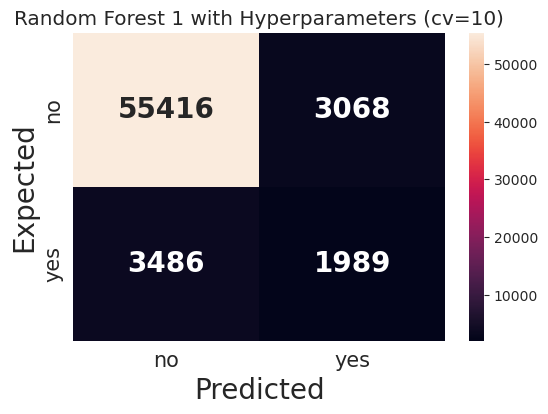

In [ ]:
# Plot confusion matrix
_, ax = plt.subplots(figsize=(6,4))
ax = sns.heatmap(confusion_matrix(y_test_rf1, y_pred_rf), annot=True, fmt='d', annot_kws={"size": 20, "weight": "bold"})  
labels = ['yes', 'no']
ax.set_xticklabels(labels[::-1], fontsize=15);
ax.set_yticklabels(labels[::-1], fontsize=15);
ax.set_ylabel('Expected', fontsize=20);
ax.set_xlabel('Predicted', fontsize=20)
ax.set(title='Random Forest 1 with Hyperparameters (cv=10)')

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test_rf1, y_pred_rf).ravel()
(tn, fp, fn, tp)

(55416, 3068, 3486, 1989)

In [ ]:
print(classification_report(y_test_rf1, y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     58484
           1       0.39      0.36      0.38      5475

    accuracy                           0.90     63959
   macro avg       0.67      0.66      0.66     63959
weighted avg       0.89      0.90      0.90     63959



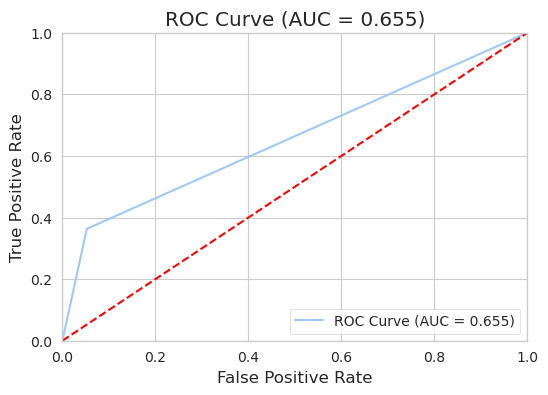

ROC - AUC score = 0.655


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

# Compute false positive rate, true positive rate, and threshold
fpr, tpr, threshold = roc_curve(y_test_rf1, y_pred_rf)

# Compute AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.legend(loc="lower right")
plt.show()
# score
print(f"ROC - AUC score = {roc_auc_score(y_test_rf1, y_pred_rf):.3f}")

### Model 2

#### Dataset pre-processing

In [ ]:
X_train_balanced90 = pd.read_csv("X_train_balanced_90.csv")
y_train_balanced90 = pd.read_csv("y_train_balanced_90.csv")

In [ ]:
y_train_balanced90.value_counts()

HeartDisease
0               35127
1               21990
dtype: int64

In [ ]:
### X_TRAIN 
# Eliminamos primera columna
X_train_balanced90 = X_train_balanced90.drop(columns=['Unnamed: 0'])

# Transform Yes/No to numeric
categorical_yn = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']
for var in categorical_yn:
    X_train_balanced90[var] = X_train_balanced90[var].map({'No': 0, 'Yes': 1})
    
# Transform Sex/Feamle to numeric
X_train_balanced90['Sex'] = X_train_balanced90['Sex'].map({'Female': 0, 'Male': 1})
X_train_balanced90['Sex'] = X_train_balanced90['Sex'].astype("category")

# Transform to categorical variables
categoric_cols = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer', 'Sex', 'GenHealth', 'Race', 'Diabetic', 'AgeCategory' ]
for var in categoric_cols:
    X_train_balanced90[var] = X_train_balanced90[var].astype("category")
    
### Y_TRAIN 
# Eliminamos primera columna
y_train_balanced90 = y_train_balanced90.drop(columns=['Unnamed: 0'])
# Modificamos nombre de la columna HeartDisease_num
y_train_balanced90 = y_train_balanced90.rename(columns={'HeartDisease_num': 'HeartDisease'})
# Pasamos HeartDisease a category
y_train_balanced90["HeartDisease"] = y_train_balanced90["HeartDisease"].astype("category")

- **Ordinal encoder**

In [ ]:
# ORDINAL ENCODER
# variables que queremos codificar usando ordinal encoder
oe_cols  = ['GenHealth','AgeCategory']

# Define the order of the categories for each column
GenHealth_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
AgeCategory_order = ['18-24', '25-29','30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']

# Create an instance of the ordinal encoder
encoder = OrdinalEncoder(categories=[GenHealth_order, 
                                     AgeCategory_order ])
for col in oe_cols:
    # Create a new column name for the encoded data
    new_col = col + '_encoded'
    # Create an instance of the ordinal encoder
    encoder = OrdinalEncoder(categories=[eval(col+'_order')])
    # Fit and transform the selected columns
    X_train_balanced90[new_col] = encoder.fit_transform(X_train_balanced90[[col]])

- **One_hot encoding**

In [ ]:
# ONE-HOT ENCODING
# variables que queremos codificar usando OHE
ohe_vars_rf1 = ['Smoking', 'AlcoholDrinking', 'Stroke', 
            'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 
            'SkinCancer','Race','Diabetic','Sex']

# aplicamos one - hot encoding al dataset
X_train_balanced90 = one_hot_encode(X_train_balanced90, ohe_vars_rf1)

display(X_train_balanced90.head())
display(X_train_balanced90.shape)

GenHealth AgeCategory    BMI  PhysicalHealth  MentalHealth  SleepTime  \
0       Fair       30-34  27.12             0.0          30.0        5.0   
1       Good       75-79  26.63            15.0           2.0        8.0   
2  Very good       18-24  28.13             0.0           5.0        7.0   
3       Good       60-64  18.02             0.0           0.0       10.0   
4  Very good       60-64  29.99             0.0           0.0        7.0   

   GenHealth_encoded  AgeCategory_encoded  Smoking_0  Smoking_1  \
0                1.0                  2.0        0.0        1.0   
1                2.0                 11.0        1.0        0.0   
2                3.0                  0.0        1.0        0.0   
3                2.0                  8.0        0.0        1.0   
4                3.0                  8.0        0.0        1.0   

   AlcoholDrinking_0  AlcoholDrinking_1  Stroke_0  Stroke_1  DiffWalking_0  \
0                1.0                0.0       1.0       0.0            1.0   
1                1.0                0.0       1.0       0.0            1.0   
2                1.0                0.0       1.0       0.0            1.0   
3                1.0                0.0       1.0       0.0            1.0   
4                1.0                0.0       1.0       0.0            1.0   

   DiffWalking_1  PhysicalActivity_0  PhysicalActivity_1  Asthma_0  Asthma_1  \
0            0.0                 0.0                 1.0       1.0       0.0   
1            0.0                 0.0                 1.0       1.0       0.0   
2            0.0                 0.0                 1.0       1.0       0.0   
3            0.0                 0.0                 1.0       0.0       1.0   
4            0.0                 0.0                 1.0       1.0       0.0   

   KidneyDisease_0  KidneyDisease_1  SkinCancer_0  SkinCancer_1  \
0              1.0              0.0           1.0           0.0   
1              1.0              0.0           1.0           0.0   
2              1.0              0.0           1.0           0.0   
3              1.0              0.0           1.0           0.0   
4              1.0              0.0           1.0           0.0   

   Race_American Indian/Alaskan Native  Race_Asian  Race_Black  Race_Hispanic  \
0                                  0.0         0.0         0.0            0.0   
1                                  0.0         0.0         0.0            0.0   
2                                  1.0         0.0         0.0            0.0   
3                                  0.0         0.0         0.0            0.0   
4                                  0.0         0.0         0.0            0.0   

   Race_Other  Race_White  Diabetic_No  Diabetic_No, borderline diabetes  \
0         0.0         1.0          1.0                               0.0   
1         0.0         1.0          1.0                               0.0   
2         0.0         0.0          1.0                               0.0   
3         0.0         1.0          1.0                               0.0   
4         0.0         1.0          1.0                               0.0   

   Diabetic_Yes  Diabetic_Yes (during pregnancy)  Sex_0  Sex_1  
0           0.0                              0.0    0.0    1.0  
1           0.0                              0.0    1.0    0.0  
2           0.0                              0.0    0.0    1.0  
3           0.0                              0.0    1.0    0.0  
4           0.0                              0.0    0.0    1.0

(57117, 36)

In [ ]:
# una vez codificadas, eliminamos las columnas categóricas 
X_train_balanced90.drop(columns=['AgeCategory', 'GenHealth'], inplace = True)

In [ ]:
# Train & Test split
X_rf2 = data_original.drop(['HeartDisease'], axis = 1)
y_rf2 = data_original['HeartDisease']
X_train_rf2, X_test_rf2, y_train_rf2, y_test_rf2 = train_test_split(X_rf2, y_rf2, test_size=0.2, stratify = y_rf2, random_state=7)

De la misma forma que el modelo 1, esta vez partíamos del dataset X_train_balanced90 y y_train_balanced90 obtenidos tras realizar la técnica train_test_split (con random_state=7) y undersampling. Por tanto, volveremos a realizar el train & test split con el mismo parámetro de random forest y nos quedaremos solo con los datasets X_test_rf2 y y_test_rf2.
Finalmente, los datasets que utilizaremos serán:
- Datasets train: X_train_balanced90 y y_train_balanced90
- Datasets test: X_test_rf2 y y_test_rf2

#### GridSearch

In [ ]:
#we enumerate the values to try
parameters_rf2 = [{"n_estimators":[ 10, 20, 50, 100, 200],
                   "criterion":['gini','entropy','log_loss'],
                   "max_depth": [2, 3, 4, 5, 6, 7, 9],
                   "min_samples_split": [2, 5, 10]}]

#instantiate the classifier
rf_cv2 = RandomForestClassifier()

# Grid search function
grid_bag_rf2 = GridSearchCV(cv = 10, estimator=rf_cv2, param_grid=parameters_rf2)
grid_bag_rf2.fit(X_train_balanced90, y_train_balanced90)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_depth': [2, 3, 4, 5, 6, 7, 9],
                          'min_samples_split': [2, 5, 10],
                          'n_estimators': [10, 20, 50, 100, 200]}])

In [ ]:
grid_bag_rf2.best_params_

{'criterion': 'log_loss',
 'max_depth': 9,
 'min_samples_split': 2,
 'n_estimators': 200}

#### Model training with cross validation

In [ ]:
# Creamos el modelo con los hiperpametros seleccionados en el punto anterior
rf2 = RandomForestClassifier(n_estimators = grid_bag_rf2.best_params_['n_estimators'], 
                             criterion = grid_bag_rf2.best_params_['criterion'], 
                             max_depth = grid_bag_rf2.best_params_['max_depth'],
                            min_samples_split = grid_bag_rf2.best_params_['min_samples_split'])

# Entrenamos el modelo con el dataset de entrenamiento mediante cross validation
model_rf2 = cross_validate(rf2, X_train_balanced90, y_train_balanced90, cv = 10, scoring = "f1")

for i, score in enumerate(model_rf2["test_score"]):
    print(f"F1 score for the fold no. {i} on the test set: {score}")

F1 score for the fold no. 0 on the test set: 0.6806682577565633
F1 score for the fold no. 1 on the test set: 0.6653846153846154
F1 score for the fold no. 2 on the test set: 0.6703270470279303
F1 score for the fold no. 3 on the test set: 0.6634217571185204
F1 score for the fold no. 4 on the test set: 0.6825775656324582
F1 score for the fold no. 5 on the test set: 0.6674687199230029
F1 score for the fold no. 6 on the test set: 0.6872495875559745
F1 score for the fold no. 7 on the test set: 0.6605988023952096
F1 score for the fold no. 8 on the test set: 0.6563876651982379
F1 score for the fold no. 9 on the test set: 0.6853478983614343


#### Model predictions

In [ ]:
# Train the model on the training data
rf2.fit(X_train_balanced90, y_train_balanced90)
# Make predictions on the test data
y_pred_rf2= rf2.predict(X_test_rf2)

#### Model evaluation

[Text(0.5, 1.0, 'Random Forest 2 with Hyperparameters (cv=10)')]

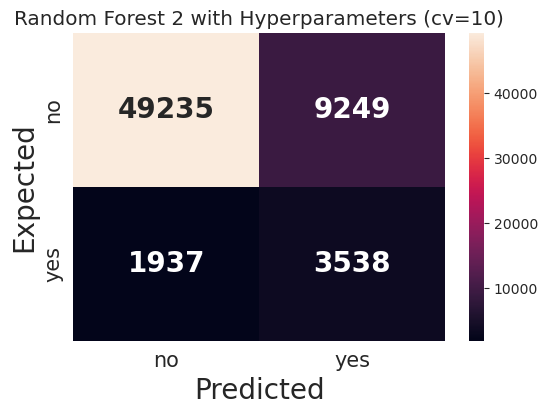

In [ ]:
# Plot confusion matrix
_, ax = plt.subplots(figsize=(6,4))
ax = sns.heatmap(confusion_matrix(y_test_rf2, y_pred_rf2), annot=True, fmt='d', annot_kws={"size": 20, "weight": "bold"})  
labels = ['yes', 'no']
ax.set_xticklabels(labels[::-1], fontsize=15);
ax.set_yticklabels(labels[::-1], fontsize=15);
ax.set_ylabel('Expected', fontsize=20);
ax.set_xlabel('Predicted', fontsize=20)
ax.set(title='Random Forest 2 with Hyperparameters (cv=10)')

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test_rf2, y_pred_rf2).ravel()
print((tn, fp, fn, tp))

(49235, 9249, 1937, 3538)


In [ ]:
print(classification_report(y_test_rf2, y_pred_rf2))

              precision    recall  f1-score   support

           0       0.96      0.84      0.90     58484
           1       0.28      0.65      0.39      5475

    accuracy                           0.83     63959
   macro avg       0.62      0.74      0.64     63959
weighted avg       0.90      0.83      0.85     63959



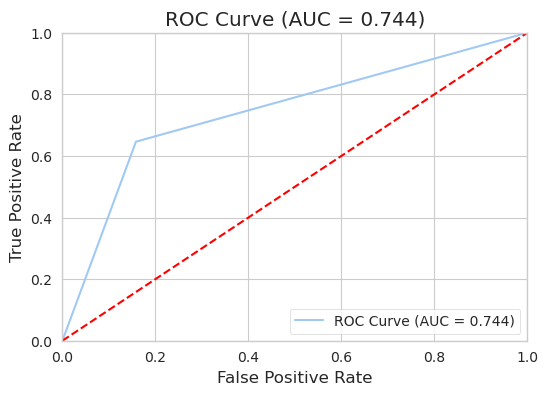

ROC - AUC score = 0.744


In [ ]:
# Compute false positive rate, true positive rate, and threshold
fpr, tpr, threshold = roc_curve(y_test_rf2, y_pred_rf2)

# Compute AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.legend(loc="lower right")
plt.show()
# score
print(f"ROC - AUC score = {roc_auc_score(y_test_rf2, y_pred_rf2):.3f}")

### Model 3

#### Dataset pre-processing

- **Downsampling**: balanceamos datos para tener las mismas instancias de ambas clases

In [ ]:
X = train_data_preprocessed.drop(['HeartDisease'], axis = 1)
y = train_data_preprocessed['HeartDisease']

# Create RandomUnderSampler object
rus = RandomUnderSampler()

# Undersample the majority class
X_train_rf3, y_train_rf3 = rus.fit_resample(X, y)

# Check the class distribution after undersampling
print(pd.Series(y_train_rf3).value_counts())

0    21898
1    21898
Name: HeartDisease, dtype: int64


In [ ]:
X_test_rf3 = test_data_preprocessed.drop(['HeartDisease'], axis = 1)
y_test_rf3 = test_data_preprocessed['HeartDisease']

- **Ordinal encoder**

In [ ]:
# variables que queremos codificar usando ordinal encoder
oe_cols  = ['BMI_cat','SleepTime_cat','GenHealth','AgeCategory']

# Define the order of the categories for each column
GenHealth_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
BMI_cat_order = ['Bajo Peso', 'Normal', 'Sobrepeso', 'Obesidad']
SleepTime_cat_order = ['<5', '5-7', '7-9', '>=9']
AgeCategory_order = ['18-24', '25-29','30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']

# Create an instance of the ordinal encoder
encoder = OrdinalEncoder(categories=[GenHealth_order, 
                                     BMI_cat_order, 
                                     SleepTime_cat_order, 
                                     AgeCategory_order ])
for col in oe_cols:
    # Create a new column name for the encoded data
    new_col = col + '_encoded'
    # Create an instance of the ordinal encoder
    encoder = OrdinalEncoder(categories=[eval(col+'_order')])
    # Fit and transform the selected columns
    X_train_rf3[new_col] = encoder.fit_transform(X_train_rf3[[col]])
    X_test_rf3[new_col] = encoder.fit_transform(X_test_rf3[[col]])

- **One_hot encoding**

In [ ]:
def one_hot_encode(df: pd.DataFrame, cat_features: List[str]) -> pd.DataFrame:
    """
    Encodes categorical features in a dataframe using scikit-learn's OneHotEncoder.

    Args:
    df (pandas.DataFrame): input dataframe
    cat_features (list): list of categorical feature column names

    Returns:
    pandas.DataFrame: dataframe with categorical features one-hot encoded
    """
    # create OneHotEncoder object and fit on categorical features
    encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    encoder.fit(df[cat_features])

    # get category names from encoder
    cat_names = encoder.get_feature_names_out(cat_features)

    # transform categorical features to one-hot encoded features and create new dataframe
    encoded_cat_features = encoder.transform(df[cat_features])
    df_encoded = pd.DataFrame(encoded_cat_features, columns=cat_names)

    # add original numerical features to encoded features dataframe
    num_features = df.drop(cat_features, axis=1)
    df_encoded = pd.concat([num_features.reset_index(drop=True), df_encoded], axis=1)

    return df_encoded

In [ ]:
X_train_rf3.head()

BMI Smoking AlcoholDrinking Stroke  PhysicalHealth  MentalHealth  \
0  27.57       1               0      0             0.0           0.0   
1  30.00       0               0      0             0.0           0.0   
2  27.41       0               1      0             0.0           0.0   
3  23.00       0               0      0             0.0           2.0   
4  21.18       1               0      0             0.0           0.0   

  DiffWalking Sex AgeCategory      Race Diabetic PhysicalActivity  GenHealth  \
0           0   1       40-44  Hispanic       No                1  Excellent   
1           0   1       60-64     White       No                1  Excellent   
2           0   1       65-69  Hispanic       No                1  Very good   
3           0   0       65-69     White       No                1  Very good   
4           0   0       60-64     White       No                1       Good   

   SleepTime Asthma KidneyDisease SkinCancer    BMI_cat SleepTime_cat  \
0        8.0      0             0          0  Sobrepeso           7-9   
1        7.0      0             0          0  Sobrepeso           5-7   
2        9.0      0             0          0  Sobrepeso           7-9   
3        6.0      0             0          0     Normal           5-7   
4        7.0      0             0          0     Normal           5-7   

   BMI_cat_encoded  SleepTime_cat_encoded  GenHealth_encoded  \
0              2.0                    2.0                4.0   
1              2.0                    1.0                4.0   
2              2.0                    2.0                3.0   
3              1.0                    1.0                3.0   
4              1.0                    1.0                2.0   

   AgeCategory_encoded  
0                  4.0  
1                  8.0  
2                  9.0  
3                  9.0  
4                  8.0

In [ ]:
# variables que queremos codificar usando OHE
ohe_vars_rf1 = ['Smoking', 'AlcoholDrinking', 'Stroke', 
            'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 
            'SkinCancer','Race','Diabetic','Sex']

# aplicamos one - hot encoding al dataset
X_train_rf3 = one_hot_encode(X_train_rf3, ohe_vars_rf1)
X_test_rf3 = one_hot_encode(X_test_rf3, ohe_vars_rf1)

In [ ]:
# una vez codificadas, eliminamos las columnas categóricas 
X_train_rf3.drop(columns=['AgeCategory', 'GenHealth', 'BMI_cat', 'SleepTime_cat'], inplace = True)
X_test_rf3.drop(columns=['AgeCategory', 'GenHealth', 'BMI_cat', 'SleepTime_cat'], inplace = True)

In [ ]:
display(X_train_rf3.shape)
display(X_test_rf3.shape)

(43796, 36)

(63959, 36)

#### GridSearch

In [ ]:
#we enumerate the values to try
parameters_rf3 = [{"n_estimators":[ 10, 20, 50, 100, 200],
                   "criterion":['gini','entropy','log_loss'],
                   "max_depth": [2, 3, 4, 5, 6, 7, 9],
                   "min_samples_split": [2, 5, 10]}]

#instantiate the classifier
rf3_cv = RandomForestClassifier()

# Grid search function
grid_bag_rf3 = GridSearchCV(cv = 10, estimator=rf3_cv, param_grid=parameters_rf3)
grid_bag_rf3.fit(X_train_rf3, y_train_rf3)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_depth': [2, 3, 4, 5, 6, 7, 9],
                          'min_samples_split': [2, 5, 10],
                          'n_estimators': [10, 20, 50, 100, 200]}])

In [ ]:
grid_bag_rf3.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_split': 5,
 'n_estimators': 100}

#### Model training with cross validation

In [ ]:
# Creamos el modelo con los hiperpametros seleccionados en el punto anterior
rf3 = RandomForestClassifier(n_estimators = grid_bag_rf3.best_params_['n_estimators'], 
                             criterion = grid_bag_rf3.best_params_['criterion'], 
                             max_depth = grid_bag_rf3.best_params_['max_depth'],
                            min_samples_split = grid_bag_rf3.best_params_['min_samples_split'])

# Entrenamos el modelo con el dataset de entrenamiento mediante cross validation
model_rf3 = cross_validate(rf3, X_train_rf3, y_train_rf3, cv = 10, scoring = "f1")

for i, score in enumerate(model_rf3["test_score"]):
    print(f"F1score for the fold no. {i} on the test set: {score}")

F1score for the fold no. 0 on the test set: 0.771992023044538
F1score for the fold no. 1 on the test set: 0.7653837790824092
F1score for the fold no. 2 on the test set: 0.7804238584225476
F1score for the fold no. 3 on the test set: 0.7725631768953068
F1score for the fold no. 4 on the test set: 0.7825517993456924
F1score for the fold no. 5 on the test set: 0.7607041947402738
F1score for the fold no. 6 on the test set: 0.7818261633011414
F1score for the fold no. 7 on the test set: 0.7818339852238156
F1score for the fold no. 8 on the test set: 0.777922642329422
F1score for the fold no. 9 on the test set: 0.7749174917491749


#### Model predictions

In [ ]:
# Train the model on the training data
rf3.fit(X_train_rf3, y_train_rf3)
# Make predictions on the test data
y_pred_rf3= rf3.predict(X_test_rf3)

#### Model evaluation

[Text(0.5, 1.0, 'Random Forest 3 with Hyperparameters (cv=10)')]

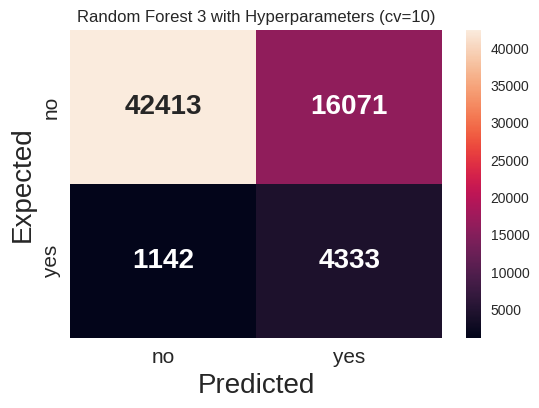

In [ ]:
# Plot confusion matrix
_, ax = plt.subplots(figsize=(6,4))
ax = sns.heatmap(confusion_matrix(y_test_rf3, y_pred_rf3), annot=True, fmt='d', annot_kws={"size": 20, "weight": "bold"})  
labels = ['yes', 'no']
ax.set_xticklabels(labels[::-1], fontsize=15);
ax.set_yticklabels(labels[::-1], fontsize=15);
ax.set_ylabel('Expected', fontsize=20);
ax.set_xlabel('Predicted', fontsize=20)
ax.set(title='Random Forest 3 with Hyperparameters (cv=10)')

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test_rf3, y_pred_rf3).ravel()
(tn, fp, fn, tp)

(42413, 16071, 1142, 4333)

In [ ]:
print(classification_report(y_test_rf3, y_pred_rf3))

              precision    recall  f1-score   support

           0       0.97      0.73      0.83     58484
           1       0.21      0.79      0.33      5475

    accuracy                           0.73     63959
   macro avg       0.59      0.76      0.58     63959
weighted avg       0.91      0.73      0.79     63959



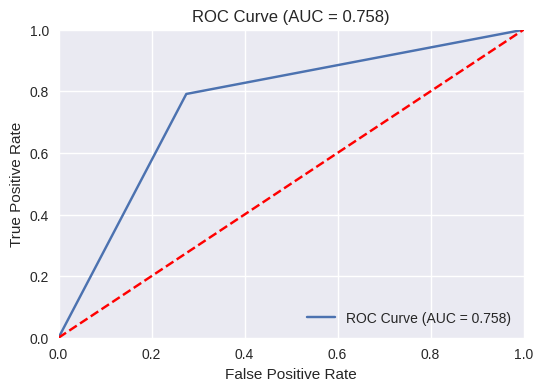

ROC - AUC score = 0.758


In [ ]:
# Compute false positive rate, true positive rate, and threshold
fpr, tpr, threshold = roc_curve(y_test_rf3, y_pred_rf3)

# Compute AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.legend(loc="lower right")
plt.show()
# score
print(f"ROC - AUC score = {roc_auc_score(y_test_rf3, y_pred_rf3):.3f}")

### Model 4

#### Dataset pre-processing

- **Feature selection**

In [ ]:
features_changes = ['BMI',	'PhysicalHealth',	'MentalHealth',	'SleepTime',
                     'Smoking_0', 'Smoking_1','AlcoholDrinking_0', 'AlcoholDrinking_1',
                     'PhysicalActivity_0','PhysicalActivity_1', 'GenHealth_encoded']

In [ ]:
X_train_rf4 = X_train_rf3[features_changes]
X_test_rf4 =  X_test_rf3[features_changes]
y_train_rf4 = y_train_rf3.copy()
y_test_rf4 = y_test_rf3.copy()

In [ ]:
X_train_rf4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43796 entries, 0 to 43795
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BMI                 43796 non-null  float64
 1   PhysicalHealth      43796 non-null  float64
 2   MentalHealth        43796 non-null  float64
 3   SleepTime           43796 non-null  float64
 4   Smoking_0           43796 non-null  float64
 5   Smoking_1           43796 non-null  float64
 6   AlcoholDrinking_0   43796 non-null  float64
 7   AlcoholDrinking_1   43796 non-null  float64
 8   PhysicalActivity_0  43796 non-null  float64
 9   PhysicalActivity_1  43796 non-null  float64
 10  GenHealth_encoded   43796 non-null  float64
dtypes: float64(11)
memory usage: 3.7 MB


In [ ]:
X_test_rf4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63959 entries, 0 to 63958
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BMI                 63959 non-null  float64
 1   PhysicalHealth      63959 non-null  float64
 2   MentalHealth        63959 non-null  float64
 3   SleepTime           63959 non-null  float64
 4   Smoking_0           63959 non-null  float64
 5   Smoking_1           63959 non-null  float64
 6   AlcoholDrinking_0   63959 non-null  float64
 7   AlcoholDrinking_1   63959 non-null  float64
 8   PhysicalActivity_0  63959 non-null  float64
 9   PhysicalActivity_1  63959 non-null  float64
 10  GenHealth_encoded   63959 non-null  float64
dtypes: float64(11)
memory usage: 5.4 MB


In [ ]:
y_train_rf4.value_counts()

0    21898
1    21898
Name: HeartDisease, dtype: int64

#### GridSearch

In [ ]:
#we enumerate the values to try
parameters_rf4 = [{"n_estimators":[ 10, 20, 50, 100, 200],
                   "criterion":['gini','entropy','log_loss'],
                   "max_depth": [2, 3, 4, 5, 6, 7, 9],
                   "min_samples_split": [2, 5, 10]}]

#instantiate the classifier
rf4_cv = RandomForestClassifier()

# Grid search function
grid_bag_rf4 = GridSearchCV(cv = 10, estimator=rf4_cv, param_grid=parameters_rf4)
grid_bag_rf4.fit(X_train_rf4, y_train_rf4)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_depth': [2, 3, 4, 5, 6, 7, 9],
                          'min_samples_split': [2, 5, 10],
                          'n_estimators': [10, 20, 50, 100, 200]}])

In [ ]:
grid_bag_rf4.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'min_samples_split': 5,
 'n_estimators': 100}

#### Model training with cross validation

In [ ]:
# Creamos el modelo con los hiperpametros seleccionados en el punto anterior
rf4 = RandomForestClassifier(n_estimators = grid_bag_rf4.best_params_['n_estimators'], 
                             criterion = grid_bag_rf4.best_params_['criterion'], 
                             max_depth = grid_bag_rf4.best_params_['max_depth'],
                            min_samples_split = grid_bag_rf4.best_params_['min_samples_split'])

# Entrenamos el modelo con el dataset de entrenamiento mediante cross validation
model_rf4 = cross_validate(rf4, X_train_rf4, y_train_rf4, cv = 10, scoring = "f1")

for i, score in enumerate(model_rf4["test_score"]):
    print(f"F1score for the fold no. {i} on the test set: {score}")

F1score for the fold no. 0 on the test set: 0.6827012025901943
F1score for the fold no. 1 on the test set: 0.6754143646408841
F1score for the fold no. 2 on the test set: 0.6829722804565571
F1score for the fold no. 3 on the test set: 0.6795847750865052
F1score for the fold no. 4 on the test set: 0.6904761904761905
F1score for the fold no. 5 on the test set: 0.6725335803612784
F1score for the fold no. 6 on the test set: 0.6768221232716195
F1score for the fold no. 7 on the test set: 0.6876580096529533
F1score for the fold no. 8 on the test set: 0.6782006920415224
F1score for the fold no. 9 on the test set: 0.6799910172917134


#### Model predictions

In [ ]:
# Train the model on the training data
rf4.fit(X_train_rf4, y_train_rf4)
# Make predictions on the test data
y_pred_rf4 = rf4.predict(X_test_rf4)

#### Model evaluation

[Text(0.5, 1.0, 'Random Forest 4 with Hyperparameters (cv=10)')]

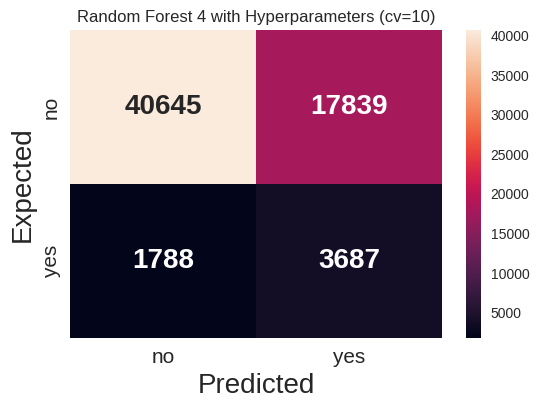

In [ ]:
# Plot confusion matrix
_, ax = plt.subplots(figsize=(6,4))
ax = sns.heatmap(confusion_matrix(y_test_rf4, y_pred_rf4), annot=True, fmt='d', annot_kws={"size": 20, "weight": "bold"})  
labels = ['yes', 'no']
ax.set_xticklabels(labels[::-1], fontsize=15);
ax.set_yticklabels(labels[::-1], fontsize=15);
ax.set_ylabel('Expected', fontsize=20);
ax.set_xlabel('Predicted', fontsize=20)
ax.set(title='Random Forest 4 with Hyperparameters (cv=10)')

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test_rf4, y_pred_rf4).ravel()
(tn, fp, fn, tp)

(40645, 17839, 1788, 3687)

In [ ]:
print(classification_report(y_test_rf4, y_pred_rf4))

              precision    recall  f1-score   support

           0       0.96      0.69      0.81     58484
           1       0.17      0.67      0.27      5475

    accuracy                           0.69     63959
   macro avg       0.56      0.68      0.54     63959
weighted avg       0.89      0.69      0.76     63959



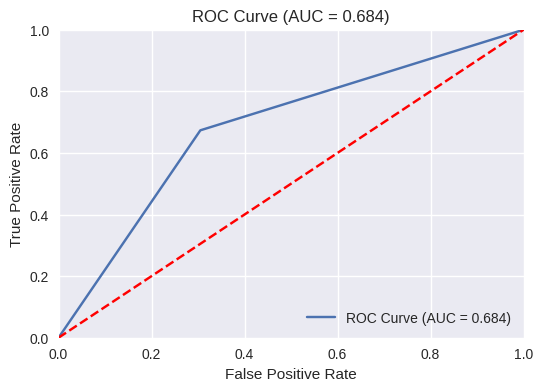

ROC - AUC score = 0.684


In [ ]:

# Compute false positive rate, true positive rate, and threshold
fpr, tpr, threshold = roc_curve(y_test_rf4, y_pred_rf4)

# Compute AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.legend(loc="lower right")
plt.show()
# score
print(f"ROC - AUC score = {roc_auc_score(y_test_rf4, y_pred_rf4):.3f}")

### Model 5

#### Dataset pre-processing

- **Feature selection**

In [ ]:
important_features = ['BMI', 'AgeCategory_encoded', 'SleepTime', 'PhysicalHealth',
                      'GenHealth_encoded','MentalHealth', 'DiffWalking_1',
                      'DiffWalking_0','Stroke_0','Stroke_1']

In [ ]:
X_test_rf5 = X_test_rf2[important_features]
X_train_rf5 = X_train_balanced90[important_features]
y_test_rf5 = y_test_rf2.copy()
y_train_rf5 = y_train_balanced90.copy()

In [ ]:
y_train_rf5.value_counts()

HeartDisease
0               35127
1               21990
dtype: int64

#### GridSearch

In [ ]:
#we enumerate the values to try
parameters_rf5 = [{"n_estimators":[ 10, 20, 50, 100, 200],
                   "criterion":['gini','entropy','log_loss'],
                   "max_depth": [2, 3, 4, 5, 6, 7, 9],
                   "min_samples_split": [2, 5, 10]}]

#instantiate the classifier
rf5_cv = RandomForestClassifier()

# Grid search function
grid_bag_rf5 = GridSearchCV(cv = 10, estimator=rf5_cv, param_grid=parameters_rf5)
grid_bag_rf5.fit(X_train_rf5, y_train_rf5)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_depth': [2, 3, 4, 5, 6, 7, 9],
                          'min_samples_split': [2, 5, 10],
                          'n_estimators': [10, 20, 50, 100, 200]}])

In [ ]:
grid_bag_rf5.best_params_

{'criterion': 'gini',
 'max_depth': 7,
 'min_samples_split': 2,
 'n_estimators': 100}

#### Model training with coss validation

In [ ]:
# Creamos el modelo con los hiperpametros seleccionados en el punto anterior
rf5 = RandomForestClassifier(n_estimators = grid_bag_rf5.best_params_['n_estimators'], 
                             criterion = grid_bag_rf5.best_params_['criterion'], 
                             max_depth = grid_bag_rf5.best_params_['max_depth'],
                            min_samples_split = grid_bag_rf5.best_params_['min_samples_split'])

# Entrenamos el modelo con el dataset de entrenamiento mediante cross validation
model_rf5 = cross_validate(rf5, X_train_rf5, y_train_rf5, cv = 10, scoring = "f1")

for i, score in enumerate(model_rf5["test_score"]):
    print(f"F1 score for the fold no. {i} on the test set: {score}")

F1 score for the fold no. 0 on the test set: 0.6677441699376587
F1 score for the fold no. 1 on the test set: 0.657290201593999
F1 score for the fold no. 2 on the test set: 0.6627689429373246
F1 score for the fold no. 3 on the test set: 0.6628679962013295
F1 score for the fold no. 4 on the test set: 0.6661965209214856
F1 score for the fold no. 5 on the test set: 0.6721991701244814
F1 score for the fold no. 6 on the test set: 0.6688236653570603
F1 score for the fold no. 7 on the test set: 0.6516488620529494
F1 score for the fold no. 8 on the test set: 0.6570618800188947
F1 score for the fold no. 9 on the test set: 0.6707482993197279


#### Model predictions

In [ ]:
# Train the model on the training data
rf5.fit(X_train_rf5, y_train_rf5)
# Make predictions on the test data
y_pred_rf5= rf5.predict(X_test_rf5)

#### Model evaluation

[Text(0.5, 1.0, 'Random Forest 5 with Hyperparameters (cv=10)')]

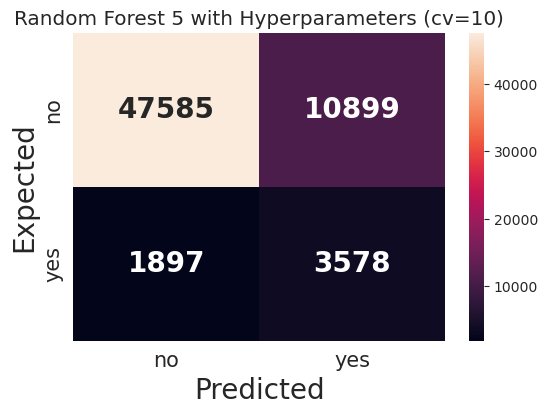

In [ ]:
# Plot confusion matrix
_, ax = plt.subplots(figsize=(6,4))
ax = sns.heatmap(confusion_matrix(y_test_rf5, y_pred_rf5), annot=True, fmt='d', annot_kws={"size": 20, "weight": "bold"})  
labels = ['yes', 'no']
ax.set_xticklabels(labels[::-1], fontsize=15);
ax.set_yticklabels(labels[::-1], fontsize=15);
ax.set_ylabel('Expected', fontsize=20);
ax.set_xlabel('Predicted', fontsize=20)
ax.set(title='Random Forest 5 with Hyperparameters (cv=10)')

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test_rf5, y_pred_rf5).ravel()
print((tn, fp, fn, tp))

(47585, 10899, 1897, 3578)


In [ ]:
print(classification_report(y_test_rf5, y_pred_rf5))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88     58484
           1       0.25      0.65      0.36      5475

    accuracy                           0.80     63959
   macro avg       0.60      0.73      0.62     63959
weighted avg       0.90      0.80      0.84     63959



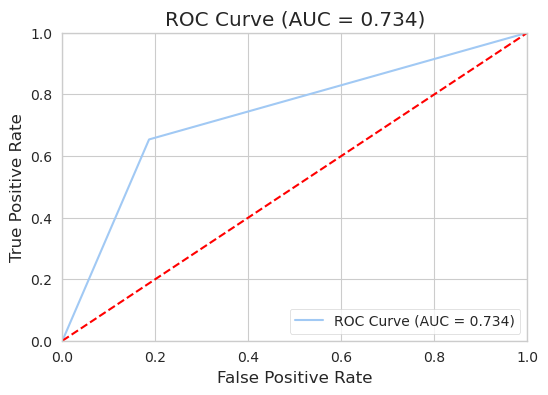

ROC - AUC score = 0.734


In [ ]:
# Compute false positive rate, true positive rate, and threshold
fpr, tpr, threshold = roc_curve(y_test_rf5, y_pred_rf5)

# Compute AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.legend(loc="lower right")
plt.show()
# score
print(f"ROC - AUC score = {roc_auc_score(y_test_rf5, y_pred_rf5):.3f}")

### Neural Network

Haremos 4 aproximaciones: 
- Modelo 1: baseline model, no tratamiento de desbalanceo, no selección de variables importantes.
- Modelo 2: tratamiento de desbalanceo: reducimos el decision threshold.
- Modelo 3: tratamiento de desbalanceo: cost-sensitive learning (class weights).
- Modelo 4: tratamiento de desbalanceo: cost-sensitive learning (class weights) +  selección de variables importantes.


#### Dataset pre-processing

**Encoding**

In [57]:
# copia de los df train y test preprocesados
train_prep_df = train_data_preprocessed.copy(deep=True)
test_prep_df = test_data_preprocessed.copy(deep=True)

# ORDINAL ENCODING:
# variables que queremos codificar usando ordinal encoder
oe_cols  = ['BMI_cat','SleepTime_cat','GenHealth','AgeCategory']

# Define the order of the categories for each column
GenHealth_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
BMI_cat_order = ['Bajo Peso', 'Normal', 'Sobrepeso', 'Obesidad']
SleepTime_cat_order = ['<5', '5-7', '7-9', '>=9']
AgeCategory_order = ['18-24', '25-29','30-34', '35-39', '40-44', '45-49', '50-54', 
                     '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']

# Create an instance of the ordinal encoder
encoder = OrdinalEncoder(categories=[GenHealth_order, 
                                     BMI_cat_order, 
                                     SleepTime_cat_order, 
                                     AgeCategory_order])
for col in oe_cols:
    # Create a new column name for the encoded data
    new_col = col + '_encoded'
    # Create an instance of the ordinal encoder
    encoder = OrdinalEncoder(categories=[eval(col+'_order')])
    # Fit and transform the selected columns
    train_prep_df[new_col] = encoder.fit_transform(train_prep_df[[col]])
    test_prep_df[new_col] = encoder.fit_transform(test_prep_df[[col]])

# ONE-HOT ENCODING
# variables que queremos codificar usando OHE
ohe_vars = ['Smoking', 'AlcoholDrinking', 'Stroke', 
            'DiffWalking', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 
            'SkinCancer','Race','Diabetic','Sex']

# aplicamos one - hot encoding al dataset
train_prep_df = one_hot_encode(train_prep_df, ohe_vars)
test_prep_df = one_hot_encode(test_prep_df, ohe_vars)


# ELIMINACIÓN VARIABLES CATEGÓRICAS NO CODIFICADAS
# una vez codificadas, eliminamos las columnas categóricas 
train_prep_df.drop(columns=['AgeCategory', 'GenHealth', 'BMI_cat', 'SleepTime_cat'], inplace = True)
test_prep_df.drop(columns=['AgeCategory', 'GenHealth', 'BMI_cat', 'SleepTime_cat'], inplace = True)

# colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

/opt/homebrew/Caskroom/miniforge/base/envs/boosting_env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
/opt/homebrew/Caskroom/miniforge/base/envs/boosting_env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


**Train - Validation - Test sets**

In [58]:
# creamos el validation set 
train_df, val_df = train_test_split(train_prep_df, stratify=train_prep_df[TARGET_VARIABLE], test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop(TARGET_VARIABLE))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop(TARGET_VARIABLE))
test_labels = np.array(test_prep_df.pop(TARGET_VARIABLE))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_prep_df)

In [59]:
# We check whether the distribution of the classes in the three sets is about the same or not:
print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.0856
Average class probability in validation set: 0.0856
Average class probability in test set:       0.0856


**Scaling**

Normalizar/escalar los atributos de entrada utilizando el StandardScaler. 
- Esto establecerá la media en 0 y la desviación estándar en 1.
- Ajustar (Fit) StandardScaler solo a train features:
    - Al ajustar el scaler al conjunto de entrenamiento y utilizarlo para transformar los conjuntos de validación y prueba, se garantiza que los factores de escalado se aprenden del conjunto de entrenamiento y no se ven influidos por los conjuntos de validación o prueba. Esto evita la fuga de datos y garantiza que las estimaciones de rendimiento del modelo en los conjuntos de validación y prueba no estén sesgadas.
    -   Si ajustamos el scaler a los conjuntos de validación o de prueba y lo utilizamos para transformar el conjunto de entrenamiento, el conjunto de entrenamiento se escalará utilizando información de los conjuntos de validación o de prueba, lo que no es deseable. Esto puede llevar a un sobreajuste del conjunto de entrenamiento y a un pobre rendimiento de la generalización en los nuevos datos.


In [60]:
scaler = StandardScaler()
# Fit scaler on training features and scale training
train_features = scaler.fit_transform(train_features)
# Scale validation and test features
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

# After normalization, the clip method is used to ensure that the features do not fall outside the range of -5 and 5. 
# Clip method to limit the range of the features between -5 and 5. This is a common technique in machine learning to prevent 
# extreme values from dominating the model's training process, as large values can result in unstable models and slow down the optimization process.
# This is a somewhat arbitrary choice of range, but it is a common practice to limit the feature values to a reasonable range.
# The range [-5, 5] is somewhat arbitrary and not necessarily specific to any particular dataset. It's more of a convention or 
# heuristic that is used in machine learning as a way of limiting the range of the feature values.
train_features = np.clip(train_features, -5, 5) 
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (204668,)
Validation labels shape: (51168,)
Test labels shape: (63959,)
Training features shape: (204668, 36)
Validation features shape: (51168, 36)
Test features shape: (63959, 36)


#### Model and metrics

Función que crea una red neuronal simple con una capa oculta densamente conectada (densly connected hidden layer), una dropout layer para reducir el sobreajuste (overfitting) y una capa sigmoid de salida que devuelva la probabilidad de que una persona tenga una cardiopatía:

In [68]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  model = keras.Sequential([
      keras.layers.Dense(16, # 16 nodes
                         activation='relu',
                         input_shape=(train_features.shape[-1],)), 
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, # the final layer has 1 node
                         activation='sigmoid', # sigmoid because this is a binary classification problem
                         bias_initializer=output_bias),
  ])

  model.compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), # 1e-3
                loss=keras.losses.BinaryCrossentropy(),
                metrics=metrics)

  return model

In [184]:
# Metrics
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

# Confusion matrix
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True healthy: NO Cardiopathies Detected (True Negatives): ', cm[0][0])
  print('True healthy: Cardiopathies Incorrectly Detected (False Positives): ', cm[0][1])
  print('Heart disease: Cardiopathies Missed (False Negatives): ', cm[1][0])
  print('Heart disease: Cardiopathies Detected (True Positives): ', cm[1][1])
  print('Total Cardiopathies: ', np.sum(cm[1]))

#  ROC (Receiver Operating Characteristic) curve plot
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=4, **kwargs)
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.title('ROC Curve (AUC = {:.3f})'.format(roc_auc))
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

# AUPRC (Area under the interpolated precision-recall curve)
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.title('AUPRC curve')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

#### Model 1 (baseline model):

- No tratamos el desequilibrio de clases. 
- Este modelo no tratará bien el desequilibrio de clases. Lo mejoraremos más adelante.


In [69]:
EPOCHS = 100
BATCH_SIZE = 2048
# Batch size of 2048: this is important to ensure that each batch 
# has a decent chance of containing a few positive samples. If the batch size was too small, 
# they would likely have no heart diseases to learn from.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [71]:
model_1 = make_model()
model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 16)                592       
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 17        
                                                                 
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


In [72]:
# Checkpoint the initial weights:
# Para que los distintos entrenamientos sean más comparables, guardamos los pesos de este modelo inicial 
# en un checkpoint file y los cargamos en cada modelo antes del entrenamiento:
initial_weights_model1 = ('weights/initial_weights_model1')
model_1.save_weights(initial_weights_model1)

##### Train the model

In [75]:
model_1 = make_model()
model_1.load_weights(initial_weights_model1)
baseline_history = model_1.fit(
                                train_features,
                                train_labels,
                                batch_size=BATCH_SIZE,
                                epochs=EPOCHS,
                                callbacks=[early_stopping],
                                validation_data=(val_features, val_labels))

Epoch 1/100
100/100 [==============================] - 5s 42ms/step - loss: 0.8628 - tp: 10321.0000 - fp: 102192.0000 - tn: 131746.0000 - fn: 11577.0000 - accuracy: 0.5553 - precision: 0.0917 - recall: 0.4713 - auc: 0.5527 - prc: 0.1010 - val_loss: 0.4919 - val_tp: 1233.0000 - val_fp: 6048.0000 - val_tn: 40740.0000 - val_fn: 3147.0000 - val_accuracy: 0.8203 - val_precision: 0.1693 - val_recall: 0.2815 - val_auc: 0.6369 - val_prc: 0.1394
Epoch 2/100
100/100 [==============================] - 2s 22ms/step - loss: 0.4854 - tp: 5811.0000 - fp: 41949.0000 - tn: 145201.0000 - fn: 11707.0000 - accuracy: 0.7378 - precision: 0.1217 - recall: 0.3317 - auc: 0.6049 - prc: 0.1232 - val_loss: 0.3088 - val_tp: 525.0000 - val_fp: 1223.0000 - val_tn: 45565.0000 - val_fn: 3855.0000 - val_accuracy: 0.9008 - val_precision: 0.3003 - val_recall: 0.1199 - val_auc: 0.7463 - val_prc: 0.2106
Epoch 3/100
100/100 [==============================] - 2s 21ms/step - loss: 0.3740 - tp: 4799.0000 - fp: 23879.0000 - tn:

##### Check training history

Creamos gráficos de la accuracy y la loss del modelo en los conjuntos de entrenamiento y validación. Estos son útiles para comprobar si hay sobreajuste (overfitting).

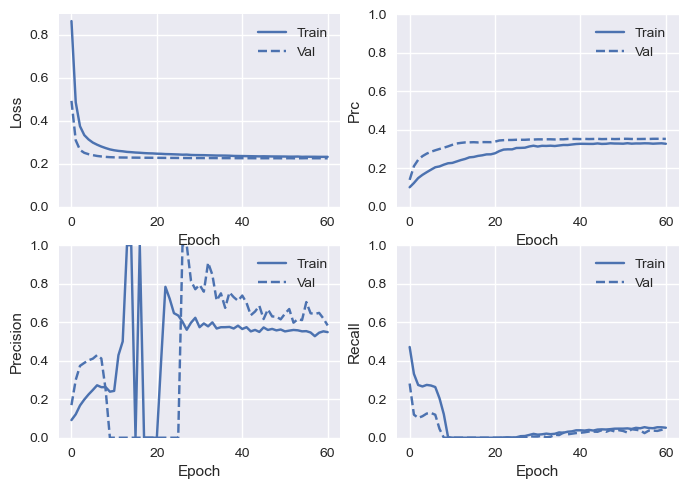

In [78]:
plot_metrics(baseline_history)

- En general, la curva de validación obtiene mejores resultados que la curva de entrenamiento. Esto se debe principalmente a que la dropout layer no está activa cuando se evalúa el modelo.

##### Evaluate metrics

Hacemos las predicciones: 

In [79]:
train_predictions_baseline = model_1.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model_1.predict(test_features, batch_size=BATCH_SIZE)

32/32 [==============================] - 0s 3ms/step


Evaluamos el modelo en el test set:

loss :  0.2274947464466095
tp :  181.0
fp :  95.0
tn :  58389.0
fn :  5294.0
accuracy :  0.9157428741455078
precision :  0.6557971239089966
recall :  0.033059362322092056
auc :  0.838677167892456
prc :  0.34924301505088806

True healthy: NO Cardiopathies Detected (True Negatives):  58389
True healthy: Cardiopathies Incorrectly Detected (False Positives):  95
Heart disease: Cardiopathies Missed (False Negatives):  5294
Heart disease: Cardiopathies Detected (True Positives):  181
Total Cardiopathies:  5475


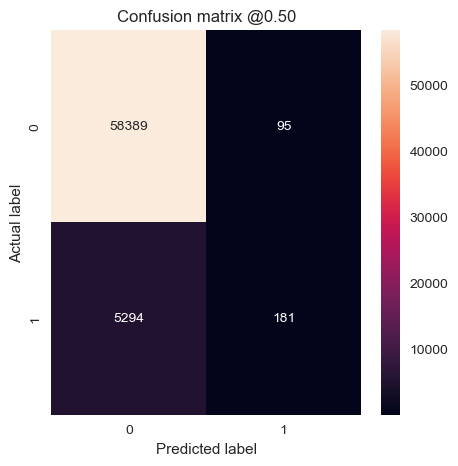

In [186]:
baseline_results = model_1.evaluate(test_features, 
                                    test_labels,
                                    batch_size=BATCH_SIZE, 
                                    verbose=0)

for name, value in zip(model_1.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline, threshold = 0.5)

In [132]:
# Convert predictions from probabilities to class labels: convert predicted probabilities into class labels.
y_pred1_classes = (test_predictions_baseline > 0.5).astype(int) # 0.5: asumimos clases balanceadas (sabemos que no están balanceadas)

# confusion matrix
tn, fp, fn, tp = confusion_matrix(test_labels, y_pred1_classes).ravel()
print(f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}")
# Print classification report
print(classification_report(test_labels, y_pred1_classes))


TN: 58389
FP: 95
FN: 5294
TP: 181
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     58484
           1       0.66      0.03      0.06      5475

    accuracy                           0.92     63959
   macro avg       0.79      0.52      0.51     63959
weighted avg       0.89      0.92      0.88     63959



- Recordemos que en este caso, como el coste de pasar por alto un caso de cardiopatía (falso negativo) es muy alto, queremos elegir un umbral que maximice la sensibilidad, aunque dé lugar a más falsos positivos. 

##### ROC

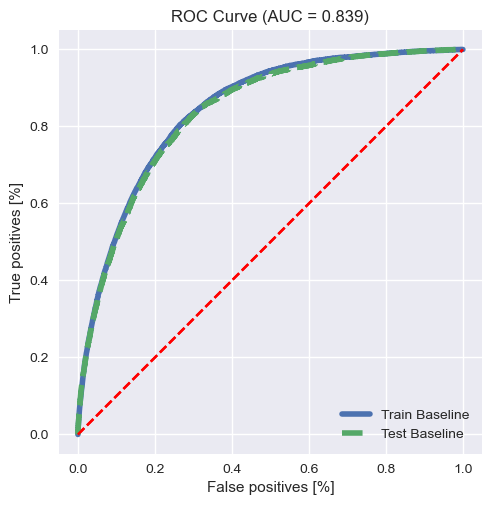

In [90]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[1], linestyle='--')
plt.legend(loc='lower right')
plt.show()

##### AUPRC

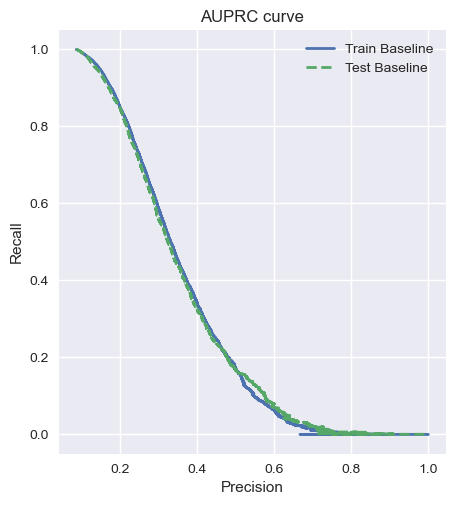

In [97]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[1], linestyle='--')
plt.legend(loc='upper right');

#### Model 2: Changing the Decision Threshold

Recordemos que hay un gran desbalanceo de clases: 

In [98]:
neg, pos = np.bincount(pd.concat([train_data_preprocessed['HeartDisease'], test_data_preprocessed['HeartDisease']], axis=0))
total = neg + pos
print('Examples:\n    Total: {}\n    Positive (1: yes): {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 319795
    Positive (1: yes): 27373 (8.56% of total)



En los problemas de clasificación binaria, en los que el objetivo es predecir una de dos clases posibles (por ejemplo, positiva o negativa), la salida de un modelo de machine learning suele ser una puntuación de probabilidad entre 0 y 1 que indica la probabilidad de la clase positiva.

Para convertir estas probabilidades en etiquetas de clase, un valor umbral común es 0.5. 
- Si la probabilidad predicha es superior a 0.5, la clase predicha se considera positiva (1); 
- en caso contrario, se considera negativa (0).

Si el conjunto de datos está muy desequilibrado, es decir, si una clase tiene muchas más muestras que la otra, puede resultar problemático utilizar un umbral fijo de 0.5 para convertir las probabilidades en etiquetas de clase.

En tales casos, el modelo puede acabar prediciendo la clase mayoritaria para la mayoría de las muestras, lo que conduce a un rendimiento pobre en la clase minoritaria. Esto se debe a que el modelo está sesgado hacia la clase mayoritaria debido a su prevalencia en el conjunto de datos.

Para solucionar este problema, existen diferentes técnicas que pueden utilizarse para gestionar conjuntos de datos desequilibrados, como por ejemplo:

- Cambiar el umbral de decisión (decision threshold): en lugar de utilizar un umbral fijo de 0.5, podemos ajustarlo a un valor que equilibre la precision y el recall de la clase positiva (1).

- Remuestreo:  equilibrar las clases del conjunto de datos sobremuestreando la clase minoritaria o submuestreando la clase mayoritaria. Las técnicas de sobremuestreo incluyen el sobremuestreo aleatorio, SMOTE y ADASYN. Las técnicas de submuestreo incluyen el submuestreo aleatorio, los enlaces Tomek y los centroides de conglomerados.

- Aprendizaje sensible a los costes:  asignar distintos costes de clasificación errónea a las clases positivas y negativas para reflejar el coste de los falsos positivos y los falsos negativos. Este enfoque puede ayudar al modelo a aprender a minimizar el coste de la clasificación errónea en lugar del error de clasificación.

En este caso (Modelo 2), utilizaremos la técnica de cambiar el decision threshold. 


En el Modelo 3, utilizaremos la técnica del aprendizaje sensible a los costes. 


Recordemos que en este caso, como el coste de pasar por alto un caso de cardiopatía (falso negativo) es muy alto, queremos elegir un umbral que maximice la sensibilidad, aunque dé lugar a más falsos positivos. 

Debemos bajar el threshold: 
- Al reducir el umbral, atribuimos un mayor coste a los falsos negativos (Tienen enfermedad cardíaca pero el modelo los clasifica como que están sanos), con lo que aumentan los falsos positivos (Están sanos pero el modelo los clasifica como que tienen enfermedad cardíaca). 

- Probamos umbrales del 5%. 

- Decision Threshold = 0.05

In [255]:
threshold_2 = 0.05

In [189]:
# Convert predictions from probabilities to class labels: convert predicted probabilities into class labels.
y_pred2_classes = (test_predictions_baseline > threshold_2).astype(int)
# Print classification report
print(classification_report(test_labels, y_pred2_classes))

              precision    recall  f1-score   support

           0       0.98      0.60      0.74     58484
           1       0.17      0.90      0.29      5475

    accuracy                           0.62     63959
   macro avg       0.58      0.75      0.52     63959
weighted avg       0.91      0.62      0.70     63959



True healthy: NO Cardiopathies Detected (True Negatives):  34885
True healthy: Cardiopathies Incorrectly Detected (False Positives):  23599
Heart disease: Cardiopathies Missed (False Negatives):  563
Heart disease: Cardiopathies Detected (True Positives):  4912
Total Cardiopathies:  5475


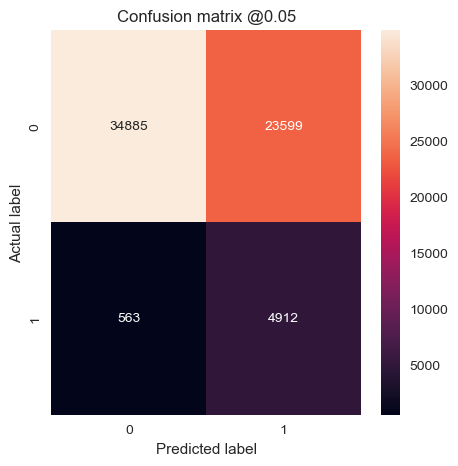

In [190]:
# confusion matrix
plot_cm(test_labels, test_predictions_baseline, threshold = threshold_2)


##### ROC 

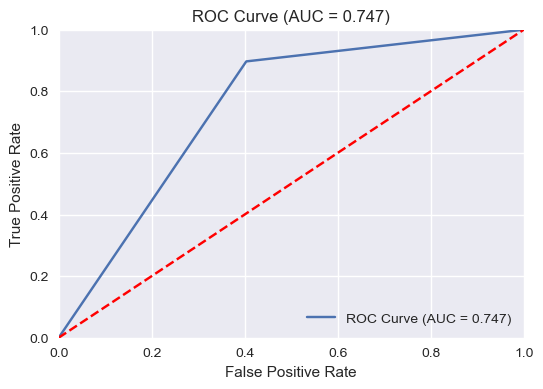

ROC - AUC score = 0.747


In [191]:
# Flatten predicted probabilities
y_pred_prob2 = y_pred2_classes.flatten()

# Compute false positive rate, true positive rate, and threshold
fpr, tpr, threshold = roc_curve(test_labels, y_pred_prob2)

# Compute AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.legend(loc="lower right")
plt.show()
# score
print(f"ROC - AUC score = {roc_auc_score(test_labels,y_pred2_classes):.3f}")

##### AUPRC

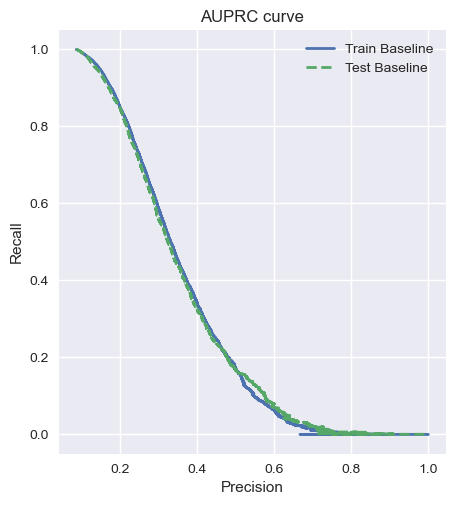

In [260]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[1], linestyle='--')
plt.legend(loc='upper right');

#### Model 3: Cost-sensitive learning (class weights)


Recordemos que el dataset está desequilibrado. Por tanto,  el modelo puede acabar prediciendo la clase mayoritaria para la mayoría de las muestras, lo que conduce a un rendimiento pobre en la clase minoritaria. Esto se debe a que el modelo está sesgado hacia la clase mayoritaria debido a su prevalencia en el conjunto de datos.

Para solucionar este problema, vimos que existían diferentes técnicas para gestionar conjuntos de datos desequilibrados, y usamos la de cambiar el decision threshold. 

En este caso (Modelo 3), utilizaremos la técnica del aprendizaje sensible a los costes. 

- Aprendizaje sensible a los costes:  asignar distintos costes de clasificación errónea a las clases positivas y negativas para reflejar el coste de los falsos positivos y los falsos negativos. Este enfoque puede ayudar al modelo a aprender a minimizar el coste de la clasificación errónea en lugar del error de clasificación.

El dataset contiene ejemplos etiquetados como 0 (negativo) o 1 (positivo) para la variable objetivo "HeartDisease". El objetivo es predecir si un paciente tiene o no una cardiopatía basándose en las características dadas.

Calculamos los pesos de clase para datos desequilibrados en un problema de clasificación binaria. 


Calculamos las ponderaciones de clase mediante la fórmula:
- weight_for_class = (total_examples / (2 * number_of_examples_in_class))

La razón de dividir por 2 es escalar los pesos para que sean similares en magnitud y evitar que un peso domine sobre los demás.

Por último, los pesos de clase se almacenan en un diccionario en el que la etiqueta de clase 0 (negativa) corresponde a weight_for_0 y la etiqueta de clase 1 (positiva) corresponde a weight_for_1. 

Estos pesos se utilizarán durante el entrenamiento para penalizar la clasificación errónea de la clase minoritaria (en este caso, la clase positiva) más que la de la clase mayoritaria.

In [ ]:
# data imbalance
raw_data.HeartDisease.value_counts()

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

In [199]:
print(f"La clase mayoritaria (0) es {292422/27373} veces mayor que la clase minoritaria (1)")

La clase mayoritaria (0) es 10.682862674898622 veces mayor que la clase minoritaria (1)


In [201]:
# Class weights
neg, pos = np.bincount(pd.concat([train_data_preprocessed['HeartDisease'], test_data_preprocessed['HeartDisease']], axis=0))
total = neg + pos
print('Examples:\n    Total: {}\n    Positive (1: yes): {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Calculate class weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0) # total / 2*num_samples_neg_0
weight_for_1 = (1 / pos) * (total / 2.0) # total / 2*num_samples_pos_1

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 319795
    Positive (1: yes): 27373 (8.56% of total)

Weight for class 0: 0.55
Weight for class 1: 5.84


##### Train a model with class weights

Volvemos a entrenar y evaluar el modelo con class weights para ver cómo afecta a las predicciones.

In [203]:
# Train a model with class weights
weighted_model = make_model()
weighted_model.load_weights(initial_weights_model1)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100
100/100 [==============================] - 5s 40ms/step - loss: 0.7668 - tp: 17266.0000 - fp: 134294.0000 - tn: 99644.0000 - fn: 4632.0000 - accuracy: 0.4570 - precision: 0.1139 - recall: 0.7885 - auc: 0.6711 - prc: 0.1550 - val_loss: 0.7260 - val_tp: 3589.0000 - val_fp: 20405.0000 - val_tn: 26383.0000 - val_fn: 791.0000 - val_accuracy: 0.5858 - val_precision: 0.1496 - val_recall: 0.8194 - val_auc: 0.7704 - val_prc: 0.2630
Epoch 2/100
100/100 [==============================] - 2s 22ms/step - loss: 0.6127 - tp: 13907.0000 - fp: 88787.0000 - tn: 98363.0000 - fn: 3611.0000 - accuracy: 0.5485 - precision: 0.1354 - recall: 0.7939 - auc: 0.7431 - prc: 0.2333 - val_loss: 0.6053 - val_tp: 3522.0000 - val_fp: 15895.0000 - val_tn: 30893.0000 - val_fn: 858.0000 - val_accuracy: 0.6726 - val_precision: 0.1814 - val_recall: 0.8041 - val_auc: 0.8131 - val_prc: 0.3113
Epoch 3/100
100/100 [==============================] - 2s 21ms/step - loss: 0.5698 - tp: 14038.0000 - fp: 75321.0000 - tn: 

##### Check training history


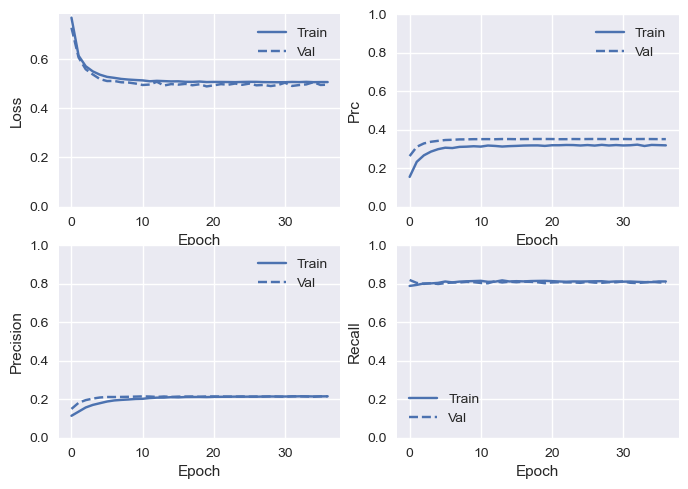

In [204]:
plot_metrics(weighted_history)

##### Evaluate metrics

Hacemos las predicciones. 

In [205]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

32/32 [==============================] - 0s 3ms/step


loss :  0.49527299404144287
tp :  4418.0
fp :  16316.0
tn :  42168.0
fn :  1057.0
accuracy :  0.7283728718757629
precision :  0.21307997405529022
recall :  0.8069406747817993
auc :  0.8389698266983032
prc :  0.34993821382522583

True healthy: NO Cardiopathies Detected (True Negatives):  42168
True healthy: Cardiopathies Incorrectly Detected (False Positives):  16316
Heart disease: Cardiopathies Missed (False Negatives):  1057
Heart disease: Cardiopathies Detected (True Positives):  4418
Total Cardiopathies:  5475


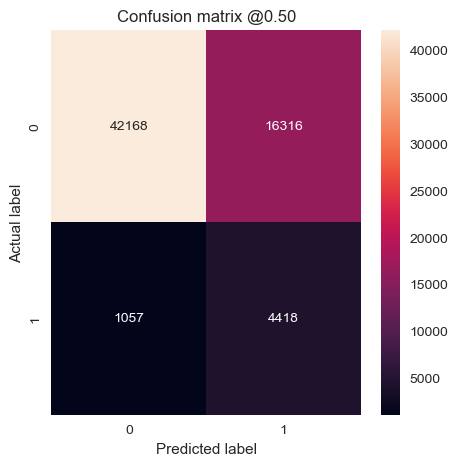

In [206]:
weighted_results = weighted_model.evaluate(test_features, 
                                           test_labels,
                                           batch_size=BATCH_SIZE, 
                                           verbose=0)

for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted) # threshold = 0.5 by default in plot_cm function

In [208]:
# Convert predictions from probabilities to class labels: convert predicted probabilities into class labels.
y_pred_weighted_classes = (test_predictions_weighted > 0.5).astype(int) # 0.5: asumimos clases balanceadas (sabemos que no están balanceadas)

# Print classification report
print(classification_report(test_labels, y_pred_weighted_classes))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83     58484
           1       0.21      0.81      0.34      5475

    accuracy                           0.73     63959
   macro avg       0.59      0.76      0.58     63959
weighted avg       0.91      0.73      0.79     63959



##### ROC

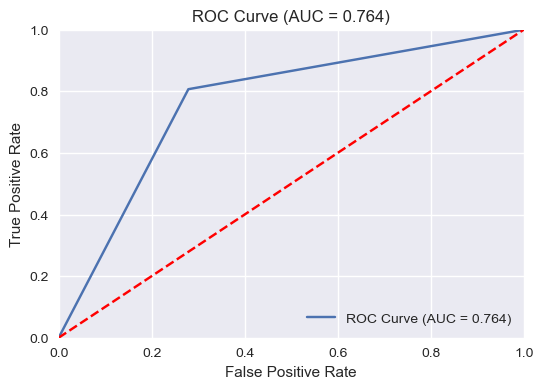

ROC - AUC score = 0.764


In [209]:
# Flatten predicted probabilities
y_pred_prob_weighted = y_pred_weighted_classes.flatten()

# Compute false positive rate, true positive rate, and threshold
fpr, tpr, threshold = roc_curve(test_labels, y_pred_prob_weighted)

# Compute AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.legend(loc="lower right")
plt.show()
# score
print(f"ROC - AUC score = {roc_auc_score(test_labels,y_pred_prob_weighted):.3f}")

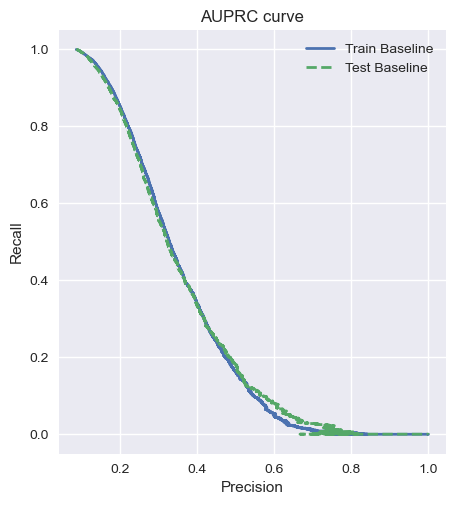

In [261]:
plot_prc("Train Baseline", train_labels, train_predictions_weighted, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')
plt.legend(loc='upper right');

#### Model 4: Feature Selection + Cost-sensitive learning

##### Feature Selection and Dataset pre-processing

In [225]:
# features selected from ANOVA, Mutual Information, ExtraTreesClassifier and PCA
important_features = [TARGET_VARIABLE, 'BMI', 'AgeCategory', 'SleepTime', 'PhysicalHealth',
                      'GenHealth', 'MentalHealth', 'DiffWalking', 'Stroke']

**Encoding**

In [226]:
# copia de los df train y test preprocesados
train_prep_df = train_data_preprocessed.copy(deep=True)
test_prep_df = test_data_preprocessed.copy(deep=True)

# seleccionamos las variables importantes
    # create new dataframes with only important features
train_prep_imp_df = train_prep_df.loc[:, important_features]
test_prep_imp_df = test_prep_df.loc[:, important_features]

# ORDINAL ENCODING:
# variables que queremos codificar usando ordinal encoder
oe_cols  = ['GenHealth','AgeCategory']

# Define the order of the categories for each column
GenHealth_order = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
#BMI_cat_order = ['Bajo Peso', 'Normal', 'Sobrepeso', 'Obesidad']
#SleepTime_cat_order = ['<5', '5-7', '7-9', '>=9']
AgeCategory_order = ['18-24', '25-29','30-34', '35-39', '40-44', '45-49', '50-54', 
                     '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']

# Create an instance of the ordinal encoder
encoder = OrdinalEncoder(categories=[GenHealth_order, 
                                     #BMI_cat_order, 
                                     #SleepTime_cat_order, 
                                     AgeCategory_order])
for col in oe_cols:
    # Create a new column name for the encoded data
    new_col = col + '_encoded'
    # Create an instance of the ordinal encoder
    encoder = OrdinalEncoder(categories=[eval(col+'_order')])
    # Fit and transform the selected columns
    train_prep_imp_df[new_col] = encoder.fit_transform(train_prep_imp_df[[col]])
    test_prep_imp_df[new_col] = encoder.fit_transform(test_prep_imp_df[[col]])

# ONE-HOT ENCODING
# variables que queremos codificar usando OHE
ohe_vars = ['Stroke', 'DiffWalking']

# aplicamos one - hot encoding al dataset
train_prep_imp_df = one_hot_encode(train_prep_imp_df, ohe_vars)
test_prep_imp_df = one_hot_encode(test_prep_imp_df, ohe_vars)


# ELIMINACIÓN VARIABLES CATEGÓRICAS NO CODIFICADAS
# una vez codificadas, eliminamos las columnas categóricas 
train_prep_imp_df.drop(columns=['AgeCategory', 'GenHealth'], inplace = True)
test_prep_imp_df.drop(columns=['AgeCategory', 'GenHealth'], inplace = True)

# colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

/opt/homebrew/Caskroom/miniforge/base/envs/boosting_env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
/opt/homebrew/Caskroom/miniforge/base/envs/boosting_env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [227]:
train_prep_imp_df.head()

HeartDisease    BMI  SleepTime  PhysicalHealth  MentalHealth  \
0            0  23.62        5.0            30.0          30.0   
1            0  22.43        8.0             1.0           0.0   
2            0  33.28        7.0            20.0          30.0   
3            0  24.96        8.0             0.0           0.0   
4            0  27.25        5.0             0.0           0.0   

   GenHealth_encoded  AgeCategory_encoded  Stroke_0  Stroke_1  DiffWalking_0  \
0                1.0                  5.0       1.0       0.0            0.0   
1                3.0                  1.0       1.0       0.0            1.0   
2                1.0                  2.0       1.0       0.0            1.0   
3                3.0                  9.0       1.0       0.0            1.0   
4                3.0                  7.0       1.0       0.0            1.0   

   DiffWalking_1  
0            1.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

**Train - Validation - Test sets**

In [228]:
# creamos el validation set 
train_imp_df, val_imp_df = train_test_split(train_prep_imp_df, 
                                            stratify=train_prep_imp_df[TARGET_VARIABLE], 
                                            test_size=0.2)

# Form np arrays of labels and features.
train_labels_imp = np.array(train_imp_df.pop(TARGET_VARIABLE))
bool_train_labels_imp = train_labels_imp != 0
val_labels_imp = np.array(val_imp_df.pop(TARGET_VARIABLE))
test_labels_imp = np.array(test_prep_imp_df.pop(TARGET_VARIABLE))

train_features_imp = np.array(train_imp_df)
val_features_imp = np.array(val_imp_df)
test_features_imp = np.array(test_prep_imp_df)

In [229]:
# We check whether the distribution of the classes in the three sets is about the same or not:
print(f'Average class probability in training set:   {train_labels_imp.mean():.4f}')
print(f'Average class probability in validation set: {val_labels_imp.mean():.4f}')
print(f'Average class probability in test set:       {test_labels_imp.mean():.4f}')

Average class probability in training set:   0.0856
Average class probability in validation set: 0.0856
Average class probability in test set:       0.0856


**Scaling**

Normalizar/escalar los atributos de entrada utilizando el StandardScaler. 
- Esto establecerá la media en 0 y la desviación estándar en 1.
- Ajustar (Fit) StandardScaler solo a train features:
    - Al ajustar el scaler al conjunto de entrenamiento y utilizarlo para transformar los conjuntos de validación y prueba, se garantiza que los factores de escalado se aprenden del conjunto de entrenamiento y no se ven influidos por los conjuntos de validación o prueba. Esto evita la fuga de datos y garantiza que las estimaciones de rendimiento del modelo en los conjuntos de validación y prueba no estén sesgadas.
    -   Si ajustamos el scaler a los conjuntos de validación o de prueba y lo utilizamos para transformar el conjunto de entrenamiento, el conjunto de entrenamiento se escalará utilizando información de los conjuntos de validación o de prueba, lo que no es deseable. Esto puede llevar a un sobreajuste del conjunto de entrenamiento y a un pobre rendimiento de la generalización en los nuevos datos.


In [230]:
scaler = StandardScaler()
# Fit scaler on training features and scale training
train_features_imp = scaler.fit_transform(train_features_imp)
# Scale validation and test features
val_features_imp = scaler.transform(val_features_imp)
test_features_imp = scaler.transform(test_features_imp)

# After normalization, the clip method is used to ensure that the features do not fall outside the range of -5 and 5. 
# Clip method to limit the range of the features between -5 and 5. This is a common technique in machine learning to prevent 
# extreme values from dominating the model's training process, as large values can result in unstable models and slow down the optimization process.
# This is a somewhat arbitrary choice of range, but it is a common practice to limit the feature values to a reasonable range.
# The range [-5, 5] is somewhat arbitrary and not necessarily specific to any particular dataset. It's more of a convention or 
# heuristic that is used in machine learning as a way of limiting the range of the feature values.
train_features_imp = np.clip(train_features_imp, -5, 5) 
val_features_imp = np.clip(val_features_imp, -5, 5)
test_features_imp = np.clip(test_features_imp, -5, 5)


print('Training labels shape:', train_labels_imp.shape)
print('Validation labels shape:', val_labels_imp.shape)
print('Test labels shape:', test_labels_imp.shape)

print('Training features shape:', train_features_imp.shape)
print('Validation features shape:', val_features_imp.shape)
print('Test features shape:', test_features_imp.shape)

Training labels shape: (204668,)
Validation labels shape: (51168,)
Test labels shape: (63959,)
Training features shape: (204668, 10)
Validation features shape: (51168, 10)
Test features shape: (63959, 10)


##### Model and metrics

El modelo es el mismo, pero ahora la input_shape será diferente debido a la selección de variables: en lugar de 36, tenemos 10 features de entrada. 

In [233]:
train_features_imp.shape[-1]

10

In [234]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  model = keras.Sequential([
      keras.layers.Dense(16, # 16 nodes
                         activation='relu',
                         input_shape=(train_features_imp.shape[-1],)), 
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, # the final layer has 1 node
                         activation='sigmoid', # sigmoid because this is a binary classification problem
                         bias_initializer=output_bias),
  ])

  model.compile(
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), # 1e-3
                loss=keras.losses.BinaryCrossentropy(),
                metrics=metrics)

  return model

In [235]:
EPOCHS = 100
BATCH_SIZE = 2048
# Batch size of 2048: this is important to ensure that each batch 
# has a decent chance of containing a few positive samples. If the batch size was too small, 
# they would likely have no heart diseases to learn from.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [236]:
weighted_model_imp = make_model()
weighted_model_imp.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 16)                176       
                                                                 
 dropout_11 (Dropout)        (None, 16)                0         
                                                                 
 dense_35 (Dense)            (None, 1)                 17        
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [237]:
# Checkpoint the initial weights:
# Para que los distintos entrenamientos sean más comparables, guardamos los pesos de este modelo inicial 
# en un checkpoint file y los cargamos en cada modelo antes del entrenamiento:
initial_weights_weighted_model_imp = ('weights/initial_weights_weighted_model_imp')
weighted_model_imp.save_weights(initial_weights_weighted_model_imp)

##### Define class weights

In [238]:
# Class weights
neg, pos = np.bincount(pd.concat([train_data_preprocessed['HeartDisease'], test_data_preprocessed['HeartDisease']], axis=0))
total = neg + pos
print('Examples:\n    Total: {}\n    Positive (1: yes): {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Calculate class weights
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0) # total / 2*num_samples_neg_0
weight_for_1 = (1 / pos) * (total / 2.0) # total / 2*num_samples_pos_1

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 319795
    Positive (1: yes): 27373 (8.56% of total)

Weight for class 0: 0.55
Weight for class 1: 5.84


##### Train a model with class weights

Volvemos a entrenar y evaluar el modelo con class weights para ver cómo afecta a las predicciones.

In [240]:
# Train a model with class weights
weighted_model_imp = make_model()
weighted_model_imp.load_weights(initial_weights_weighted_model_imp)

weighted_history_imp = weighted_model_imp.fit(
    train_features_imp,
    train_labels_imp,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features_imp, val_labels_imp),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100
100/100 [==============================] - 5s 40ms/step - loss: 0.7419 - tp: 12412.0000 - fp: 89465.0000 - tn: 144473.0000 - fn: 9486.0000 - accuracy: 0.6132 - precision: 0.1218 - recall: 0.5668 - auc: 0.6330 - prc: 0.1721 - val_loss: 0.6467 - val_tp: 2672.0000 - val_fp: 11098.0000 - val_tn: 35690.0000 - val_fn: 1708.0000 - val_accuracy: 0.7497 - val_precision: 0.1940 - val_recall: 0.6100 - val_auc: 0.7673 - val_prc: 0.2509
Epoch 2/100
100/100 [==============================] - 2s 22ms/step - loss: 0.6246 - tp: 10714.0000 - fp: 55604.0000 - tn: 131546.0000 - fn: 6804.0000 - accuracy: 0.6951 - precision: 0.1616 - recall: 0.6116 - auc: 0.7169 - prc: 0.2103 - val_loss: 0.5827 - val_tp: 3083.0000 - val_fp: 11812.0000 - val_tn: 34976.0000 - val_fn: 1297.0000 - val_accuracy: 0.7438 - val_precision: 0.2070 - val_recall: 0.7039 - val_auc: 0.8082 - val_prc: 0.2786
Epoch 3/100
100/100 [==============================] - 2s 21ms/step - loss: 0.5881 - tp: 11654.0000 - fp: 53531.0000 - t

##### Check training history


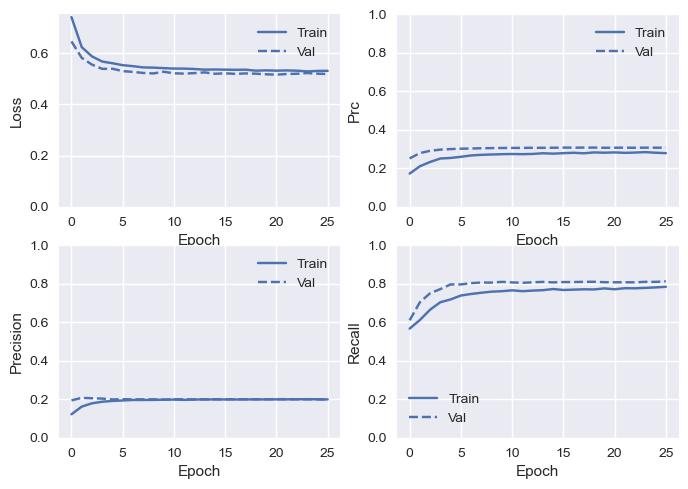

In [241]:
plot_metrics(weighted_history_imp)

##### Evaluate metrics

Hacemos las predicciones. 

In [242]:
train_predictions_weighted_imp = weighted_model_imp.predict(train_features_imp, batch_size=BATCH_SIZE)
test_predictions_weighted_imp = weighted_model_imp.predict(test_features_imp, batch_size=BATCH_SIZE)

32/32 [==============================] - 0s 3ms/step


loss :  0.5229126214981079
tp :  4355.0
fp :  17858.0
tn :  40626.0
fn :  1120.0
accuracy :  0.703278660774231
precision :  0.19605636596679688
recall :  0.7954338192939758
auc :  0.8211424350738525
prc :  0.31158003211021423

True healthy: NO Cardiopathies Detected (True Negatives):  40626
True healthy: Cardiopathies Incorrectly Detected (False Positives):  17858
Heart disease: Cardiopathies Missed (False Negatives):  1120
Heart disease: Cardiopathies Detected (True Positives):  4355
Total Cardiopathies:  5475


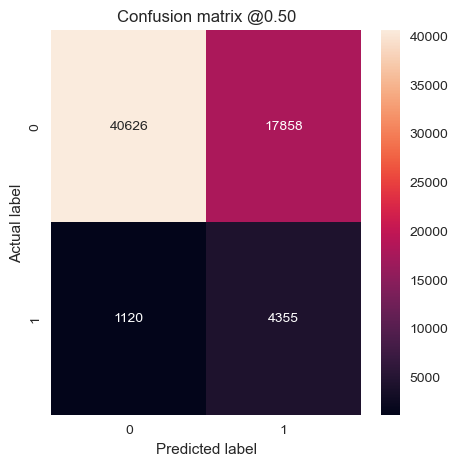

In [243]:
weighted_results_imp = weighted_model_imp.evaluate(test_features_imp, 
                                                   test_labels_imp,
                                                   batch_size=BATCH_SIZE, 
                                                   verbose=0)

for name, value in zip(weighted_model_imp.metrics_names, weighted_results_imp):
  print(name, ': ', value)
print()

plot_cm(test_labels_imp, test_predictions_weighted_imp) # threshold = 0.5 by default in plot_cm function

In [244]:
# Convert predictions from probabilities to class labels: convert predicted probabilities into class labels.
y_pred_weighted_classes_imp = (test_predictions_weighted_imp > 0.5).astype(int) # 0.5: asumimos clases balanceadas (sabemos que no están balanceadas)

# Print classification report
print(classification_report(test_labels_imp, y_pred_weighted_classes_imp))

              precision    recall  f1-score   support

           0       0.97      0.69      0.81     58484
           1       0.20      0.80      0.31      5475

    accuracy                           0.70     63959
   macro avg       0.58      0.75      0.56     63959
weighted avg       0.91      0.70      0.77     63959



##### ROC

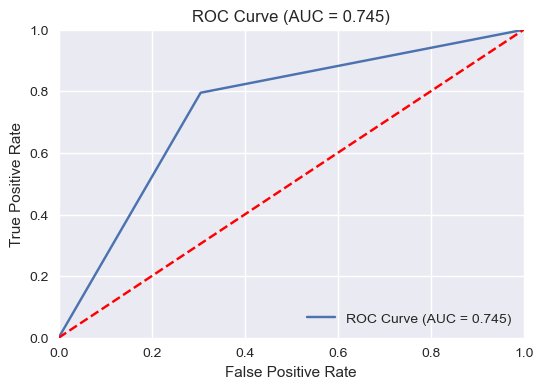

ROC - AUC score = 0.745


In [245]:
# Flatten predicted probabilities
y_pred_prob_weighted_imp = y_pred_weighted_classes_imp.flatten()

# Compute false positive rate, true positive rate, and threshold
fpr, tpr, threshold = roc_curve(test_labels_imp, y_pred_prob_weighted_imp)

# Compute AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.legend(loc="lower right")
plt.show()
# score
print(f"ROC - AUC score = {roc_auc_score(test_labels_imp, y_pred_prob_weighted_imp):.3f}")